In [1]:
try:
    import google.colab
    IN_COLAB = True
    # %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    %pip install git+https://github.com/neelnanda-io/PySvelte.git
    renderer = "colab"
except:
    IN_COLAB = False
    from IPython import get_ipython
    %load_ext autoreload
    %autoreload 2
    renderer = "jupyterlab"

In [2]:
%%bash
cd ../
pip install poetry
poetry install
cd notebooks

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 13.7 MB/s eta 0:00:00
  Using cached importlib_metadata-6.7.0-py3-none-any.whl (22 kB)
  Using cached platformdirs-3.10.0-py3-none-any.whl (17 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.3
    Uninstalling urllib3-2.0.3:
      Successfully uninstalled urllib3-2.0.3
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 3.8.0
    Uninstalling platformdirs-3.8.0:
      Successfully uninstalled platformdirs-3.8.0
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.2.0
    Uninstalling importlib-metadata-5.2.0:
      Successfully uninstalled importlib-metadata-5.2.0
Installing dependencies from lock file

Package operations: 0 installs, 3 updates, 0 removals

  • Updating importlib-metadata (6.7.0 -> 5.2.0)
  • Updating urllib3 (1.26.16 -> 2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
circuitsvis 1.40.0 requires importlib-metadata<6.0.0,>=5.1.0, but you have importlib-metadata 6.7.0 which is incompatible.
sagemaker 2.167.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metadata 6.7.0 which is incompatible.
sagemaker 2.167.0 requires protobuf<4.0,>=3.1, but you have protobuf 4.23.3 which is incompatible.


In [4]:

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
pio.renderers.default = renderer

In [5]:
# Import stuff
import types
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [6]:
torch.cuda.is_available()

True

In [12]:
import ast
import pandas as pd

In [7]:
if IN_COLAB: 
    import pysvelte

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens.utilities import devices
from transformer_lens.past_key_value_caching import HookedTransformerKeyValueCache
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [8]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [9]:
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

def cuda():
    return torch.cuda.is_available()

def get_device(): 
    return "cuda" if cuda() else "cpu"
device = get_device()
device


'cuda'

In [10]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


In [31]:
path = "data/bijective_facts.csv"
df = pd.read_csv(path)
dataset = df.to_dict(orient="records")
for prompt in dataset: 
    prompt['counter_factual_1'] = ast.literal_eval(prompt['counter_factual_1'])
    prompt['counter_factual_2'] = ast.literal_eval(prompt['counter_factual_2'])


In [32]:
dataset[0]

{'sentence_1': '{subject} is the capital of {obj}',
 'subject_1': 'Paris',
 'object_1': 'France',
 'counter_factual_1': ['Italy', 'Germany', 'Canada', 'USA', 'China'],
 'sentence_2': 'The capital of {subject} is {obj}',
 'subject_2': 'France',
 'object_2': 'Paris',
 'counter_factual_2': ['Rome', 'Amsterdam', 'Ottawa', 'London', 'Berlin']}

## Checking Logits

In [33]:
#logits for correct answer
for prompt in dataset:
    subject_prompt = prompt["sentence_1"].format(
        subject = prompt["subject_1"],
        obj = ""
    )[:-1]
    test_answer = prompt["object_1"]
    utils.test_prompt(subject_prompt, test_answer, model, prepend_bos=True)
    
    subject_prompt = prompt["sentence_2"].format(
        subject = prompt["subject_2"],
        obj = ""
    )[:-1]
    test_answer = prompt["object_2"]
    utils.test_prompt(subject_prompt, test_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Paris', ' is', ' the', ' capital', ' of']
Tokenized answer: [' France']


Performance on answer token:
Rank: 0        Logit: 16.93 Prob: 33.42% Token: | France|

Top 0th token. Logit: 16.93 Prob: 33.42% Token: | France|
Top 1th token. Logit: 16.61 Prob: 24.46% Token: | the|
Top 2th token. Logit: 15.30 Prob:  6.59% Token: | a|
Top 3th token. Logit: 14.68 Prob:  3.52% Token: | Europe|
Top 4th token. Logit: 13.98 Prob:  1.75% Token: | French|
Top 5th token. Logit: 13.93 Prob:  1.67% Token: | Paris|
Top 6th token. Logit: 13.78 Prob:  1.43% Token: | Belgium|
Top 7th token. Logit: 13.75 Prob:  1.39% Token: | one|
Top 8th token. Logit: 13.22 Prob:  0.82% Token: | an|
Top 9th token. Logit: 12.86 Prob:  0.57% Token: | Germany|


Ranks of the answer tokens: [(' France', 0)]

Tokenized prompt: ['<|endoftext|>', 'The', ' capital', ' of', ' France', ' is']
Tokenized answer: [' Paris']


Performance on answer token:
Rank: 92       Logit: 11.02 Prob:  0.16% Token: | Paris|

Top 0th token. Logit: 14.39 Prob:  4.75% Token: | now|
Top 1th token. Logit: 14.15 Prob:  3.74% Token: | the|
Top 2th token. Logit: 14.10 Prob:  3.55% Token: | a|
Top 3th token. Logit: 13.96 Prob:  3.09% Token: | home|
Top 4th token. Logit: 13.82 Prob:  2.70% Token: | in|
Top 5th token. Logit: 13.77 Prob:  2.57% Token: | under|
Top 6th token. Logit: 13.57 Prob:  2.09% Token: | being|
Top 7th token. Logit: 13.42 Prob:  1.80% Token: | set|
Top 8th token. Logit: 13.35 Prob:  1.68% Token: | on|
Top 9th token. Logit: 13.23 Prob:  1.49% Token: | not|


Ranks of the answer tokens: [(' Paris', 92)]

Tokenized prompt: ['<|endoftext|>', 'R', 'ome', ' is', ' the', ' capital', ' of']
Tokenized answer: [' Italy']


Performance on answer token:
Rank: 0        Logit: 16.16 Prob: 28.04% Token: | Italy|

Top 0th token. Logit: 16.16 Prob: 28.04% Token: | Italy|
Top 1th token. Logit: 16.05 Prob: 25.17% Token: | the|
Top 2th token. Logit: 14.13 Prob:  3.69% Token: | Rome|
Top 3th token. Logit: 13.94 Prob:  3.04% Token: | a|
Top 4th token. Logit: 13.71 Prob:  2.44% Token: | Romania|
Top 5th token. Logit: 13.47 Prob:  1.92% Token: | Europe|
Top 6th token. Logit: 13.20 Prob:  1.45% Token: | Latin|
Top 7th token. Logit: 13.14 Prob:  1.37% Token: | Greece|
Top 8th token. Logit: 13.11 Prob:  1.33% Token: | Spain|
Top 9th token. Logit: 13.03 Prob:  1.23% Token: | Sicily|


Ranks of the answer tokens: [(' Italy', 0)]

Tokenized prompt: ['<|endoftext|>', 'The', ' capital', ' of', ' Italy', ' is']
Tokenized answer: [' Rome']


Performance on answer token:
Rank: 7        Logit: 12.98 Prob:  1.53% Token: | Rome|

Top 0th token. Logit: 14.09 Prob:  4.61% Token: | now|
Top 1th token. Logit: 13.97 Prob:  4.10% Token: | the|
Top 2th token. Logit: 13.94 Prob:  3.96% Token: | a|
Top 3th token. Logit: 13.76 Prob:  3.31% Token: | home|
Top 4th token. Logit: 13.63 Prob:  2.92% Token: | in|
Top 5th token. Logit: 13.04 Prob:  1.62% Token: | being|
Top 6th token. Logit: 13.03 Prob:  1.61% Token: | on|
Top 7th token. Logit: 12.98 Prob:  1.53% Token: | Rome|
Top 8th token. Logit: 12.95 Prob:  1.47% Token: | set|
Top 9th token. Logit: 12.94 Prob:  1.46% Token: | also|


Ranks of the answer tokens: [(' Rome', 7)]

Tokenized prompt: ['<|endoftext|>', 'Ott', 'awa', ' is', ' the', ' capital', ' of']
Tokenized answer: [' Canada']


Performance on answer token:
Rank: 0        Logit: 16.50 Prob: 31.07% Token: | Canada|

Top 0th token. Logit: 16.50 Prob: 31.07% Token: | Canada|
Top 1th token. Logit: 16.29 Prob: 25.22% Token: | the|
Top 2th token. Logit: 15.21 Prob:  8.60% Token: | a|
Top 3th token. Logit: 14.53 Prob:  4.36% Token: | Ontario|
Top 4th token. Logit: 13.69 Prob:  1.88% Token: | Alberta|
Top 5th token. Logit: 13.60 Prob:  1.70% Token: | an|
Top 6th token. Logit: 13.53 Prob:  1.60% Token: | Quebec|
Top 7th token. Logit: 13.44 Prob:  1.46% Token: | Ottawa|
Top 8th token. Logit: 13.41 Prob:  1.41% Token: | one|
Top 9th token. Logit: 13.25 Prob:  1.21% Token: | British|


Ranks of the answer tokens: [(' Canada', 0)]

Tokenized prompt: ['<|endoftext|>', 'The', ' capital', ' of', ' Canada', ' is']
Tokenized answer: [' Ottawa']


Performance on answer token:
Rank: 219      Logit: 10.02 Prob:  0.06% Token: | Ottawa|

Top 0th token. Logit: 14.71 Prob:  6.26% Token: | home|
Top 1th token. Logit: 14.40 Prob:  4.61% Token: | a|
Top 2th token. Logit: 14.28 Prob:  4.08% Token: | the|
Top 3th token. Logit: 14.14 Prob:  3.57% Token: | now|
Top 4th token. Logit: 13.98 Prob:  3.04% Token: | in|
Top 5th token. Logit: 13.50 Prob:  1.87% Token: | not|
Top 6th token. Logit: 13.49 Prob:  1.85% Token: | being|
Top 7th token. Logit: 13.28 Prob:  1.51% Token: | one|
Top 8th token. Logit: 13.17 Prob:  1.34% Token: | known|
Top 9th token. Logit: 13.16 Prob:  1.33% Token: | on|


Ranks of the answer tokens: [(' Ottawa', 219)]

Tokenized prompt: ['<|endoftext|>', 'D', 'olphins', ' live', ' in', ' the']
Tokenized answer: [' ocean']


Performance on answer token:
Rank: 4        Logit: 12.55 Prob:  1.82% Token: | ocean|

Top 0th token. Logit: 14.04 Prob:  8.13% Token: | wild|
Top 1th token. Logit: 13.55 Prob:  4.98% Token: | same|
Top 2th token. Logit: 13.15 Prob:  3.33% Token: | middle|
Top 3th token. Logit: 12.65 Prob:  2.03% Token: | heart|
Top 4th token. Logit: 12.55 Prob:  1.82% Token: | ocean|
Top 5th token. Logit: 12.39 Prob:  1.56% Token: | Caribbean|
Top 6th token. Logit: 12.35 Prob:  1.51% Token: | Miami|
Top 7th token. Logit: 12.31 Prob:  1.44% Token: | trop|
Top 8th token. Logit: 12.23 Prob:  1.33% Token: | Atlantic|
Top 9th token. Logit: 12.22 Prob:  1.32% Token: | Pacific|


Ranks of the answer tokens: [(' ocean', 4)]

Tokenized prompt: ['<|endoftext|>', 'The', ' ocean', ' is', ' home', ' to']
Tokenized answer: [' dolphins']


Performance on answer token:
Rank: 56       Logit: 11.48 Prob:  0.20% Token: | dolphins|

Top 0th token. Logit: 15.41 Prob: 10.34% Token: | a|
Top 1th token. Logit: 15.06 Prob:  7.28% Token: | the|
Top 2th token. Logit: 14.95 Prob:  6.51% Token: | more|
Top 3th token. Logit: 14.94 Prob:  6.41% Token: | many|
Top 4th token. Logit: 14.79 Prob:  5.56% Token: | about|
Top 5th token. Logit: 14.76 Prob:  5.37% Token: | some|
Top 6th token. Logit: 13.99 Prob:  2.49% Token: | over|
Top 7th token. Logit: 13.95 Prob:  2.39% Token: | an|
Top 8th token. Logit: 13.93 Prob:  2.33% Token: | nearly|
Top 9th token. Logit: 13.83 Prob:  2.11% Token: | hundreds|


Ranks of the answer tokens: [(' dolphins', 56)]

Tokenized prompt: ['<|endoftext|>', 'T', 'igers', ' live', ' in', ' the']
Tokenized answer: [' jungle']


Performance on answer token:
Rank: 87       Logit:  9.61 Prob:  0.16% Token: | jungle|

Top 0th token. Logit: 13.19 Prob:  5.73% Token: | same|
Top 1th token. Logit: 12.96 Prob:  4.52% Token: | heart|
Top 2th token. Logit: 12.63 Prob:  3.25% Token: | middle|
Top 3th token. Logit: 12.39 Prob:  2.58% Token: | shadow|
Top 4th token. Logit: 12.29 Prob:  2.32% Token: | wild|
Top 5th token. Logit: 12.09 Prob:  1.91% Token: | South|
Top 6th token. Logit: 11.65 Prob:  1.22% Token: | Pacific|
Top 7th token. Logit: 11.56 Prob:  1.12% Token: | Midwest|
Top 8th token. Logit: 11.49 Prob:  1.04% Token: | shadows|
Top 9th token. Logit: 11.46 Prob:  1.01% Token: | midst|


Ranks of the answer tokens: [(' jungle', 87)]

Tokenized prompt: ['<|endoftext|>', 'The', ' jungle', ' is', ' home', ' to']
Tokenized answer: [' tigers']


Performance on answer token:
Rank: 63       Logit: 10.38 Prob:  0.13% Token: | tigers|

Top 0th token. Logit: 14.94 Prob: 12.14% Token: | a|
Top 1th token. Logit: 14.84 Prob: 10.97% Token: | many|
Top 2th token. Logit: 14.74 Prob:  9.90% Token: | some|
Top 3th token. Logit: 14.60 Prob:  8.64% Token: | the|
Top 4th token. Logit: 13.75 Prob:  3.67% Token: | more|
Top 5th token. Logit: 13.32 Prob:  2.41% Token: | an|
Top 6th token. Logit: 13.22 Prob:  2.16% Token: | over|
Top 7th token. Logit: 13.08 Prob:  1.89% Token: | several|
Top 8th token. Logit: 13.05 Prob:  1.84% Token: | hundreds|
Top 9th token. Logit: 13.01 Prob:  1.77% Token: | one|


Ranks of the answer tokens: [(' tigers', 63)]

Tokenized prompt: ['<|endoftext|>', 'Cam', 'els', ' live', ' in', ' the']
Tokenized answer: [' desert']


Performance on answer token:
Rank: 9        Logit: 11.02 Prob:  0.81% Token: | desert|

Top 0th token. Logit: 12.83 Prob:  4.99% Token: | same|
Top 1th token. Logit: 12.57 Prob:  3.82% Token: | wild|
Top 2th token. Logit: 12.15 Prob:  2.52% Token: | woods|
Top 3th token. Logit: 12.06 Prob:  2.31% Token: | heart|
Top 4th token. Logit: 11.97 Prob:  2.10% Token: | middle|
Top 5th token. Logit: 11.69 Prob:  1.58% Token: | forest|
Top 6th token. Logit: 11.63 Prob:  1.50% Token: | world|
Top 7th token. Logit: 11.56 Prob:  1.40% Token: | shadow|
Top 8th token. Logit: 11.06 Prob:  0.85% Token: | forests|
Top 9th token. Logit: 11.02 Prob:  0.81% Token: | desert|


Ranks of the answer tokens: [(' desert', 9)]

Tokenized prompt: ['<|endoftext|>', 'The', ' desert', ' is', ' home', ' to']
Tokenized answer: [' cam', 'els']


Performance on answer token:
Rank: 679      Logit:  7.80 Prob:  0.01% Token: | cam|

Top 0th token. Logit: 15.08 Prob: 11.86% Token: | a|
Top 1th token. Logit: 14.95 Prob: 10.44% Token: | the|
Top 2th token. Logit: 14.83 Prob:  9.27% Token: | some|
Top 3th token. Logit: 14.82 Prob:  9.17% Token: | many|
Top 4th token. Logit: 13.86 Prob:  3.49% Token: | more|
Top 5th token. Logit: 13.63 Prob:  2.78% Token: | an|
Top 6th token. Logit: 13.21 Prob:  1.83% Token: | hundreds|
Top 7th token. Logit: 13.19 Prob:  1.80% Token: | several|
Top 8th token. Logit: 13.12 Prob:  1.67% Token: | over|
Top 9th token. Logit: 13.12 Prob:  1.67% Token: | thousands|


Performance on answer token:
Rank: 0        Logit: 20.67 Prob: 92.09% Token: |els|

Top 0th token. Logit: 20.67 Prob: 92.09% Token: |els|
Top 1th token. Logit: 17.11 Prob:  2.61% Token: |ar|
Top 2th token. Logit: 16.89 Prob:  2.09% Token: |o|
Top 3th token. Logit: 16.01 Prob:  0.87% Token: |per|
Top 4th token. Logit: 14.59 Prob:  0.21% Token: |el|
Top 5th token. Logit: 14.57 Prob:  0.21% Token: |aro|
Top 6th token. Logit: 14.06 Prob:  0.12% Token: |as|
Top 7th token. Logit: 14.00 Prob:  0.12% Token: |pe|
Top 8th token. Logit: 13.87 Prob:  0.10% Token: |of|
Top 9th token. Logit: 13.74 Prob:  0.09% Token: |is|


Ranks of the answer tokens: [(' cam', 679), ('els', 0)]

Tokenized prompt: ['<|endoftext|>', 'Bill', ' Gates', ' is', ' the', ' founder', ' of']
Tokenized answer: [' Microsoft']


Performance on answer token:
Rank: 0        Logit: 18.19 Prob: 71.15% Token: | Microsoft|

Top 0th token. Logit: 18.19 Prob: 71.15% Token: | Microsoft|
Top 1th token. Logit: 15.41 Prob:  4.40% Token: | the|
Top 2th token. Logit: 14.55 Prob:  1.87% Token: | Google|
Top 3th token. Logit: 14.48 Prob:  1.73% Token: | a|
Top 4th token. Logit: 14.32 Prob:  1.48% Token: | Facebook|
Top 5th token. Logit: 13.27 Prob:  0.52% Token: | Windows|
Top 6th token. Logit: 13.25 Prob:  0.51% Token: | Open|
Top 7th token. Logit: 13.16 Prob:  0.47% Token: | Black|
Top 8th token. Logit: 12.97 Prob:  0.38% Token: | PayPal|
Top 9th token. Logit: 12.82 Prob:  0.33% Token: | two|


Ranks of the answer tokens: [(' Microsoft', 0)]

Tokenized prompt: ['<|endoftext|>', 'Microsoft', ' was', ' founded', ' by']
Tokenized answer: [' Bill']


Performance on answer token:
Rank: 7        Logit: 12.64 Prob:  1.55% Token: | Bill|

Top 0th token. Logit: 14.73 Prob: 12.57% Token: | Microsoft|
Top 1th token. Logit: 14.17 Prob:  7.22% Token: | Steve|
Top 2th token. Logit: 14.16 Prob:  7.15% Token: | a|
Top 3th token. Logit: 13.72 Prob:  4.58% Token: | two|
Top 4th token. Logit: 13.52 Prob:  3.76% Token: | the|
Top 5th token. Logit: 12.98 Prob:  2.19% Token: | its|
Top 6th token. Logit: 12.92 Prob:  2.06% Token: | former|
Top 7th token. Logit: 12.64 Prob:  1.55% Token: | Bill|
Top 8th token. Logit: 12.54 Prob:  1.40% Token: | three|
Top 9th token. Logit: 12.50 Prob:  1.36% Token: | John|


Ranks of the answer tokens: [(' Bill', 7)]

Tokenized prompt: ['<|endoftext|>', 'The', ' Nile', ' is', ' the', ' longest', ' river', ' in']
Tokenized answer: [' Africa']


Performance on answer token:
Rank: 1        Logit: 17.44 Prob: 15.89% Token: | Africa|

Top 0th token. Logit: 18.57 Prob: 49.45% Token: | the|
Top 1th token. Logit: 17.44 Prob: 15.89% Token: | Africa|
Top 2th token. Logit: 16.30 Prob:  5.10% Token: | Egypt|
Top 3th token. Logit: 16.14 Prob:  4.35% Token: | South|
Top 4th token. Logit: 15.59 Prob:  2.50% Token: | North|
Top 5th token. Logit: 14.98 Prob:  1.36% Token: | Europe|
Top 6th token. Logit: 14.96 Prob:  1.34% Token: | India|
Top 7th token. Logit: 14.95 Prob:  1.31% Token: | Australia|
Top 8th token. Logit: 14.82 Prob:  1.15% Token: | Asia|
Top 9th token. Logit: 14.44 Prob:  0.79% Token: | all|


Ranks of the answer tokens: [(' Africa', 1)]

Tokenized prompt: ['<|endoftext|>', 'The', ' longest', ' river', ' in', ' Africa', ' is', ' the']
Tokenized answer: [' Nile']


Performance on answer token:
Rank: 0        Logit: 13.56 Prob:  5.51% Token: | Nile|

Top 0th token. Logit: 13.56 Prob:  5.51% Token: | Nile|
Top 1th token. Logit: 12.92 Prob:  2.92% Token: | Niger|
Top 2th token. Logit: 12.72 Prob:  2.39% Token: | Red|
Top 3th token. Logit: 12.31 Prob:  1.57% Token: | Congo|
Top 4th token. Logit: 12.09 Prob:  1.26% Token: | K|
Top 5th token. Logit: 12.08 Prob:  1.26% Token: | Black|
Top 6th token. Logit: 12.05 Prob:  1.22% Token: | Great|
Top 7th token. Logit: 12.03 Prob:  1.19% Token: | M|
Top 8th token. Logit: 11.93 Prob:  1.08% Token: | Mek|
Top 9th token. Logit: 11.92 Prob:  1.07% Token: | Gamb|


Ranks of the answer tokens: [(' Nile', 0)]

Tokenized prompt: ['<|endoftext|>', 'The', ' Yang', 't', 'ze', ' is', ' the', ' longest', ' river', ' in']
Tokenized answer: [' Asia']


Performance on answer token:
Rank: 7        Logit: 14.17 Prob:  1.36% Token: | Asia|

Top 0th token. Logit: 17.45 Prob: 36.10% Token: | the|
Top 1th token. Logit: 17.03 Prob: 23.74% Token: | China|
Top 2th token. Logit: 15.83 Prob:  7.15% Token: | North|
Top 3th token. Logit: 14.40 Prob:  1.71% Token: | South|
Top 4th token. Logit: 14.39 Prob:  1.69% Token: | Europe|
Top 5th token. Logit: 14.30 Prob:  1.55% Token: | Central|
Top 6th token. Logit: 14.30 Prob:  1.54% Token: | Tibet|
Top 7th token. Logit: 14.17 Prob:  1.36% Token: | Asia|
Top 8th token. Logit: 14.11 Prob:  1.28% Token: | Russia|
Top 9th token. Logit: 13.94 Prob:  1.08% Token: | all|


Ranks of the answer tokens: [(' Asia', 7)]

Tokenized prompt: ['<|endoftext|>', 'The', ' longest', ' river', ' in', ' Asia', ' is', ' the']
Tokenized answer: [' Yang', 't', 'ze']


Performance on answer token:
Rank: 0        Logit: 13.46 Prob:  4.03% Token: | Yang|

Top 0th token. Logit: 13.46 Prob:  4.03% Token: | Yang|
Top 1th token. Logit: 12.71 Prob:  1.90% Token: | Great|
Top 2th token. Logit: 12.53 Prob:  1.59% Token: | Yellow|
Top 3th token. Logit: 12.53 Prob:  1.59% Token: | K|
Top 4th token. Logit: 12.47 Prob:  1.50% Token: | Mek|
Top 5th token. Logit: 12.40 Prob:  1.41% Token: | S|
Top 6th token. Logit: 12.39 Prob:  1.39% Token: | Yam|
Top 7th token. Logit: 12.09 Prob:  1.02% Token: | Red|
Top 8th token. Logit: 12.06 Prob:  1.00% Token: | Ch|
Top 9th token. Logit: 12.02 Prob:  0.96% Token: | Ind|


Performance on answer token:
Rank: 0        Logit: 20.84 Prob: 96.68% Token: |t|

Top 0th token. Logit: 20.84 Prob: 96.68% Token: |t|
Top 1th token. Logit: 15.54 Prob:  0.48% Token: |sh|
Top 2th token. Logit: 15.30 Prob:  0.38% Token: |ti|
Top 3th token. Logit: 15.06 Prob:  0.30% Token: |y|
Top 4th token. Logit: 14.50 Prob:  0.17% Token: |g|
Top 5th token. Logit: 14.37 Prob:  0.15% Token: | River|
Top 6th token. Logit: 13.70 Prob:  0.08% Token: |zi|
Top 7th token. Logit: 13.66 Prob:  0.07% Token: |on|
Top 8th token. Logit: 13.63 Prob:  0.07% Token: |do|
Top 9th token. Logit: 13.53 Prob:  0.06% Token: |yang|


Performance on answer token:
Rank: 0        Logit: 28.01 Prob: 99.16% Token: |ze|

Top 0th token. Logit: 28.01 Prob: 99.16% Token: |ze|
Top 1th token. Logit: 23.06 Prob:  0.70% Token: |se|
Top 2th token. Logit: 19.48 Prob:  0.02% Token: |sung|
Top 3th token. Logit: 19.15 Prob:  0.01% Token: |zu|
Top 4th token. Logit: 19.10 Prob:  0.01% Token: |zen|
Top 5th token. Logit: 18.71 Prob:  0.01% Token: |so|
Top 6th token. Logit: 18.31 Prob:  0.01% Token: |zi|
Top 7th token. Logit: 18.26 Prob:  0.01% Token: |ong|
Top 8th token. Logit: 18.09 Prob:  0.00% Token: |ung|
Top 9th token. Logit: 17.89 Prob:  0.00% Token: |za|


Ranks of the answer tokens: [(' Yang', 0), ('t', 0), ('ze', 0)]

Tokenized prompt: ['<|endoftext|>', 'English', ' is', ' the', ' language', ' spoken', ' in']
Tokenized answer: [' England']


Performance on answer token:
Rank: 3        Logit: 12.73 Prob:  3.13% Token: | England|

Top 0th token. Logit: 14.85 Prob: 25.94% Token: | the|
Top 1th token. Logit: 12.75 Prob:  3.19% Token: | many|
Top 2th token. Logit: 12.75 Prob:  3.18% Token: | most|
Top 3th token. Logit: 12.73 Prob:  3.13% Token: | England|
Top 4th token. Logit: 12.66 Prob:  2.92% Token: | all|
Top 5th token. Logit: 12.40 Prob:  2.23% Token: | Europe|
Top 6th token. Logit: 12.30 Prob:  2.03% Token: | Japan|
Top 7th token. Logit: 12.27 Prob:  1.97% Token: | Britain|
Top 8th token. Logit: 12.16 Prob:  1.76% Token: | a|
Top 9th token. Logit: 12.09 Prob:  1.64% Token: | this|


Ranks of the answer tokens: [(' England', 3)]

Tokenized prompt: ['<|endoftext|>', 'People', ' from', ' England', ' speak']
Tokenized answer: [' English']


Performance on answer token:
Rank: 3        Logit: 15.12 Prob:  8.77% Token: | English|

Top 0th token. Logit: 15.86 Prob: 18.46% Token: | of|
Top 1th token. Logit: 15.33 Prob: 10.83% Token: | about|
Top 2th token. Logit: 15.23 Prob:  9.82% Token: | to|
Top 3th token. Logit: 15.12 Prob:  8.77% Token: | English|
Top 4th token. Logit: 14.98 Prob:  7.66% Token: | in|
Top 5th token. Logit: 14.77 Prob:  6.22% Token: | out|
Top 6th token. Logit: 14.01 Prob:  2.91% Token: | at|
Top 7th token. Logit: 13.62 Prob:  1.96% Token: | the|
Top 8th token. Logit: 13.59 Prob:  1.91% Token: | a|
Top 9th token. Logit: 13.45 Prob:  1.65% Token: | with|


Ranks of the answer tokens: [(' English', 3)]

Tokenized prompt: ['<|endoftext|>', 'French', ' is', ' the', ' language', ' spoken', ' in']
Tokenized answer: [' France']


Performance on answer token:
Rank: 1        Logit: 14.93 Prob: 11.76% Token: | France|

Top 0th token. Logit: 15.40 Prob: 18.94% Token: | the|
Top 1th token. Logit: 14.93 Prob: 11.76% Token: | France|
Top 2th token. Logit: 13.72 Prob:  3.52% Token: | Europe|
Top 3th token. Logit: 13.63 Prob:  3.23% Token: | many|
Top 4th token. Logit: 13.53 Prob:  2.92% Token: | all|
Top 5th token. Logit: 13.41 Prob:  2.58% Token: | most|
Top 6th token. Logit: 12.75 Prob:  1.34% Token: | a|
Top 7th token. Logit: 12.52 Prob:  1.06% Token: | North|
Top 8th token. Logit: 12.49 Prob:  1.03% Token: | Canada|
Top 9th token. Logit: 12.49 Prob:  1.03% Token: | almost|


Ranks of the answer tokens: [(' France', 1)]

Tokenized prompt: ['<|endoftext|>', 'People', ' from', ' France', ' speak']
Tokenized answer: [' French']


Performance on answer token:
Rank: 2        Logit: 15.35 Prob: 10.37% Token: | French|

Top 0th token. Logit: 15.64 Prob: 13.89% Token: | to|
Top 1th token. Logit: 15.40 Prob: 10.94% Token: | in|
Top 2th token. Logit: 15.35 Prob: 10.37% Token: | French|
Top 3th token. Logit: 15.29 Prob:  9.81% Token: | of|
Top 4th token. Logit: 15.11 Prob:  8.17% Token: | about|
Top 5th token. Logit: 14.79 Prob:  5.96% Token: | at|
Top 6th token. Logit: 14.47 Prob:  4.34% Token: | out|
Top 7th token. Logit: 14.19 Prob:  3.26% Token: | during|
Top 8th token. Logit: 13.94 Prob:  2.54% Token: | English|
Top 9th token. Logit: 13.94 Prob:  2.53% Token: | with|


Ranks of the answer tokens: [(' French', 2)]

Tokenized prompt: ['<|endoftext|>', 'German', ' is', ' the', ' language', ' spoken', ' in']
Tokenized answer: [' Germany']


Performance on answer token:
Rank: 1        Logit: 15.04 Prob: 12.26% Token: | Germany|

Top 0th token. Logit: 15.37 Prob: 16.94% Token: | the|
Top 1th token. Logit: 15.04 Prob: 12.26% Token: | Germany|
Top 2th token. Logit: 14.15 Prob:  5.02% Token: | Europe|
Top 3th token. Logit: 13.67 Prob:  3.10% Token: | all|
Top 4th token. Logit: 13.54 Prob:  2.72% Token: | many|
Top 5th token. Logit: 13.35 Prob:  2.26% Token: | most|
Top 6th token. Logit: 12.86 Prob:  1.38% Token: | Austria|
Top 7th token. Logit: 12.75 Prob:  1.24% Token: | North|
Top 8th token. Logit: 12.73 Prob:  1.21% Token: | a|
Top 9th token. Logit: 12.72 Prob:  1.20% Token: | almost|


Ranks of the answer tokens: [(' Germany', 1)]

Tokenized prompt: ['<|endoftext|>', 'People', ' from', ' Germany', ' speak']
Tokenized answer: [' German']


Performance on answer token:
Rank: 4        Logit: 15.10 Prob:  7.53% Token: | German|

Top 0th token. Logit: 15.62 Prob: 12.72% Token: | to|
Top 1th token. Logit: 15.48 Prob: 11.07% Token: | in|
Top 2th token. Logit: 15.25 Prob:  8.79% Token: | about|
Top 3th token. Logit: 15.15 Prob:  7.96% Token: | of|
Top 4th token. Logit: 15.10 Prob:  7.53% Token: | German|
Top 5th token. Logit: 15.08 Prob:  7.38% Token: | at|
Top 6th token. Logit: 14.65 Prob:  4.82% Token: | out|
Top 7th token. Logit: 14.44 Prob:  3.90% Token: | during|
Top 8th token. Logit: 14.17 Prob:  2.97% Token: | with|
Top 9th token. Logit: 14.09 Prob:  2.74% Token: | English|


Ranks of the answer tokens: [(' German', 4)]

## Logit Difference

In [287]:
def get_logit_difference(prompts,
                         correct_answer,
                         counterfactual_answers,
                         per_prompt=False, 
                         disp=True):
    differences = []
    for prompt, correct, counterfactuals in zip(prompts, correct_answer, counterfactual_answers):
        for counter in counterfactuals: 
            prompt_tokens = model.to_tokens(prompt, prepend_bos=True)
            logits, _ = model.run_with_cache(prompt_tokens)
            #logits shape : prompts x tokens x vocab_size
            final_logits = logits[:,-1,:]
            correct_answer_token = model.to_tokens(correct)[:,-1].unsqueeze(-1)
            counter_answer_token = model.to_tokens(counter)[:,-1].unsqueeze(-1)
            correct_answer_logits = final_logits.gather(dim=-1, index=correct_answer_token)
            counter_factual_logits = final_logits.gather(dim=-1, index=counter_answer_token)
            diffs = correct_answer_logits.item() - counter_factual_logits.item()
            differences.append(diffs)
    differences = torch.tensor(differences)
    avg = torch.mean(differences)
    if disp: 
        print("Prompt logit differences", differences)
        print(f"Average logit difference (probability {torch.exp(avg):.2f}x of correct over counter): {avg.item():.2f}")
    if per_prompt:
        return differences
    else:
        return avg


prompts = [p["sentence_1"].format(subject=p["subject_1"], obj="")[:-1] for p in dataset]    
correct_answers = [p["object_1"] for p in dataset]
counterfactual_answers = [p["counter_factual_1"] for p in dataset]

_ = get_logit_difference(prompts, correct_answers, counterfactual_answers)

Prompt logit differences tensor([ 7.1096e+00,  4.9564e+00,  6.9888e+00,  9.5647e+00,  8.2410e+00,
         2.9503e+00,  4.1039e+00,  6.7448e+00,  7.8253e+00,  7.2828e+00,
         9.1535e+00,  6.7489e+00,  5.5815e+00,  7.4362e+00,  6.9549e+00,
        -2.0074e-01,  2.4241e+00,  1.7463e+00,  7.0847e-01,  1.2876e-01,
         1.0344e+00,  4.3375e-03,  3.5506e-01, -7.5008e-01, -1.7170e+00,
         2.0764e+00, -2.7885e+00, -2.9836e-01, -7.3971e-01, -1.8466e+00,
         5.9525e+00,  7.6745e+00,  4.0301e+00,  6.8086e+00,  1.0658e+01,
        -3.3916e+00, -3.0119e+00, -1.7590e+00, -2.5590e+00, -3.2551e+00,
         5.5385e+00, -2.6363e-01,  2.6590e+00, -1.8406e+00,  1.5004e+00,
         2.3155e+00,  2.0547e+00,  3.4899e+00,  2.5120e+00,  2.2331e+00,
         3.6254e+00,  2.9035e+00,  3.8739e+00,  3.1749e+00,  4.3322e+00,
         2.4852e+00,  3.1865e+00,  3.8100e+00,  3.3377e+00,  3.8583e+00])
Average logit difference (probability 19.33x of correct over counter): 2.96


In [286]:
prompts = [p["sentence_2"].format(subject=p["subject_2"], obj="")[:-1] for p in dataset]    
correct_answers = [p["object_2"] for p in fact_prompts]
counterfactual_answers = [p["counter_factual_2"] for p in fact_prompts]

_ = get_logit_difference(prompts, correct_answers, counterfactual_answers)

Prompt logit differences tensor([ 2.0824,  2.5174,  6.3420,  1.8978,  4.3906,  0.9064,  1.2430,  5.3468,
         1.2426,  2.2164, -2.0603, -1.2816, -1.2955, -2.5250,  0.1914,  4.6445,
         5.9453,  2.3241,  4.2602,  5.9502, -0.0508,  2.4376, -2.3513, -0.6381,
        -0.3624,  1.8741,  2.9669, -0.6474,  1.2301,  5.1899, -1.4798, -0.9442,
        -0.1842,  0.1756, -0.6299, -1.2868,  0.1721, -0.8480,  0.0885,  1.5750,
        -1.1005,  0.3681,  1.4731,  0.8152,  0.9738,  2.0999,  2.2129,  2.8482,
         4.9872,  2.3539,  1.7760,  2.6409,  3.2632,  5.3853,  4.1561,  2.2095,
         1.4735,  3.2640,  5.2897,  3.1060])
Average logit difference (probability 5.31x of correct over counter): 1.67


We want to identify where exactly these facts are located in the model. To do so, we will try direct logit attribution and causal tracing.

Note that we cannot take the average over our three prompts as theyre different facts. We'll focus on the facts seperately. For more statistical robustness, we will need to have multiple prompt indicating the same thing. this is likely easiest done by introducing small noise on the token channels of the relation between subject and object.

## Direct Logit Attribution

Some useful things to remember:
- The central object in the transformer is the residual stream. It is a per token stream of subspaces in which each subspace is a representation of the token.
- The residual stream is the sum of the outputs for each layer and of the original token and position embedding.
- Each attention head 'reads' from the stream using linear transformations and 'writes' to the stream using concatenation of heads and then linear transformation. Concatenation is seen as mathematically equivalent to summing and then linear transformation. Therefore the residual stream can be decomposed as a contribution of each attention head.
- The MLP is composed of W_in, non-linear transformation and then W_out, so similarly has linear read and write maps. So, the residual stream can be decomposed in very much the same way.
- Layer Norm is an almost linear map. Layer norm is like batch norm for transformers. Layer Norm normaqlized the vector at each position and then applies a learned vector of weights and biases to scale and translate the normalized vector. The whole operation is linear, except for the division by the vector norm during scaling. We can hard fix the scale factor and therefore make Layer Norm fully linear.

Lets start by padding the prompts such that every prompt has the same number of tokens

In [59]:
def get_residual_directions(tokens):
    """Maps tokens to a tensor with the unembedding vector for those tokens, ie the vector in the residual stream
        that we dot with to the get the logit for that token.
    residual_direction = self.W_U[:, token]
    W_U.shape = [768, 50257] = [residual_dim, vocab_size]
    We index the residual direction for a given token
    """
    return model.tokens_to_residual_directions(tokens)


In [58]:
forward_logit_diff_directions = [] #num_prompts x num_counterfact x d_model
backward_logit_diff_directions = []

for sample in dataset: 
    forward_subject = sample["subject_1"]
    forward_correct = sample["object_1"]
    forward_counterfactuals= sample["counter_factual_1"]
    forward_prompt = sample["sentence_1"].format(subject=forward_subject, obj="")[:-1]
    
    correct_tokens = model.to_tokens(forward_correct)[:,-1]
    counter_tokens = model.to_tokens(forward_counterfactuals)[:,-1]
    correct_answer_residual_directions = get_residual_directions(correct_tokens) #d_model
    counter_factual_residual_directions = get_residual_directions(counter_tokens) #n_counterfacts x d_model
    logit_diff_directions = correct_answer_residual_directions - counter_factual_residual_directions
    
    forward_logit_diff_directions.append(logit_diff_directions)
    
    
    backward_subject = sample["subject_2"]
    backward_correct = sample["object_2"]
    backward_counterfactuals= sample["counter_factual_2"]
    backward_prompt = sample["sentence_2"].format(subject=backward_subject, obj="")[:-1]
    
    correct_tokens = model.to_tokens(backward_correct)[:,-1]
    counter_tokens = model.to_tokens(backward_counterfactuals)[:,-1]
    correct_answer_residual_directions = get_residual_directions(correct_tokens) #d_model
    counter_factual_residual_directions = get_residual_directions(counter_tokens) #n_counterfacts x d_model
    logit_diff_directions = correct_answer_residual_directions - counter_factual_residual_directions
    
    backward_logit_diff_directions.append(logit_diff_directions)                    


In [200]:
def residual_stack_to_logit_diff(residual_stack, cache, logit_diff_directions) -> float:
    """
    Takes a stack of components of the residual stream (eg outputs of decompose_resid or accumulated_resid), treats them as the input to a specific layer, and applies the layer norm scaling of that layer to them, using the cached scale factors - simulating what that component of the residual stream contributes to that layer's input.
    The layernorm scale is global across the entire residual stream for each layer, batch element and position, which is why we need to use the cached scale factors rather than just applying a new LayerNorm.
    """
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer = -1, pos_slice=-1)
    #here we take our scaled residual_stack and dot product it with the logit difference
    #this gives us the contribution of a channel in the scaled residual stack to the
    #logit difference on that chanel
    channel_logit_contribution = einsum("... batch d_model, batch d_model -> ...", scaled_residual_stack, logit_diff_directions)/logit_diff_directions.shape[0]
    return channel_logit_contribution


def layer_logit_difference_accumulate_avg_all_facts(dataset, logit_diff_directions, forward=True, sample_idx=None, decomposed=False): 
    if sample_idx is not None: 
        dataset = [d for i,d in enumerate(dataset) if i in sample_idx]
        logit_diff_directions = [d for i,d in enumerate(logit_diff_directions) if i in sample_idx]
        
    if forward:
        subject = "subject_1"
        obj = "object_1"
        sentence = "sentence_1"
    else:
        subject = "subject_2"
        obj = "object_2"
        sentence = "sentence_2"
    
    logit_dir_diffs = []
    prompts = []
    for i, sample in enumerate(dataset): 
        prompt = sample[sentence].format(subject=sample[subject], obj="")[:-1]
        prompts.append(prompt)
        prompt = model.to_tokens(prompt, prepend_bos=True)
        
        logits, cache = model.run_with_cache(prompt)
    
        if decomposed: 
            residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)
        else: 
            residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)
        
        logit_diff_dir = logit_diff_directions[i]
        residual = residual.repeat(1,logit_diff_dir.shape[0],1)
        logit_lens_logit_diffs = residual_stack_to_logit_diff(residual, cache, logit_diff_dir)

        logit_dir_diffs.append(logit_lens_logit_diffs)

    logit_dir_diffs = torch.stack(logit_dir_diffs) #(n_prompts x n_counterfactuals, n_layers)
    if logit_dir_diffs.shape[0] > 1: 
        error_bar = torch.std(logit_dir_diffs, axis=0) / np.sqrt(logit_dir_diffs.shape[0])
        error_bar = utils.to_numpy(error_bar)
    else: 
        error_bar = None
    
    logit_dir_diffs = torch.mean(logit_dir_diffs, axis=0)
    
    if sample_idx is not None: 
        print(prompts)   
            
    line(logit_lens_logit_diffs,
         x=np.arange(logit_lens_logit_diffs.shape[0])/2,
         hover_name=labels,
         title="Logit Difference From Accumulate Residual Stream", 
        error_y = error_bar
        )

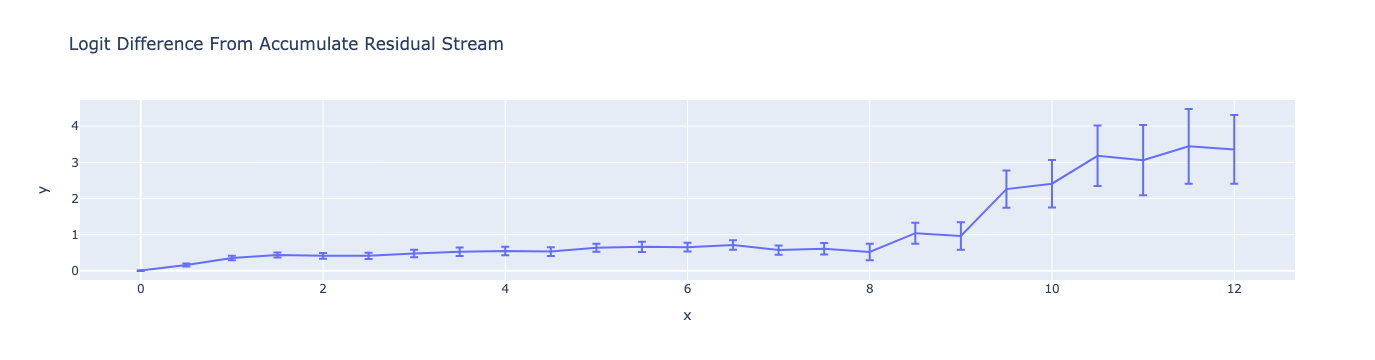

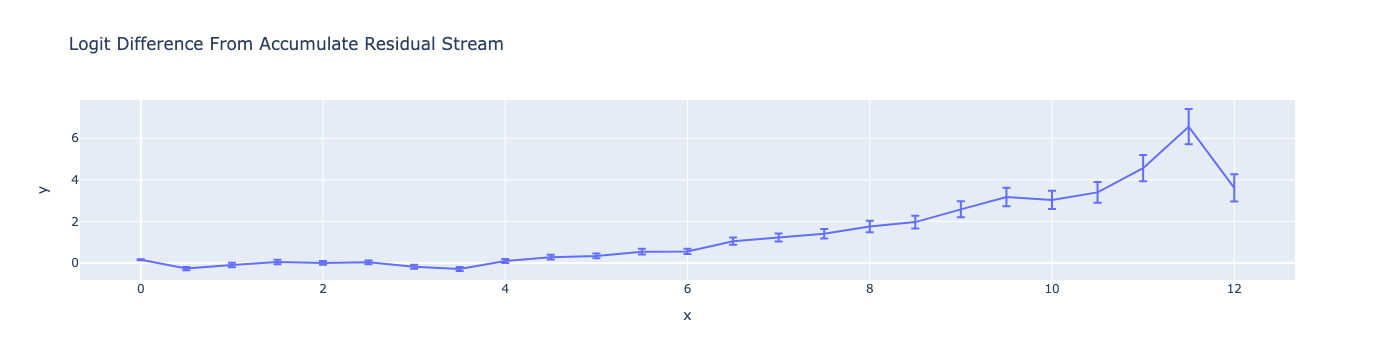

In [203]:
layer_logit_difference_accumulate_avg_all_facts(dataset, logit_diff_directions=forward_logit_diff_directions, forward=True)
layer_logit_difference_accumulate_avg_all_facts(dataset, logit_diff_directions=backward_logit_diff_directions, forward=False)



['Paris is the capital of']


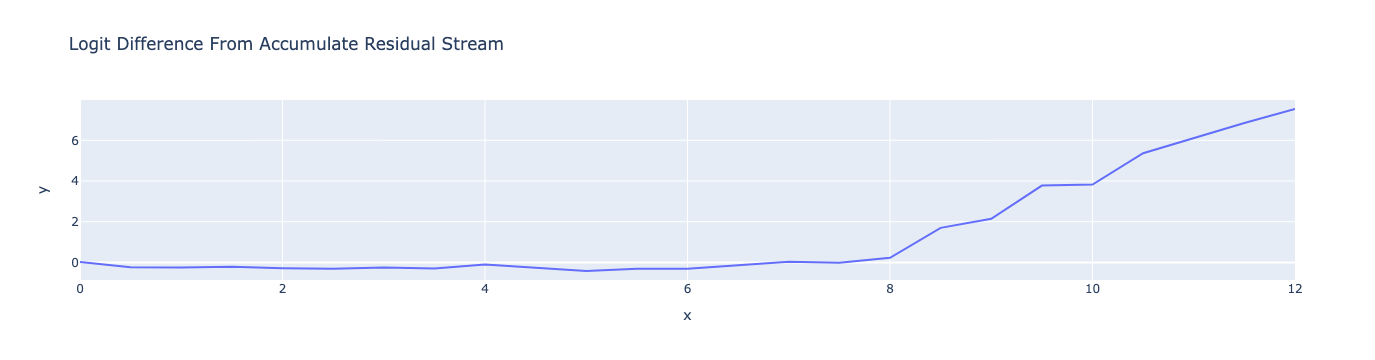

['The capital of France is']


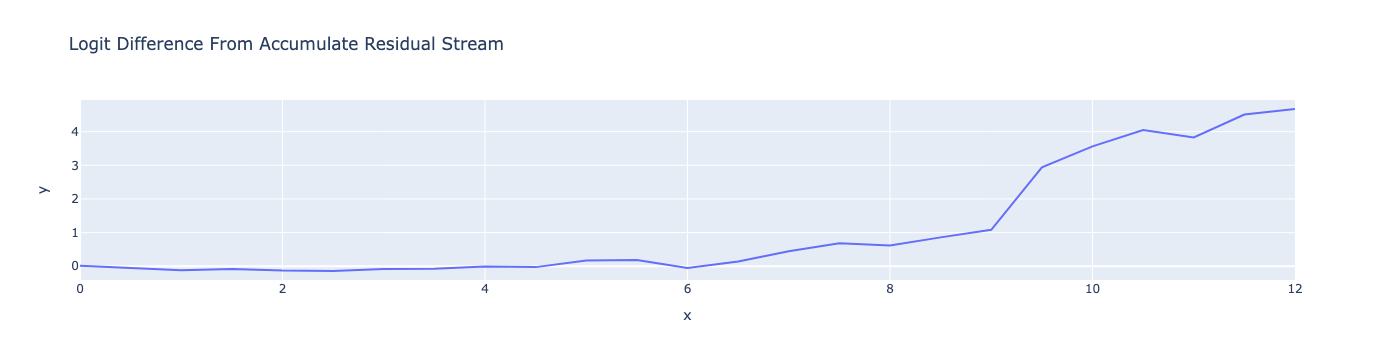

['Rome is the capital of']


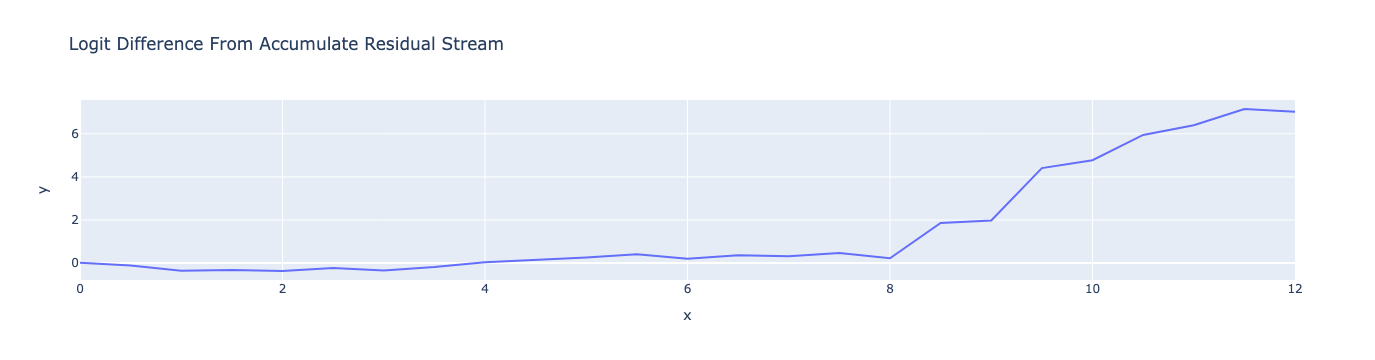

['The capital of Italy is']


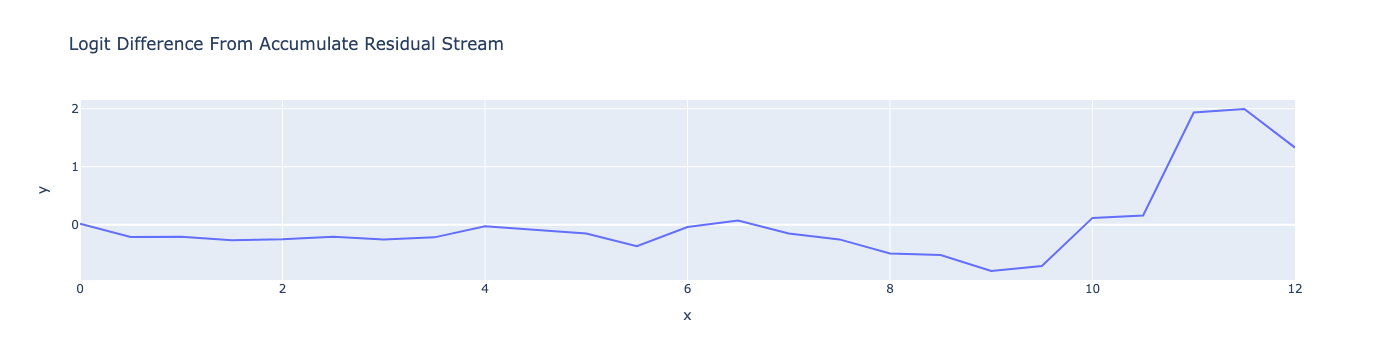

['Ottawa is the capital of']


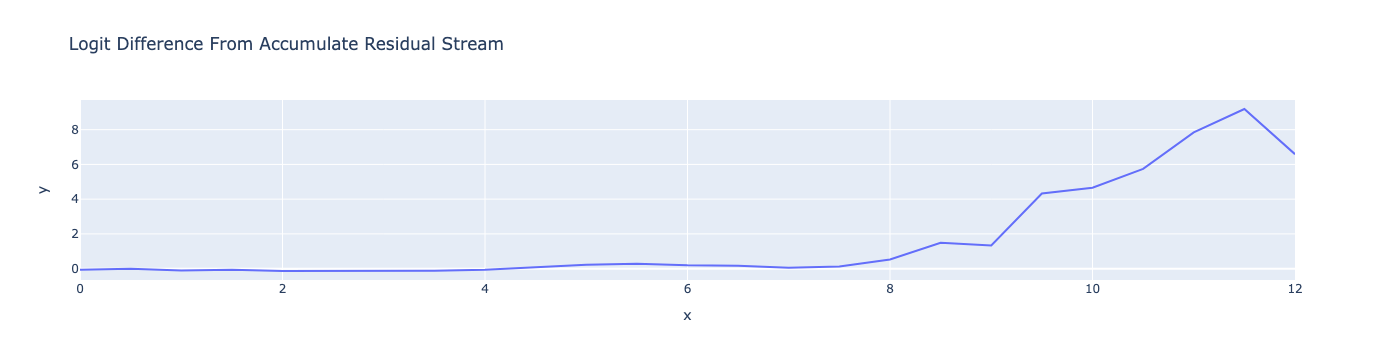

['The capital of Canada is']


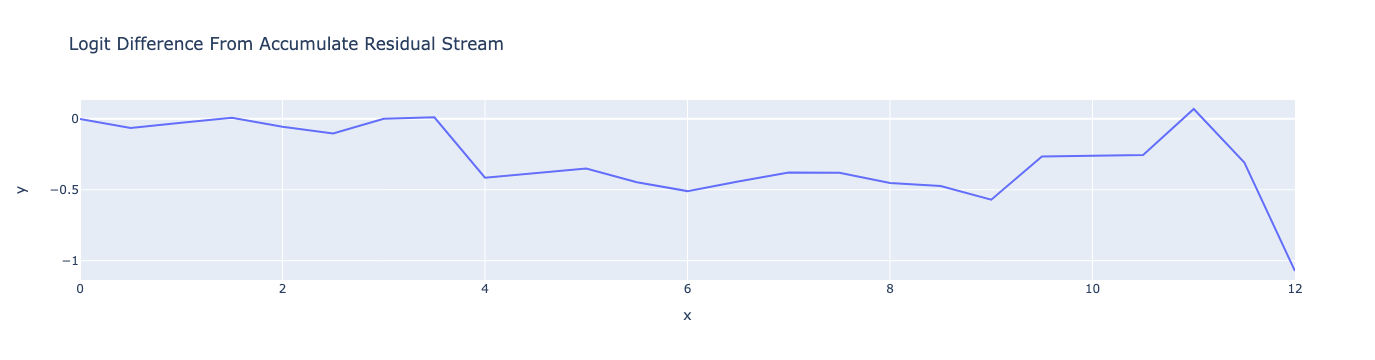

['Dolphins live in the']


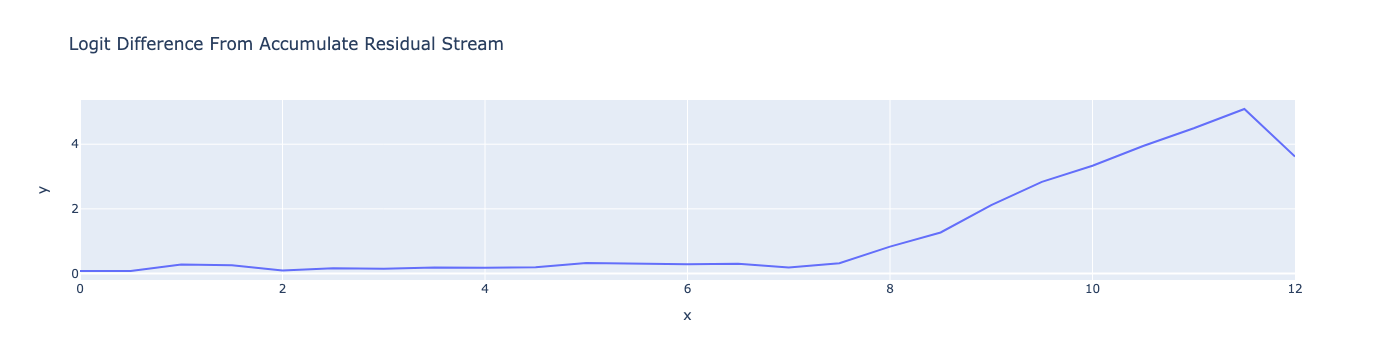

['The ocean is home to']


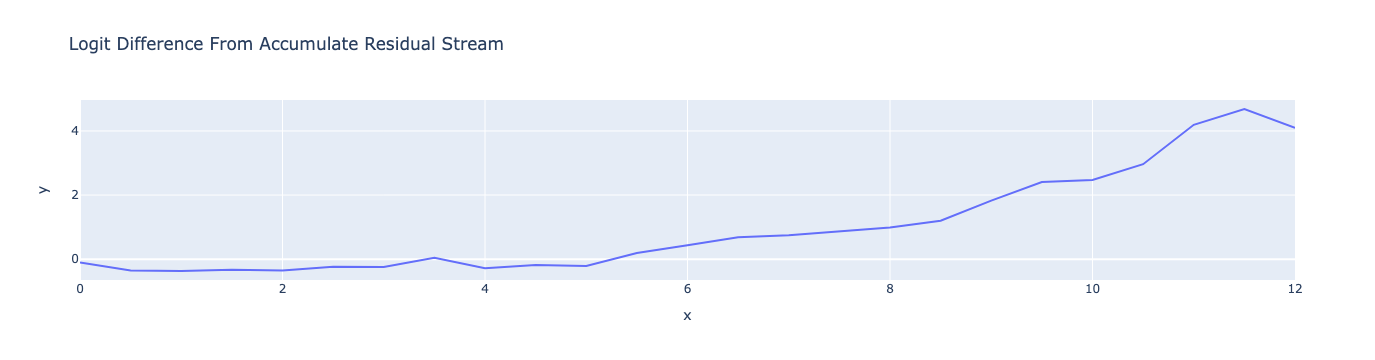

['Tigers live in the']


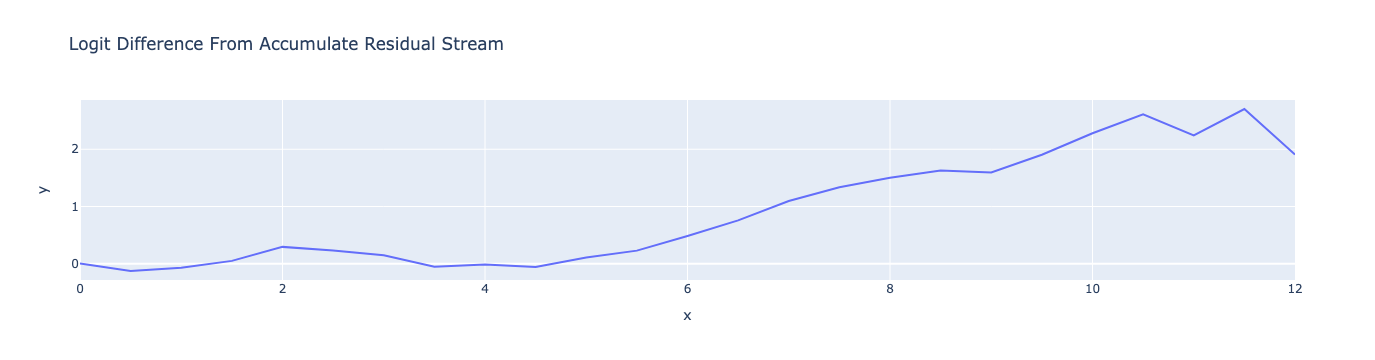

['The jungle is home to']


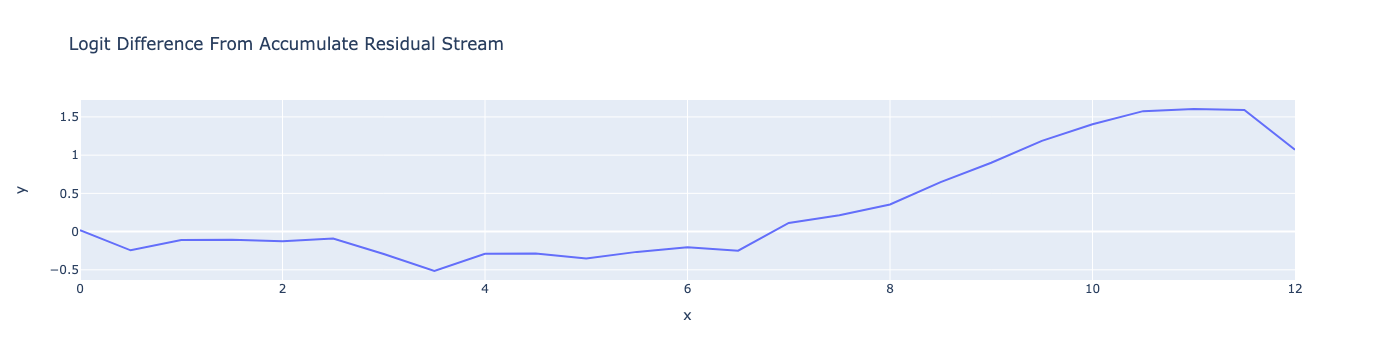

['Camels live in the']


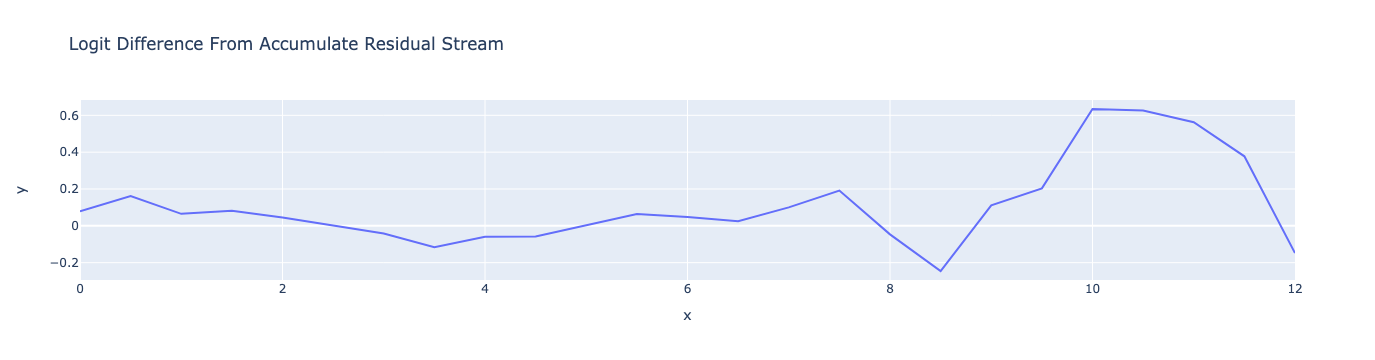

['The desert is home to']


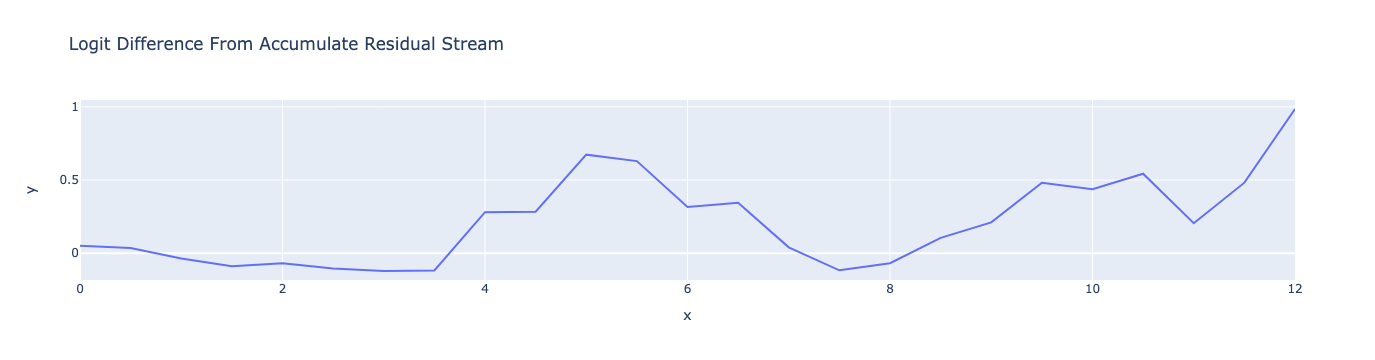

['Bill Gates is the founder of']


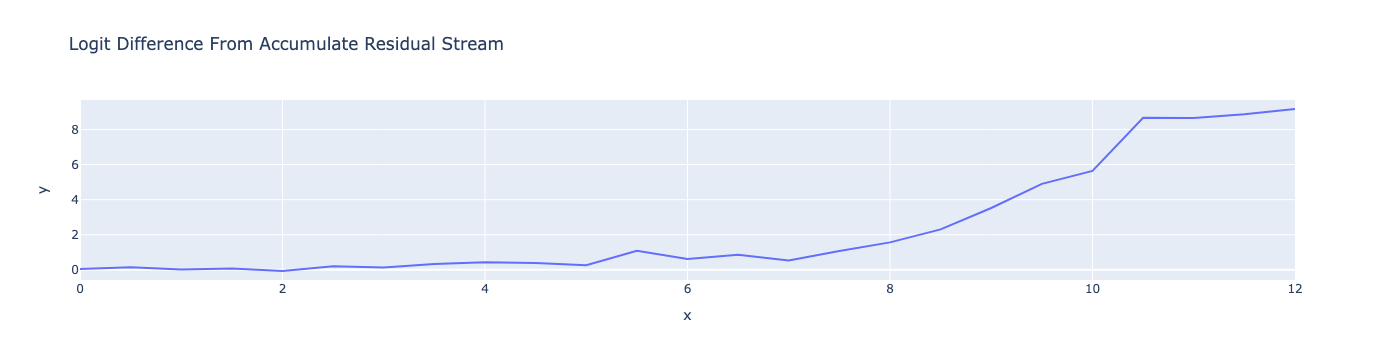

['Microsoft was founded by']


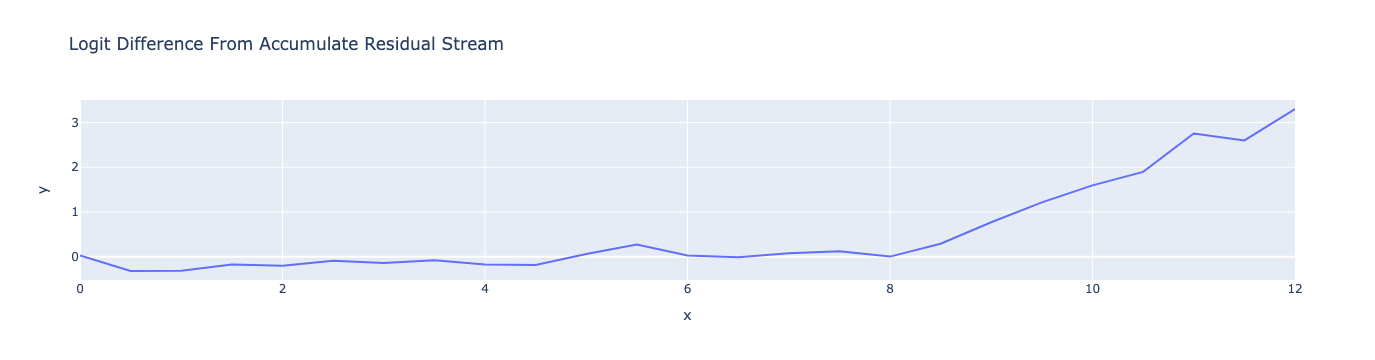

['The Nile is the longest river in']


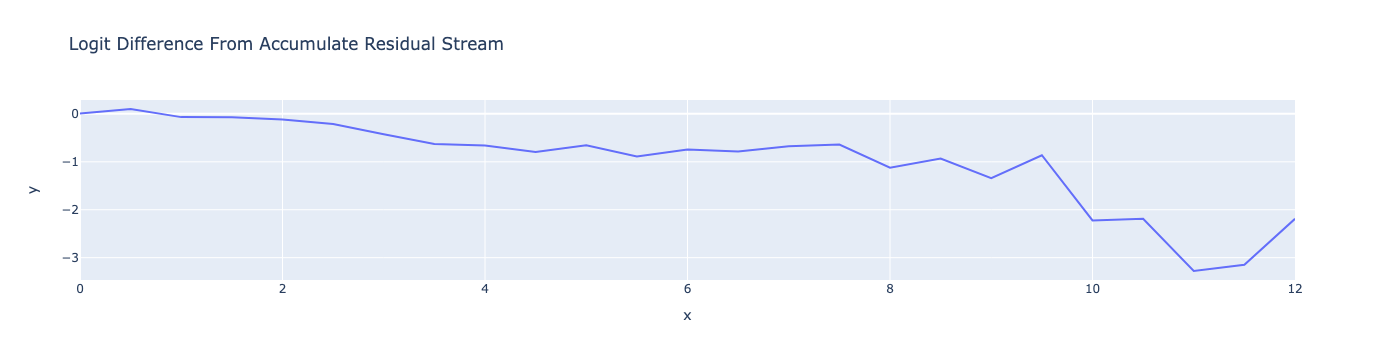

['The longest river in Africa is the']


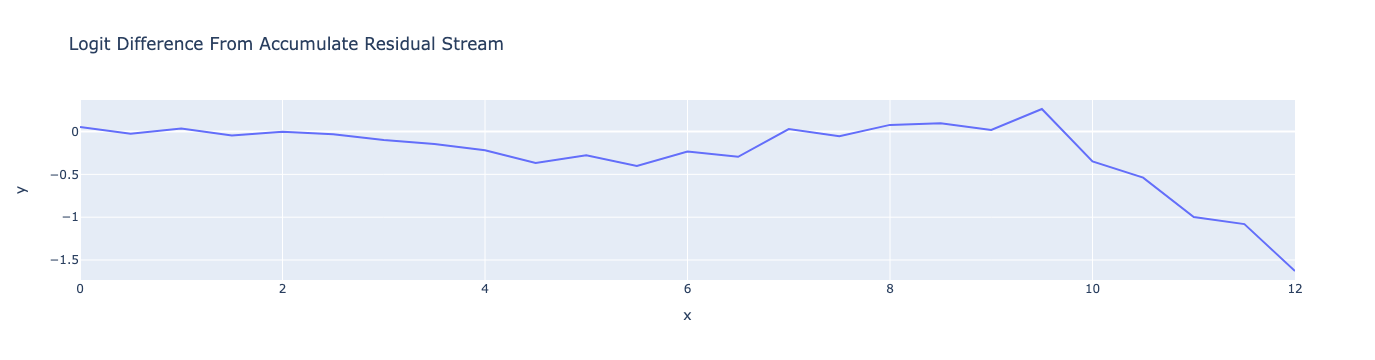

['The Yangtze is the longest river in']


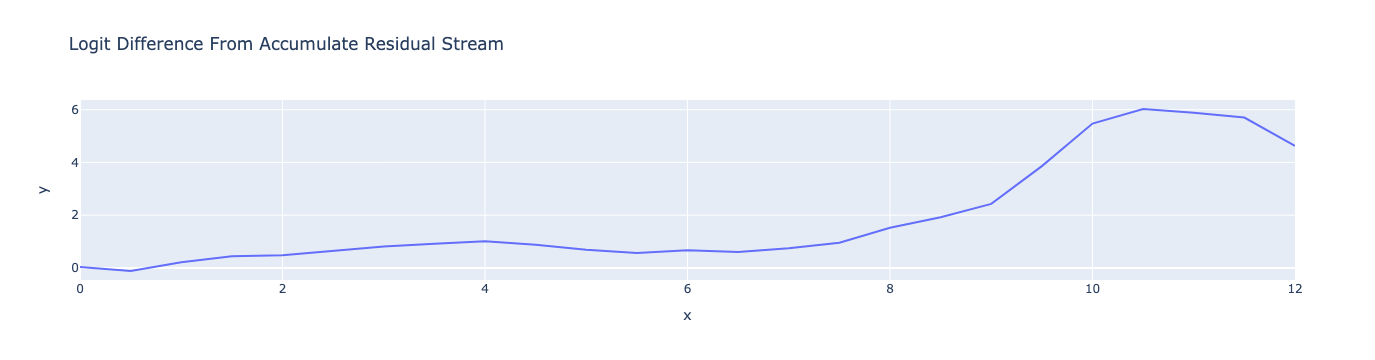

['The longest river in Asia is the']


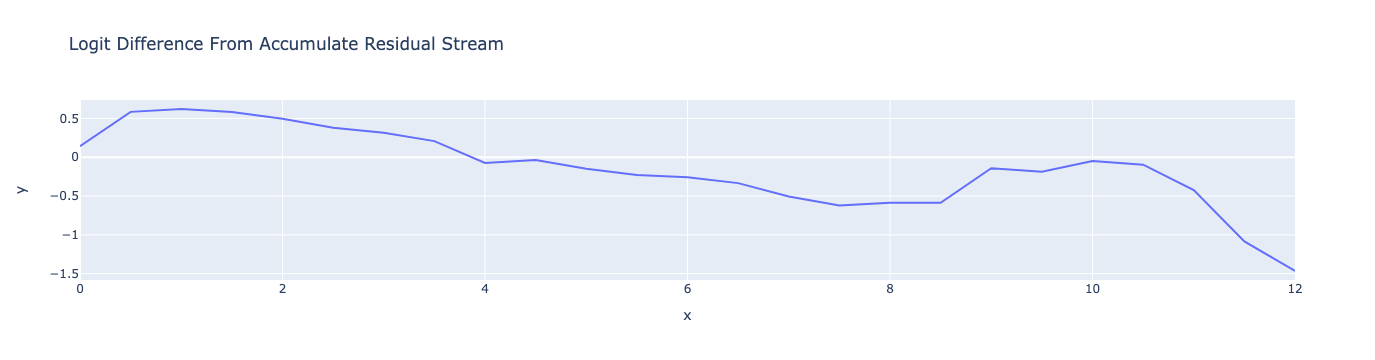

['English is the language spoken in']


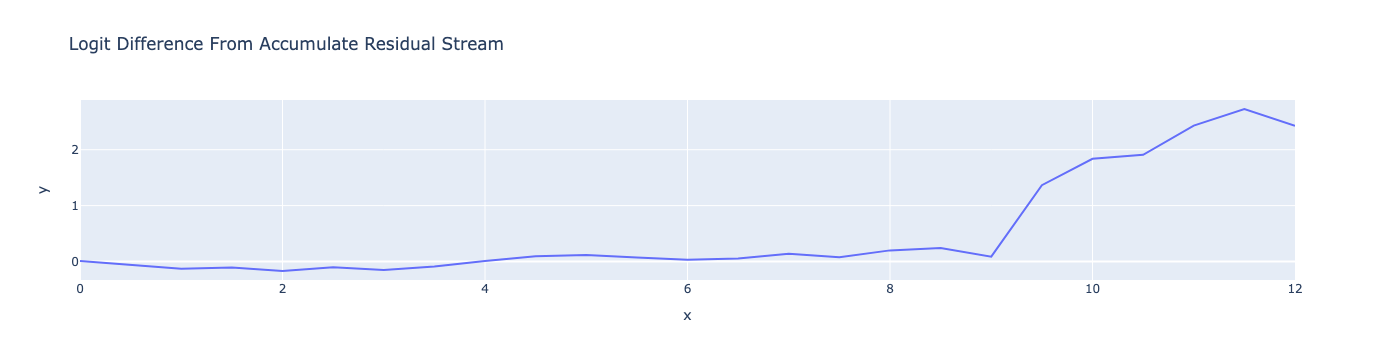

['People from England speak']


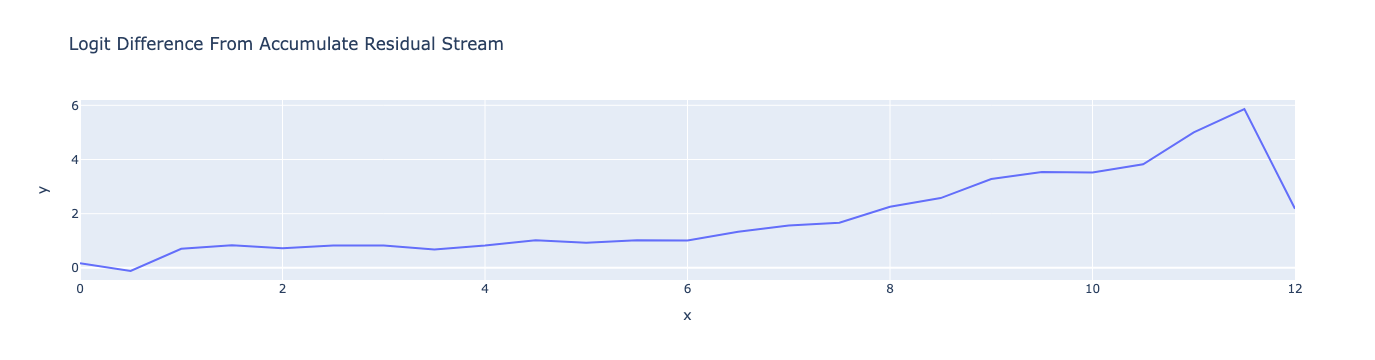

['French is the language spoken in']


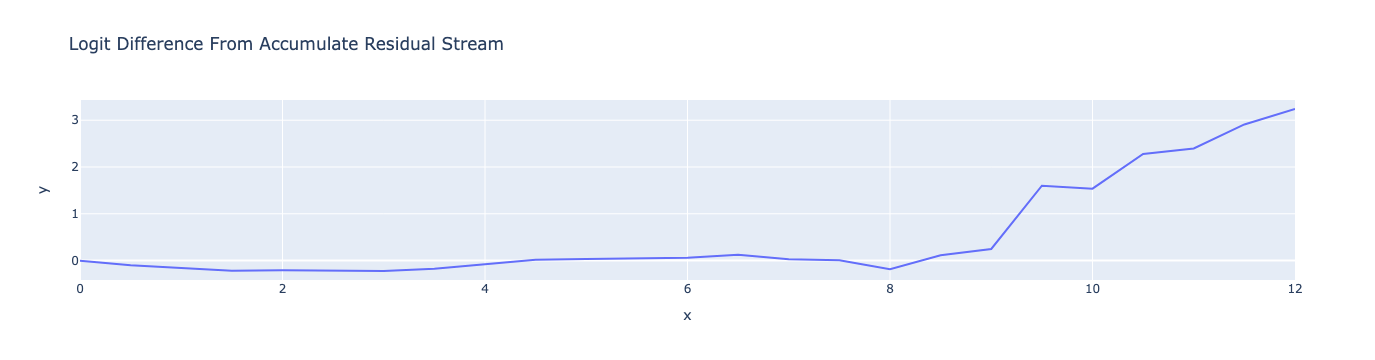

['People from France speak']


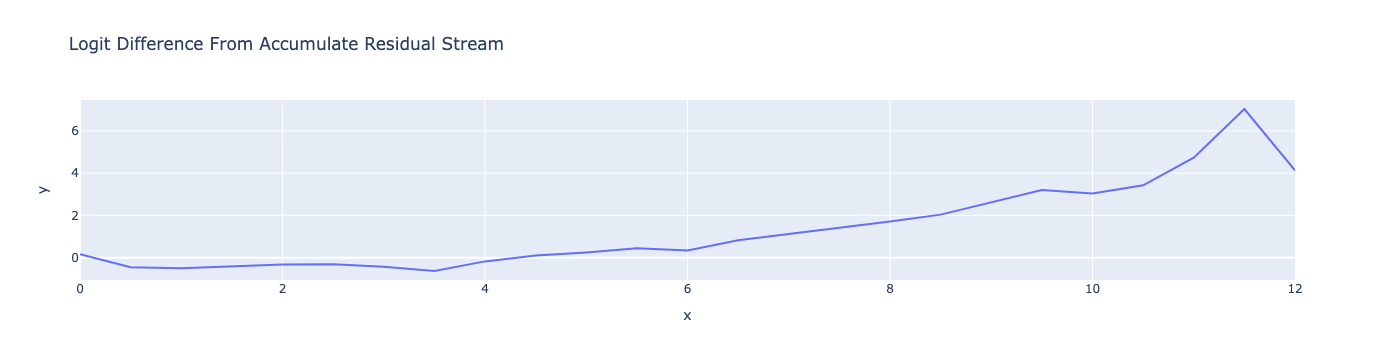

['German is the language spoken in']


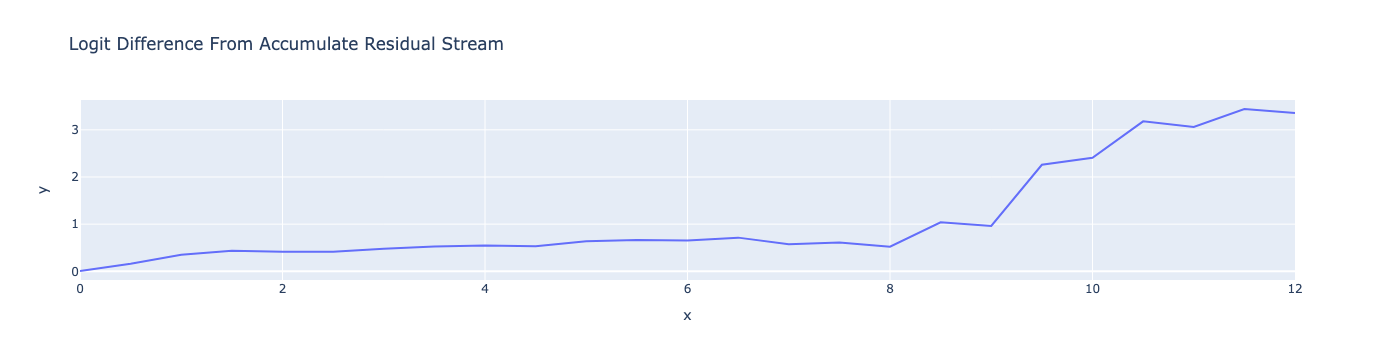

['People from Germany speak']


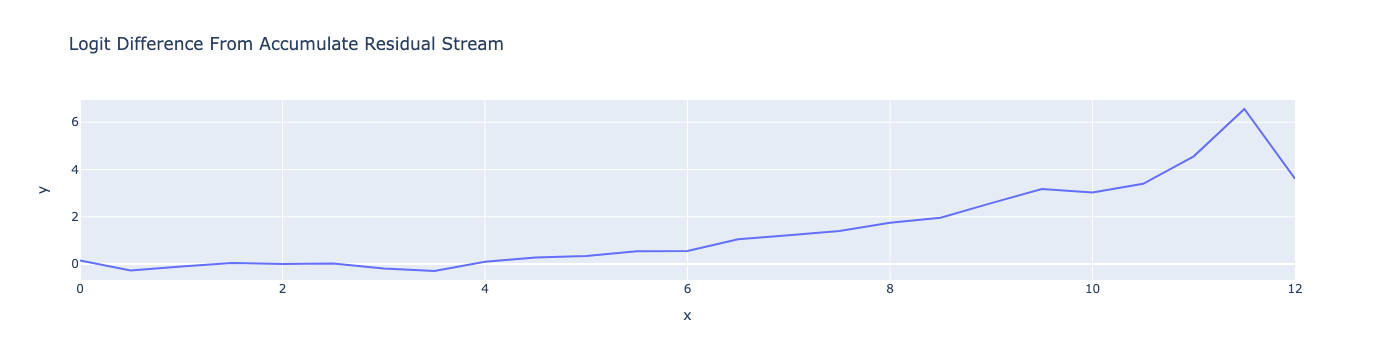

In [204]:
for sample in range(len(dataset)): 
    layer_logit_difference_accumulate_avg_all_facts(dataset, logit_diff_directions=forward_logit_diff_directions,  forward=True, sample_idx = [sample])
    layer_logit_difference_accumulate_avg_all_facts(dataset, logit_diff_directions=backward_logit_diff_directions,  forward=False, sample_idx = [sample])


    

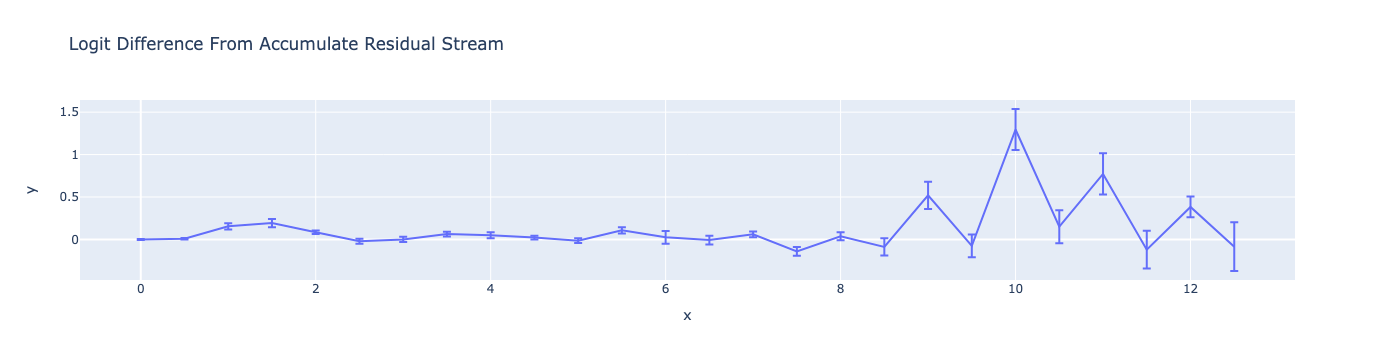

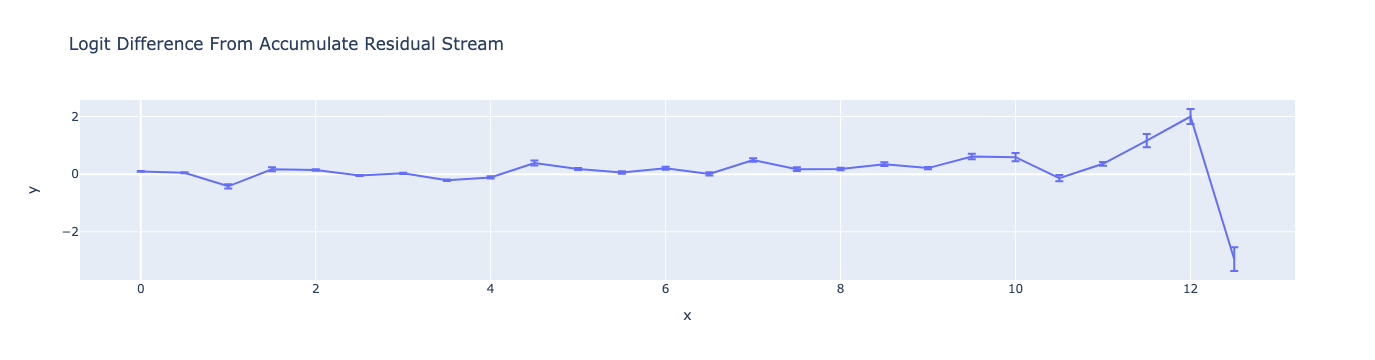

In [195]:
layer_logit_difference_accumulate_avg_all_facts(dataset, logit_diff_directions=forward_logit_diff_directions, direction="forward", decomposed=True)
layer_logit_difference_accumulate_avg_all_facts(dataset, logit_diff_directions=backward_logit_diff_directions, direction="backward", decomposed=True)



['Paris is the capital of']


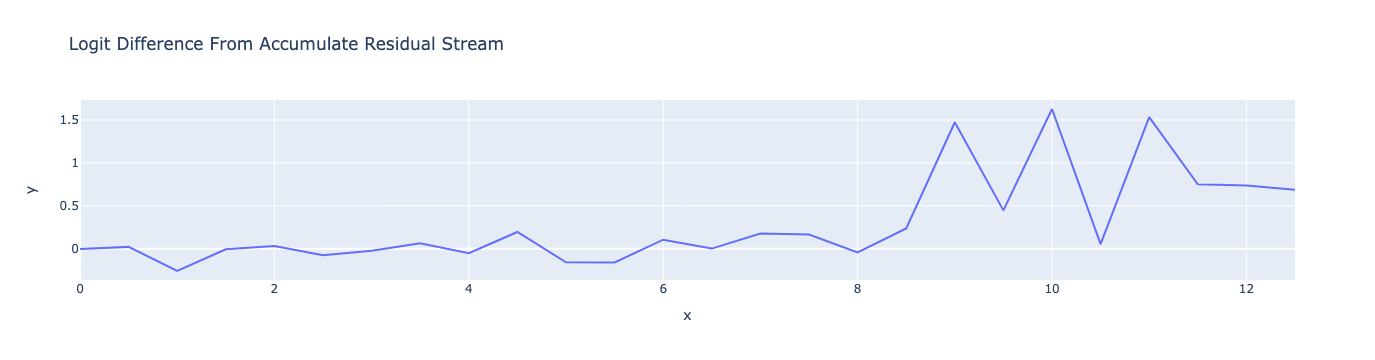

['The capital of France is']


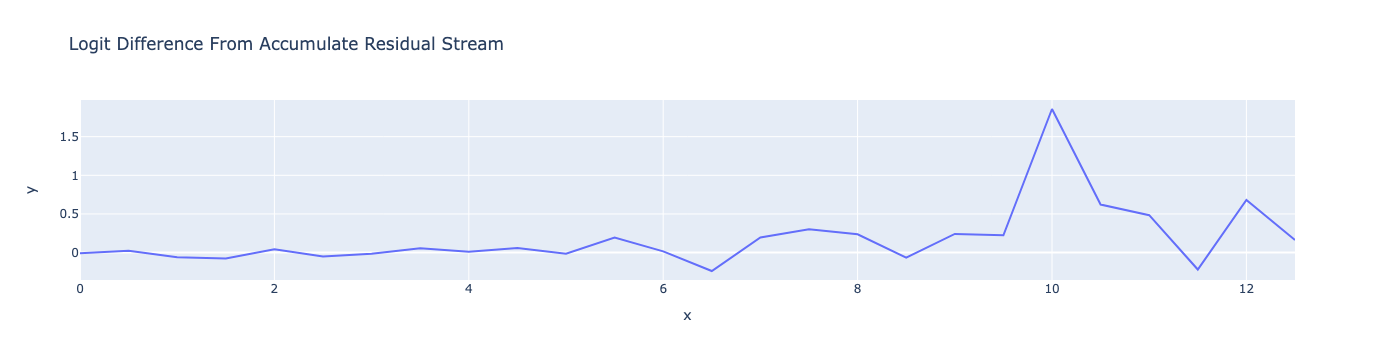

['Rome is the capital of']


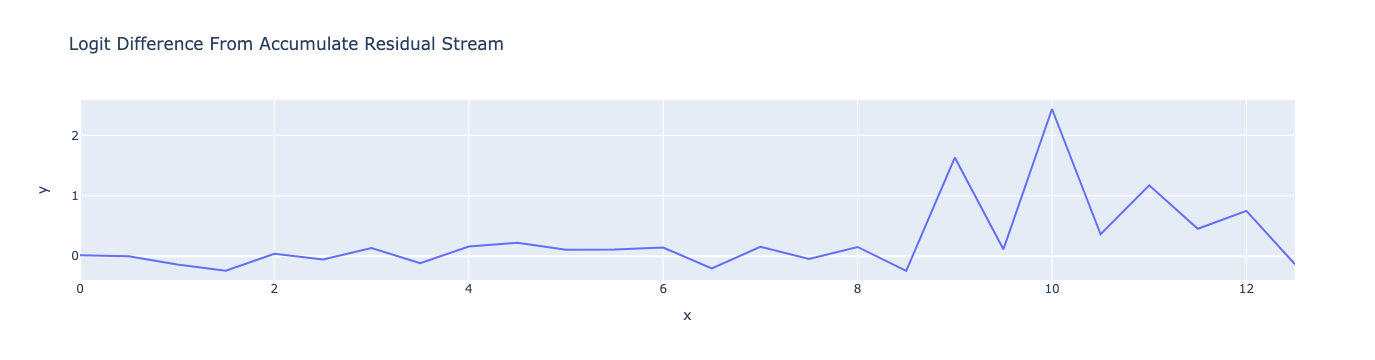

['The capital of Italy is']


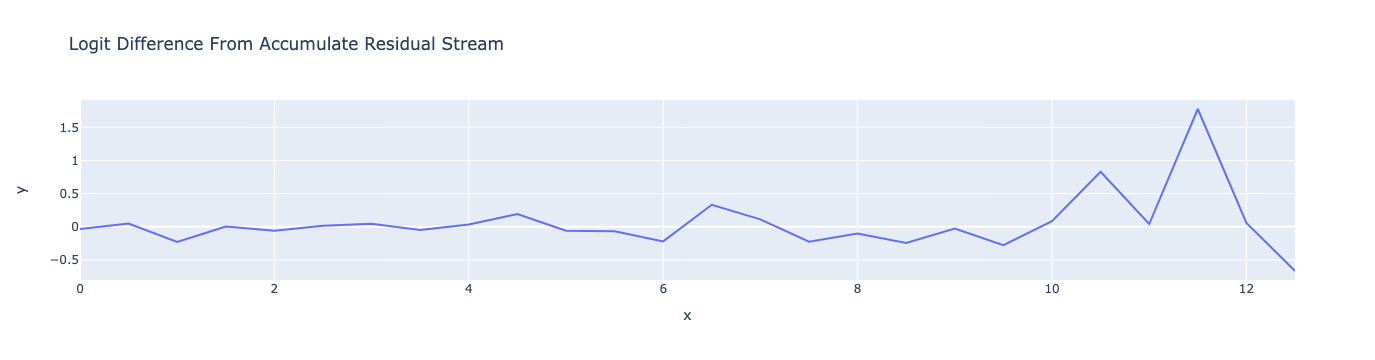

['Ottawa is the capital of']


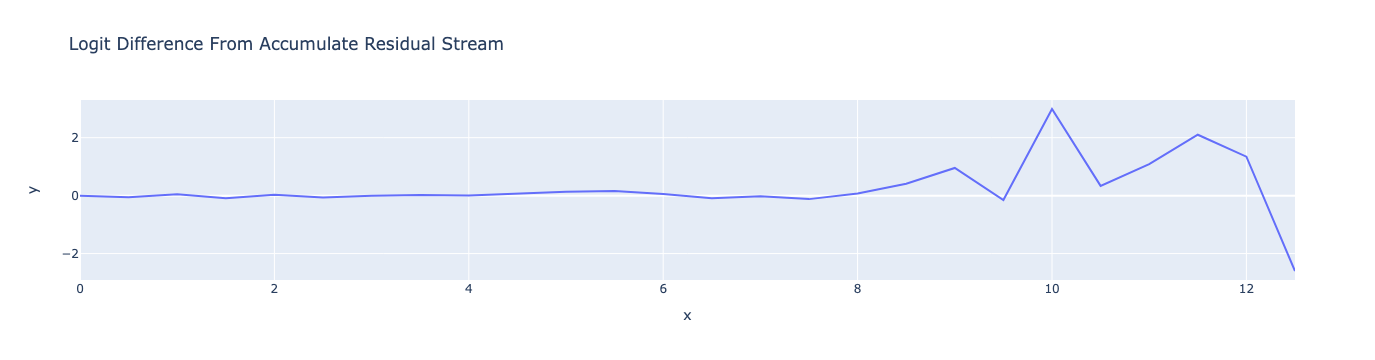

['The capital of Canada is']


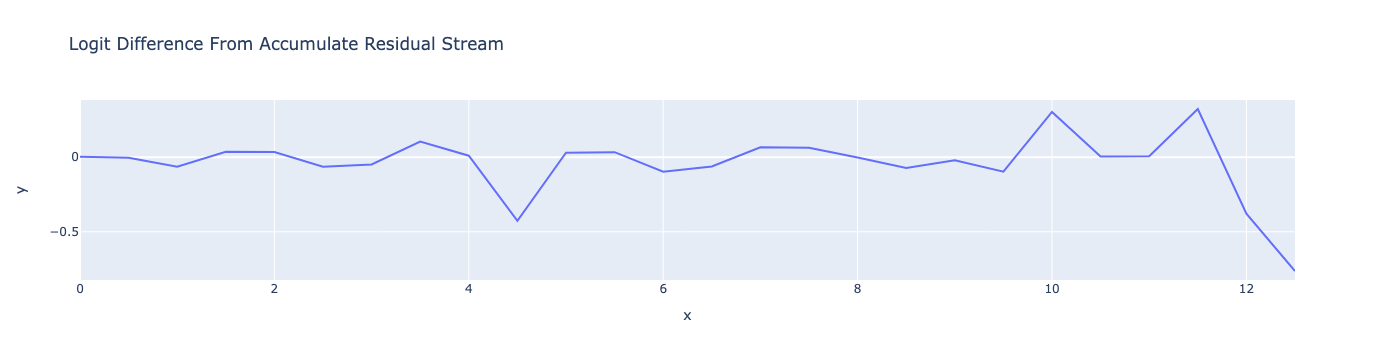

['Dolphins live in the']


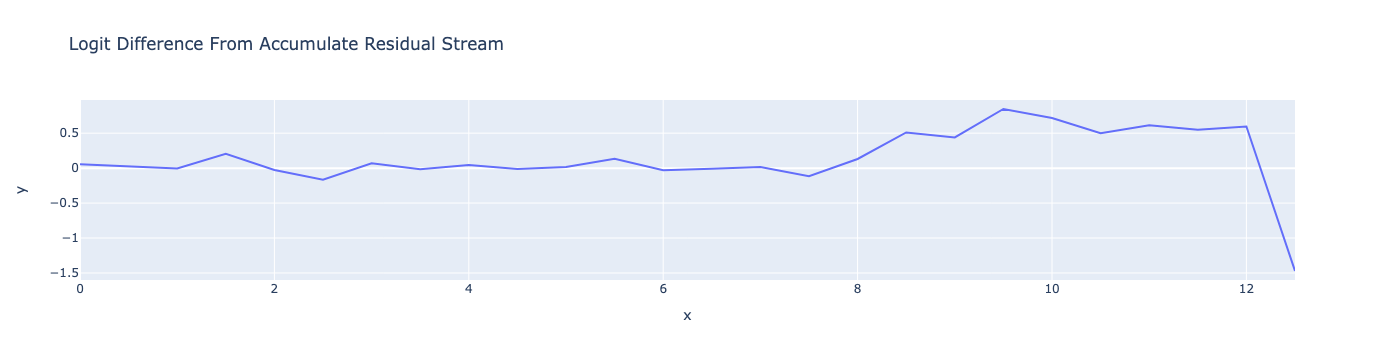

['The ocean is home to']


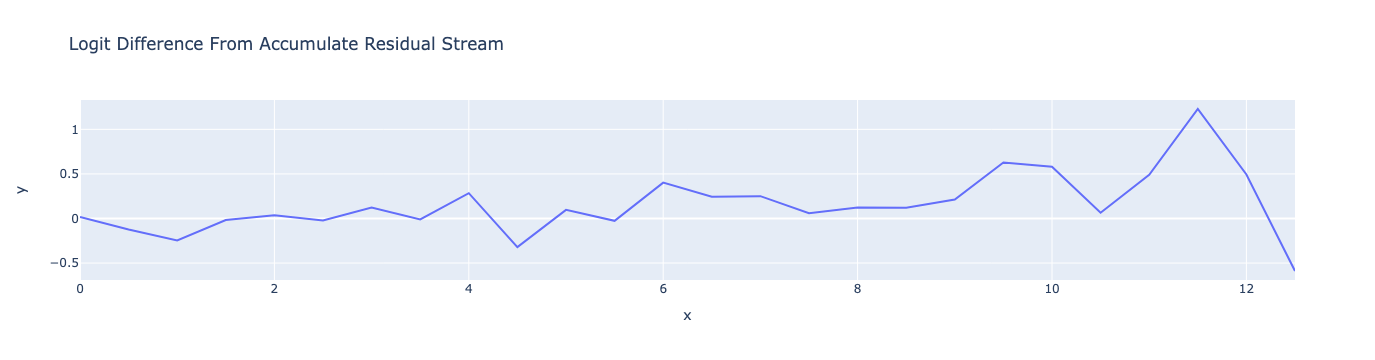

['Tigers live in the']


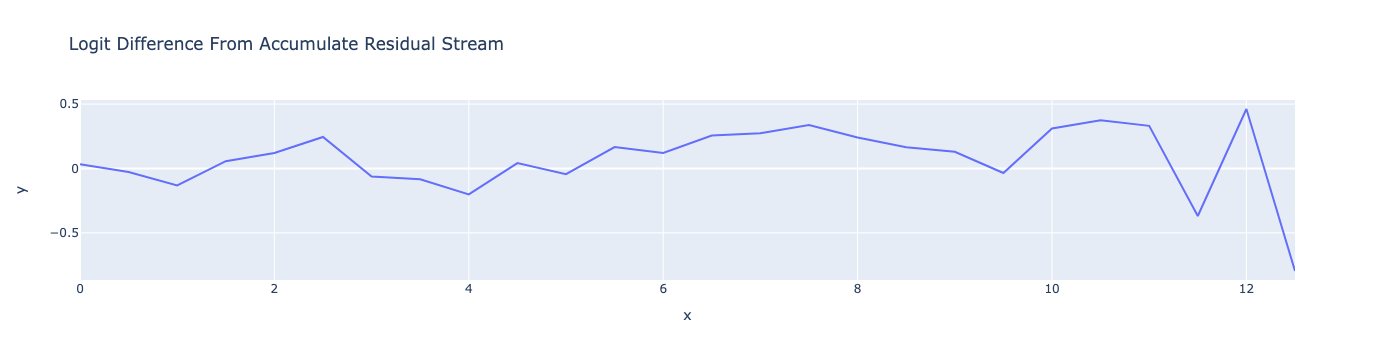

['The jungle is home to']


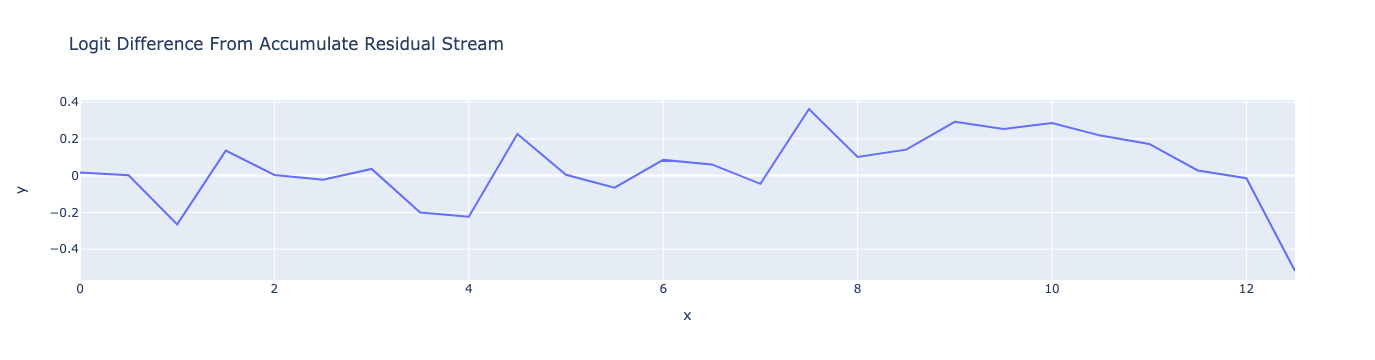

['Camels live in the']


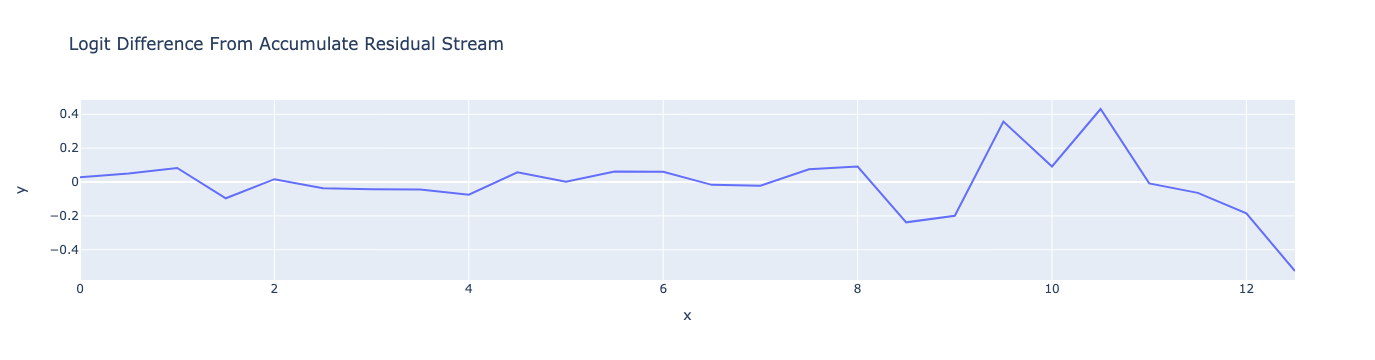

['The desert is home to']


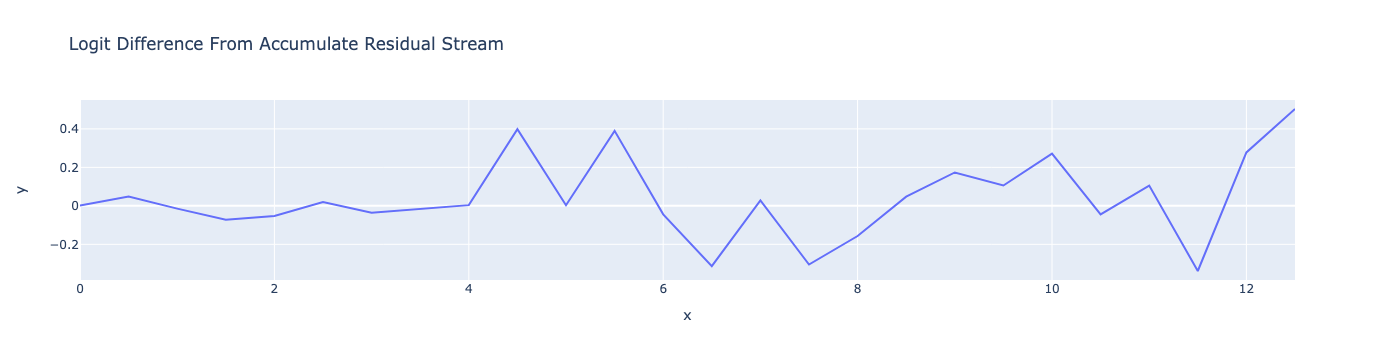

['Bill Gates is the founder of']


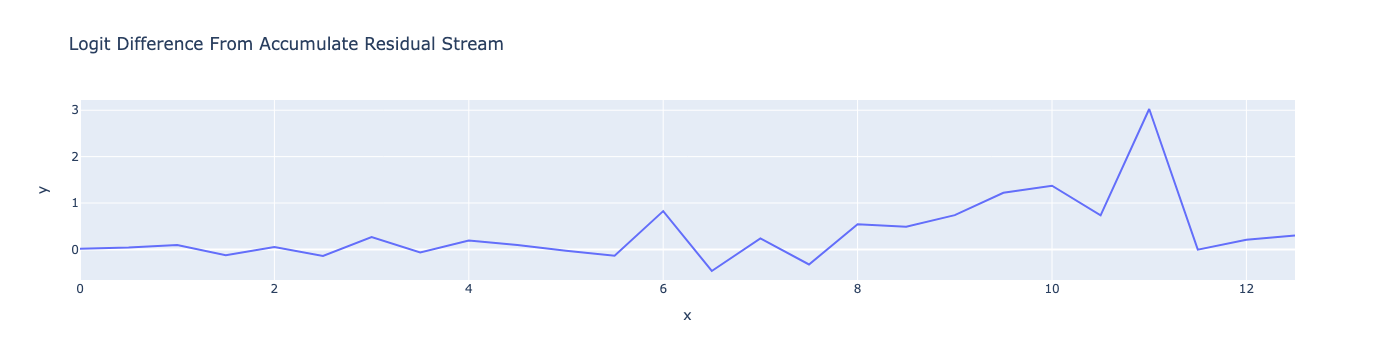

['Microsoft was founded by']


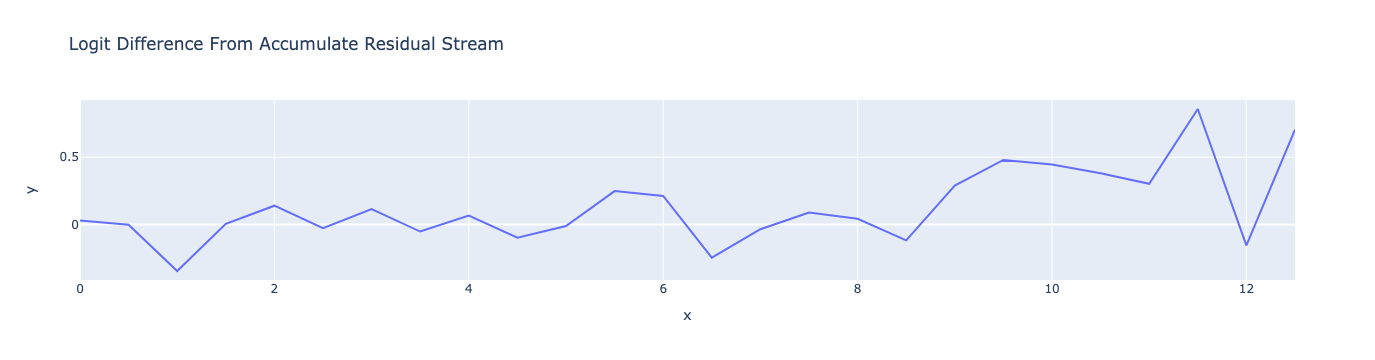

['The Nile is the longest river in']


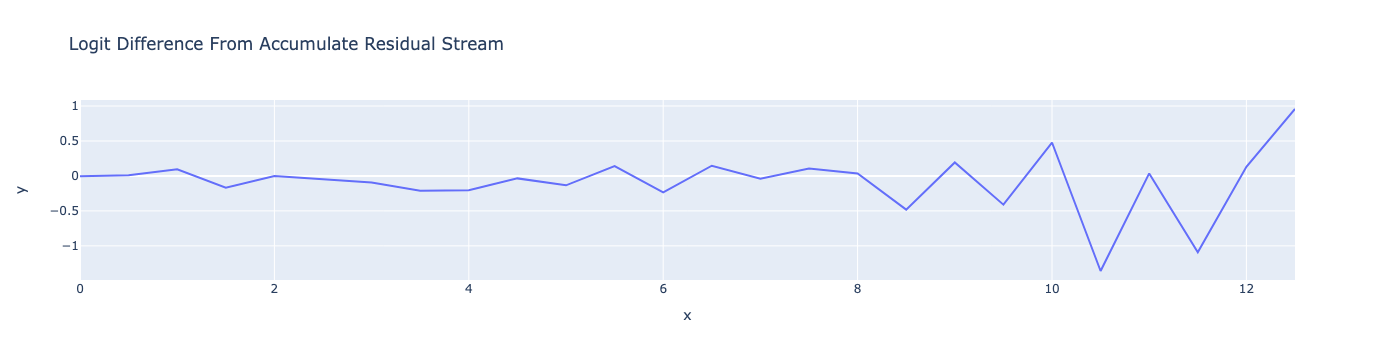

['The longest river in Africa is the']


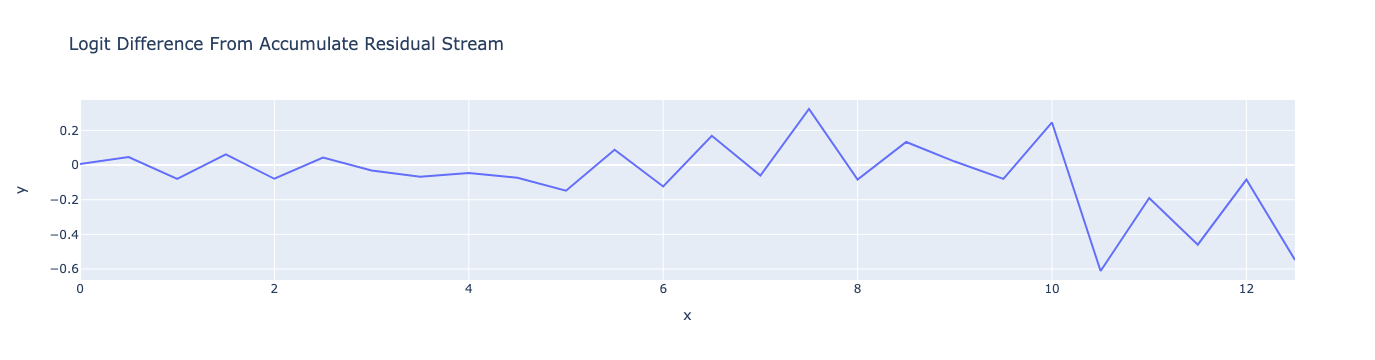

['The Yangtze is the longest river in']


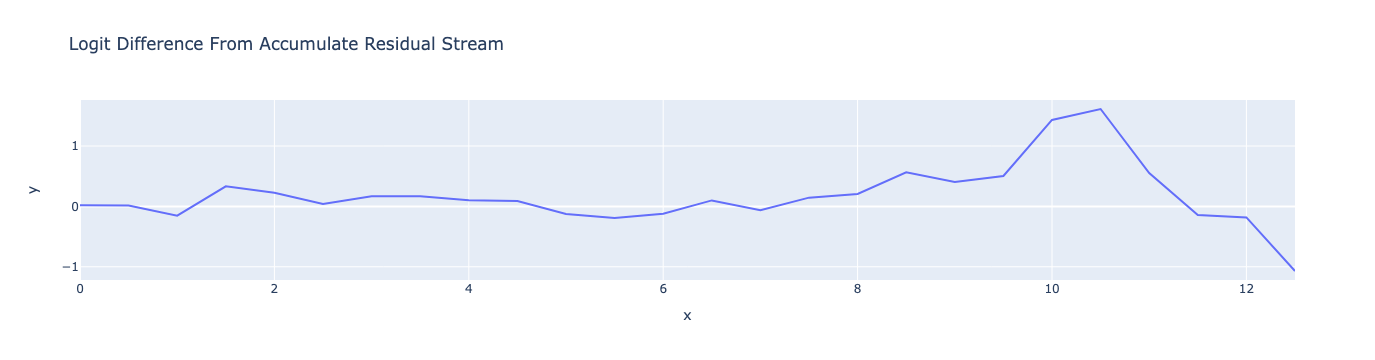

['The longest river in Asia is the']


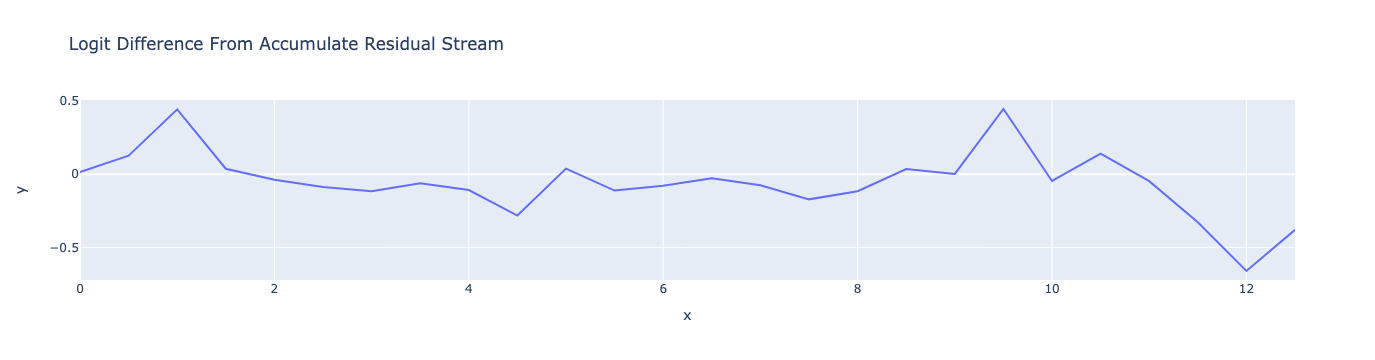

['English is the language spoken in']


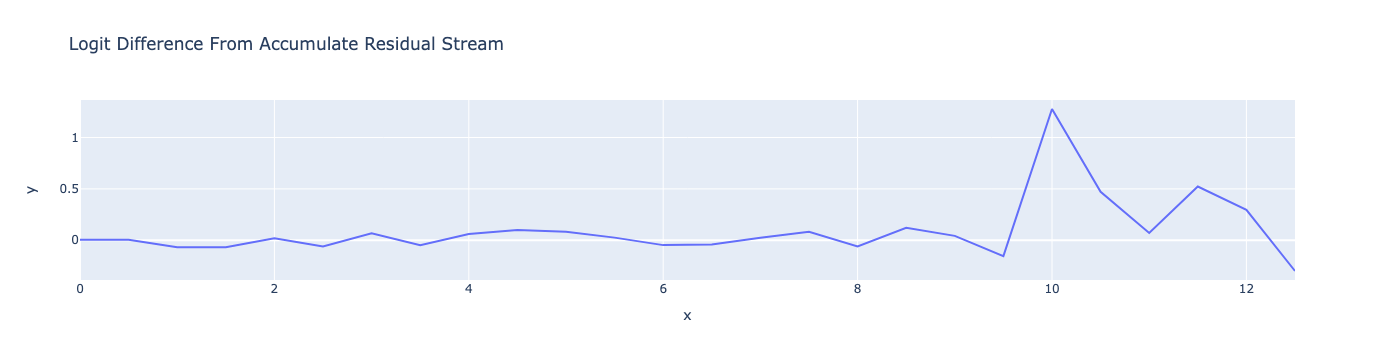

['People from England speak']


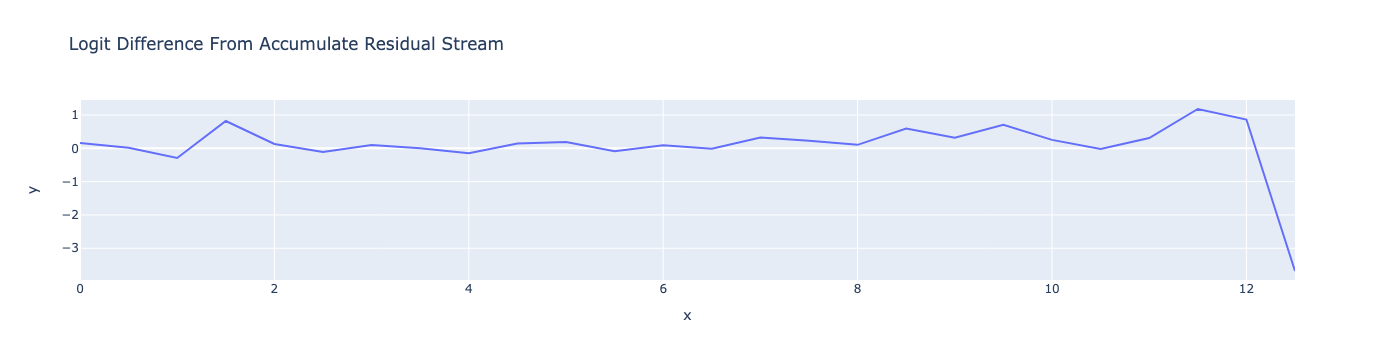

['French is the language spoken in']


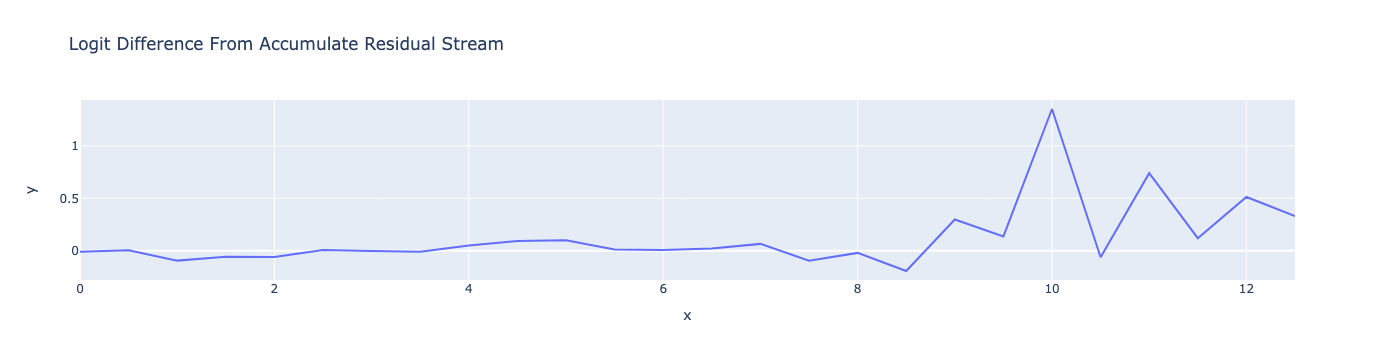

['People from France speak']


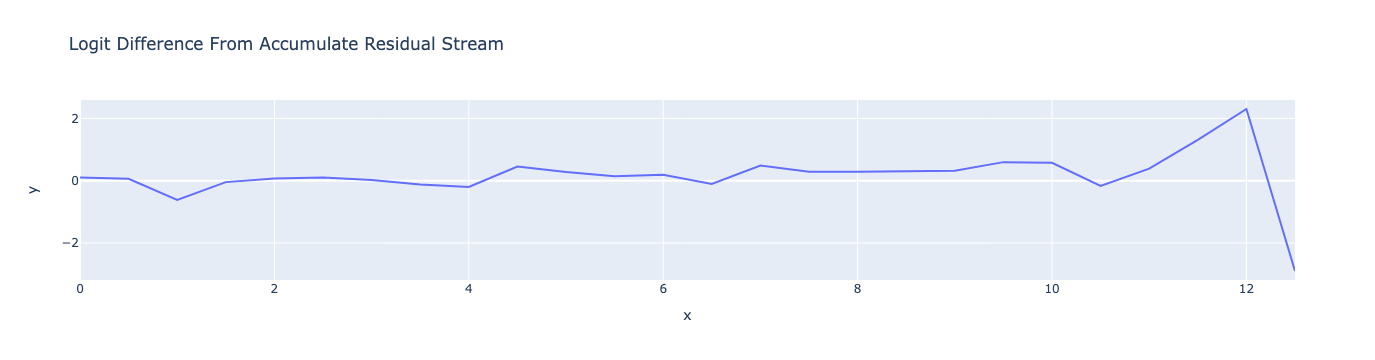

['German is the language spoken in']


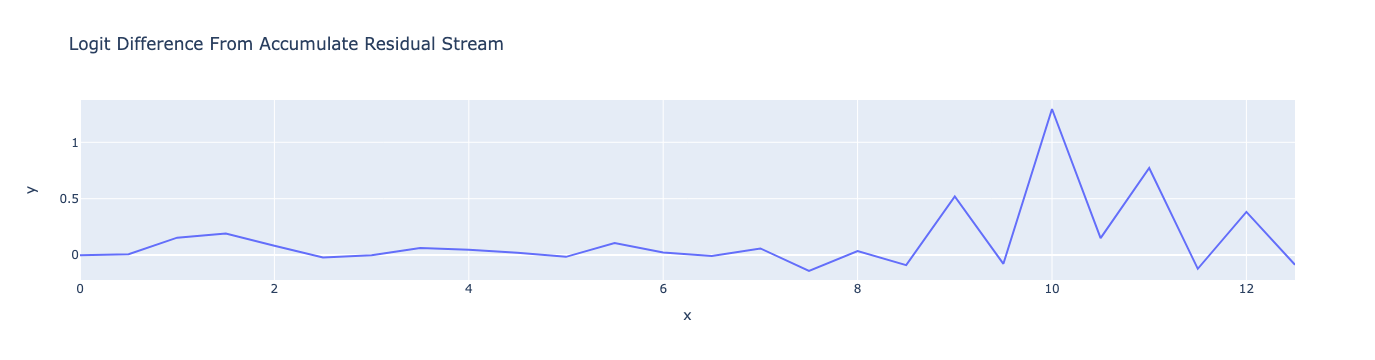

['People from Germany speak']


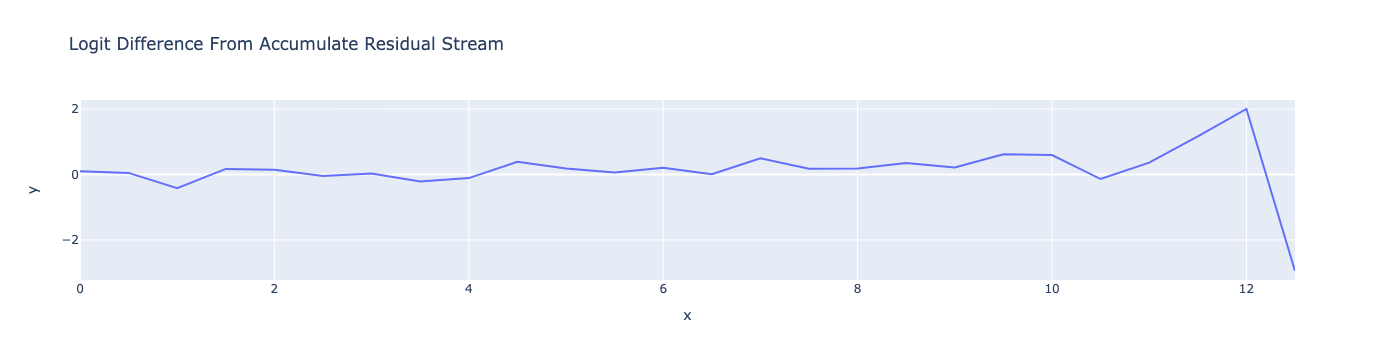

In [205]:
for sample in range(len(dataset)): 
    layer_logit_difference_accumulate_avg_all_facts(dataset, logit_diff_directions=forward_logit_diff_directions,  forward=True, sample_idx = [sample], decomposed=True)
    layer_logit_difference_accumulate_avg_all_facts(dataset, logit_diff_directions=backward_logit_diff_directions,  forward=False, sample_idx = [sample], decomposed=True)


    

In [237]:
def head_logit_attribution(dataset, logit_diff_directions, forward=False, sample_idx=None ): 
    
    if sample_idx is not None: 
        dataset = [d for i,d in enumerate(dataset) if i in sample_idx]
        logit_diff_directions = [d for i,d in enumerate(logit_diff_directions) if i in sample_idx]
        
    if forward: 
        subject = "subject_1"
        obj = "object_1"
        sentence = "sentence_1"
    else:
        subject = "subject_2"
        obj = "object_2"
        sentence = "sentence_2"
        
    per_head_logit_diffs_list = []
    prompts = []
    for i, sample in enumerate(dataset): 
        prompt = sample[sentence].format(subject=sample[subject], obj="")[:-1]
        prompts.append(prompt)
        prompt = model.to_tokens(prompt, prepend_bos=True)
        
        logits, cache = model.run_with_cache(prompt)
    
        per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
                
        logit_diff_dir = logit_diff_directions[i]
        per_head_residual = per_head_residual.repeat(1,logit_diff_dir.shape[0],1)
        per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache, logit_diff_dir)
        
        per_head_logit_diffs = einops.rearrange(per_head_logit_diffs, "(layer head_index) -> layer head_index", layer=model.cfg.n_layers, head_index=model.cfg.n_heads)
        per_head_logit_diffs_list.append(per_head_logit_diffs)
        
    per_head_logit_diffs = torch.stack(per_head_logit_diffs_list)
    per_head_logit_diffs = torch.mean(per_head_logit_diffs, axis=0)
    
    if sample_idx is not None: 
        print(prompts)
        
    imshow(per_head_logit_diffs, labels={"x":"Head", "y":"Layer"}, title="Logit Difference From Each Head")


Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now


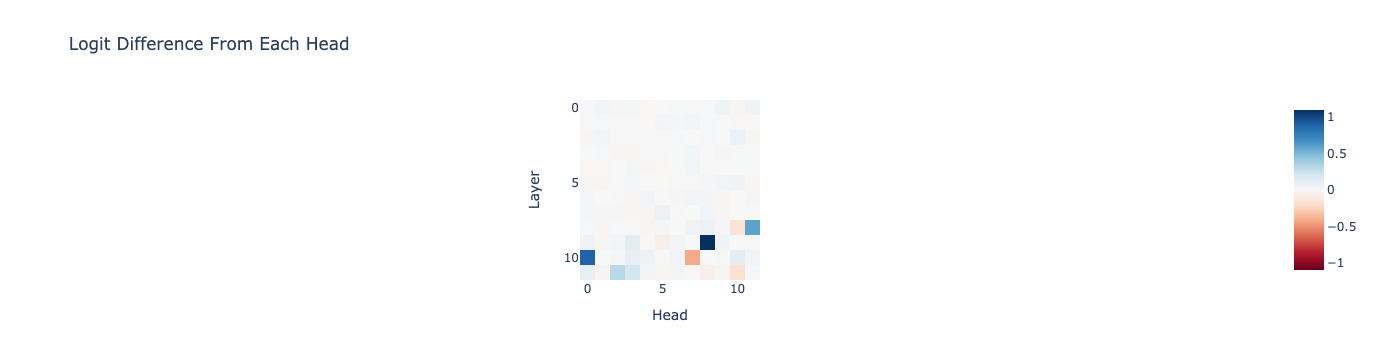

Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now


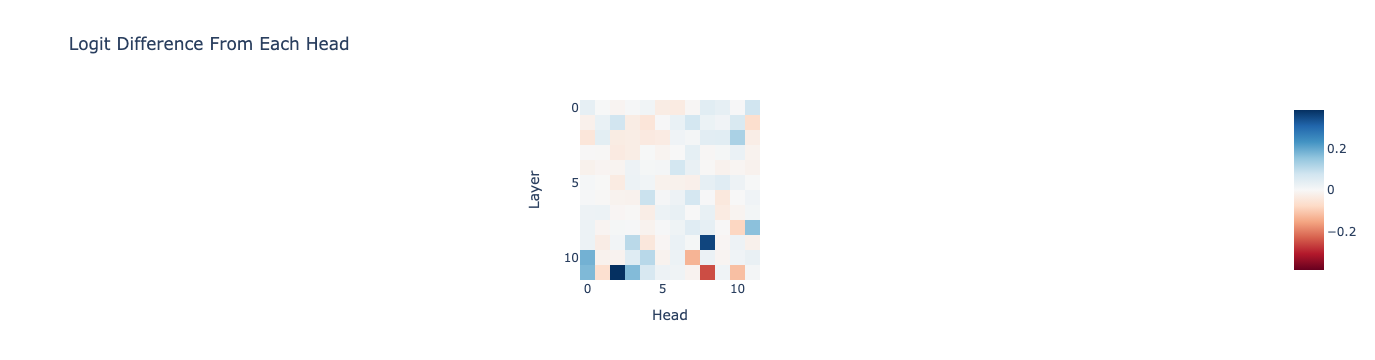

In [238]:
head_logit_attribution(dataset, forward_logit_diff_directions, forward=True)
head_logit_attribution(dataset, backward_logit_diff_directions, forward=False)

Tried to stack head results when they weren't cached. Computing head results now
['Paris is the capital of']


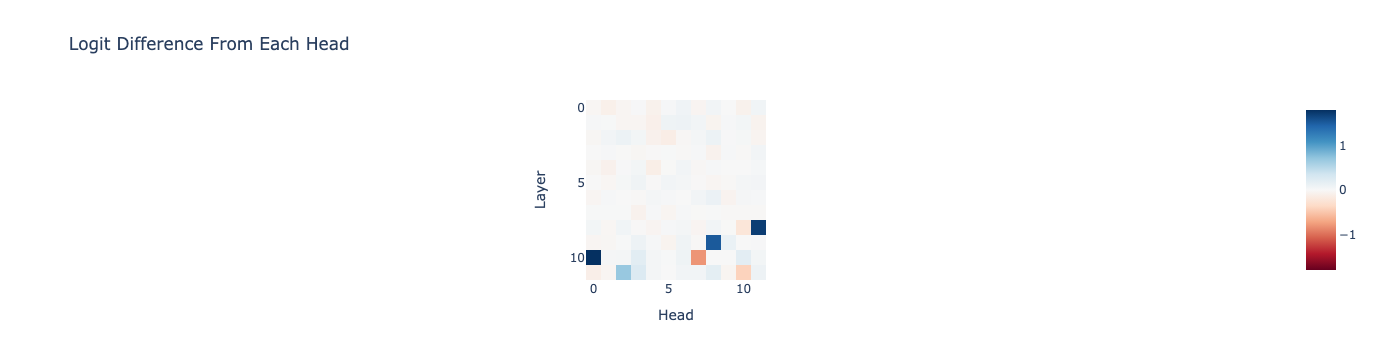

Tried to stack head results when they weren't cached. Computing head results now
['The capital of France is']


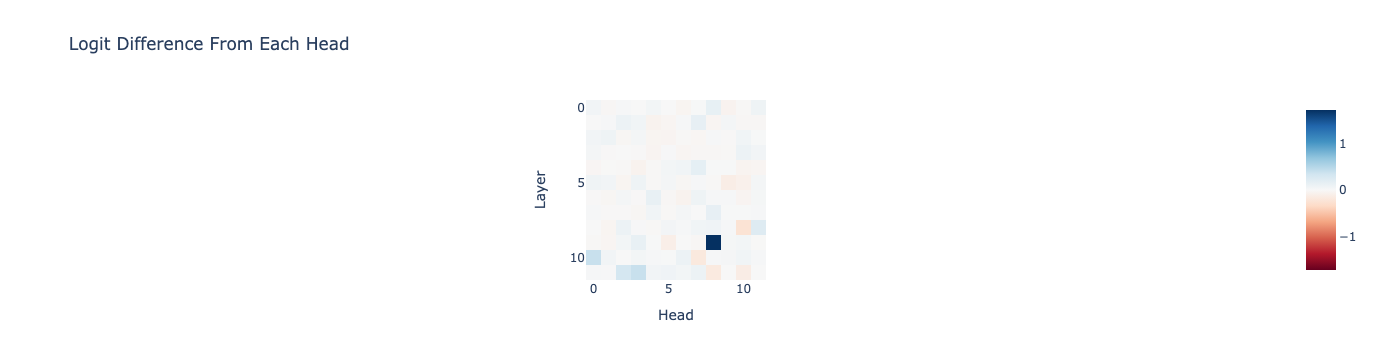

Tried to stack head results when they weren't cached. Computing head results now
['Rome is the capital of']


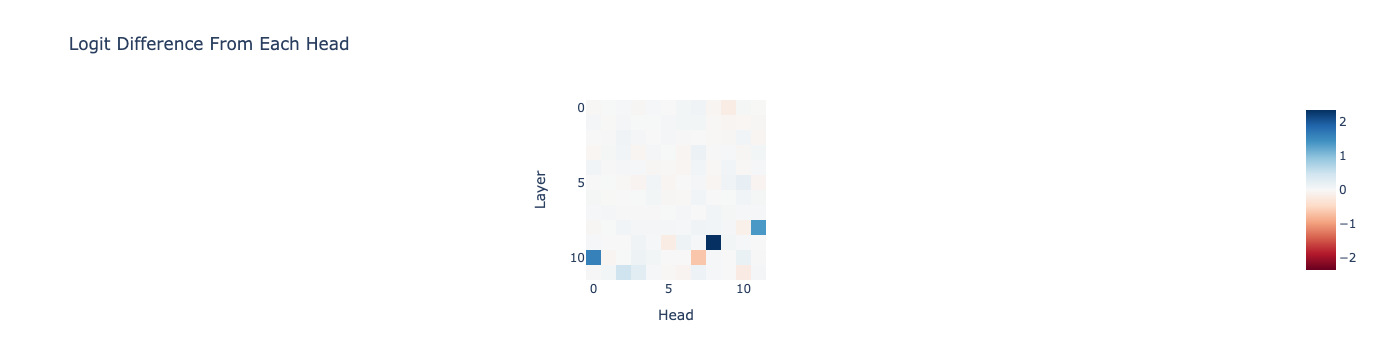

Tried to stack head results when they weren't cached. Computing head results now
['The capital of Italy is']


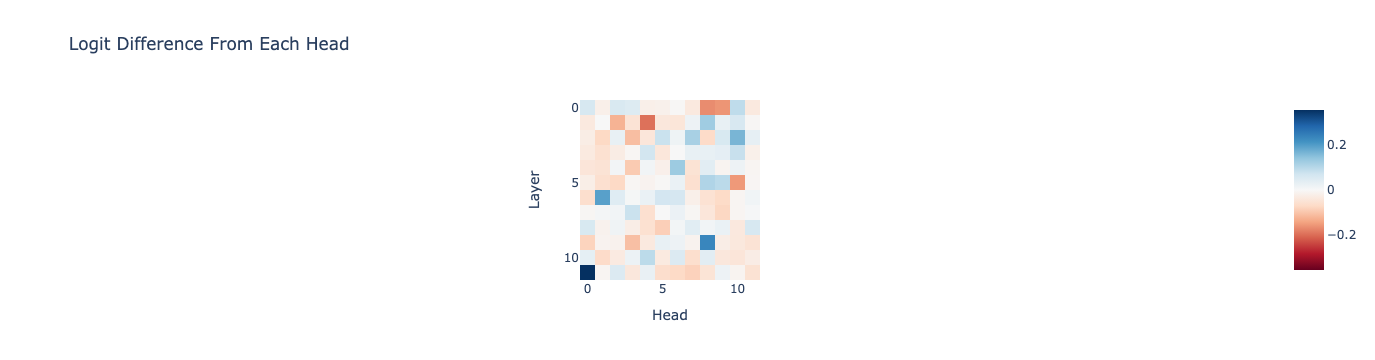

Tried to stack head results when they weren't cached. Computing head results now
['Ottawa is the capital of']


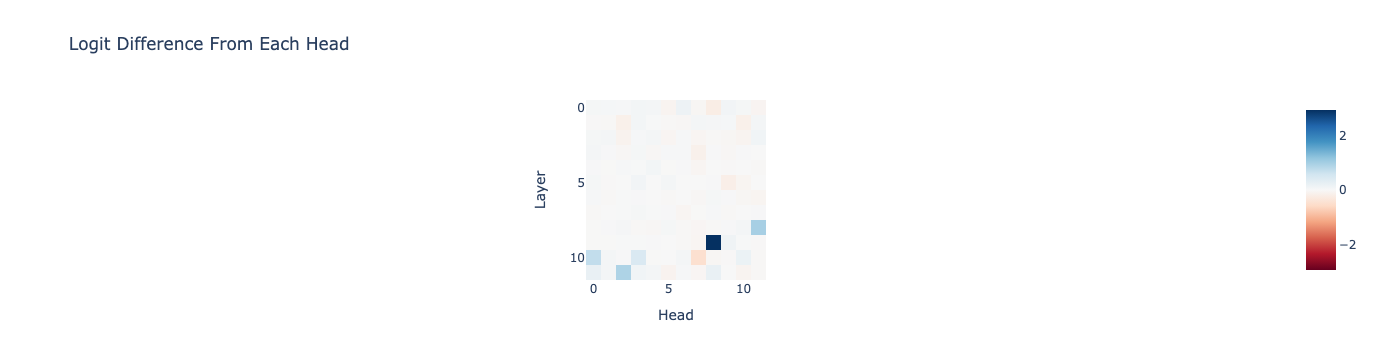

Tried to stack head results when they weren't cached. Computing head results now
['The capital of Canada is']


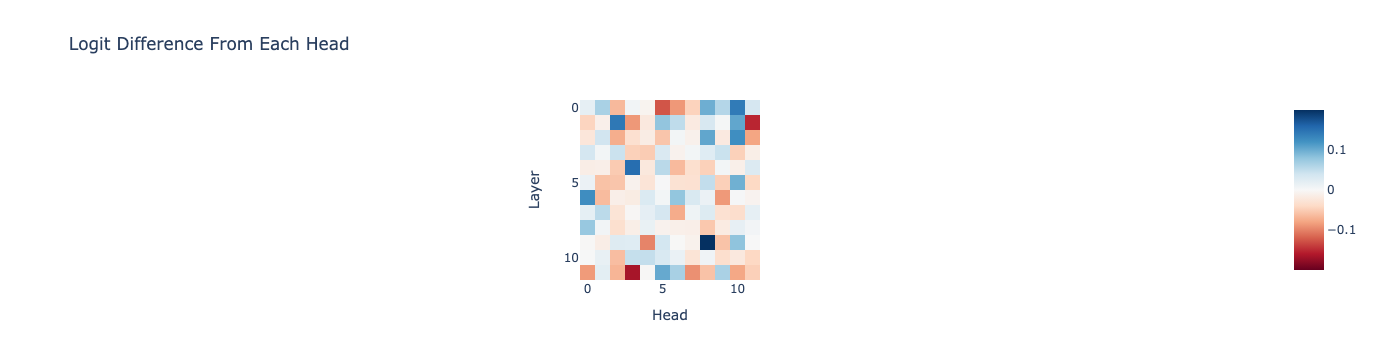

Tried to stack head results when they weren't cached. Computing head results now
['Dolphins live in the']


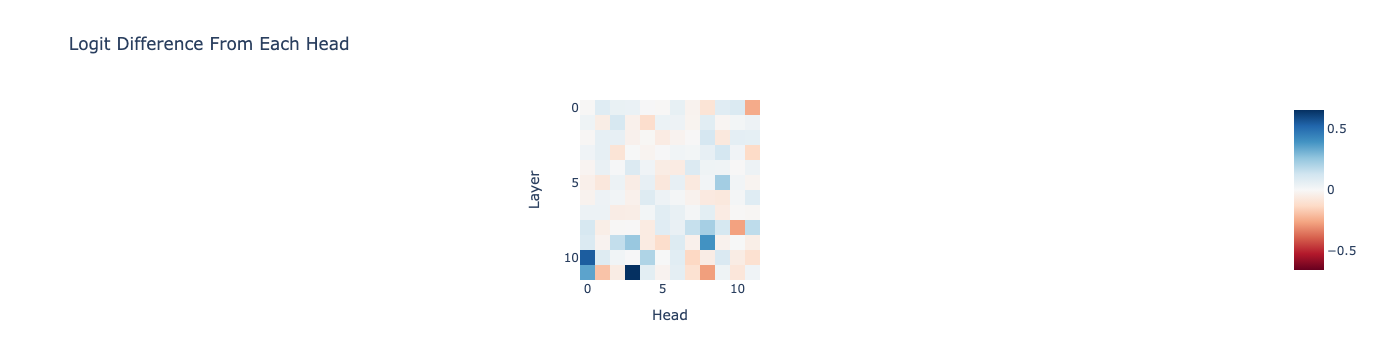

Tried to stack head results when they weren't cached. Computing head results now
['The ocean is home to']


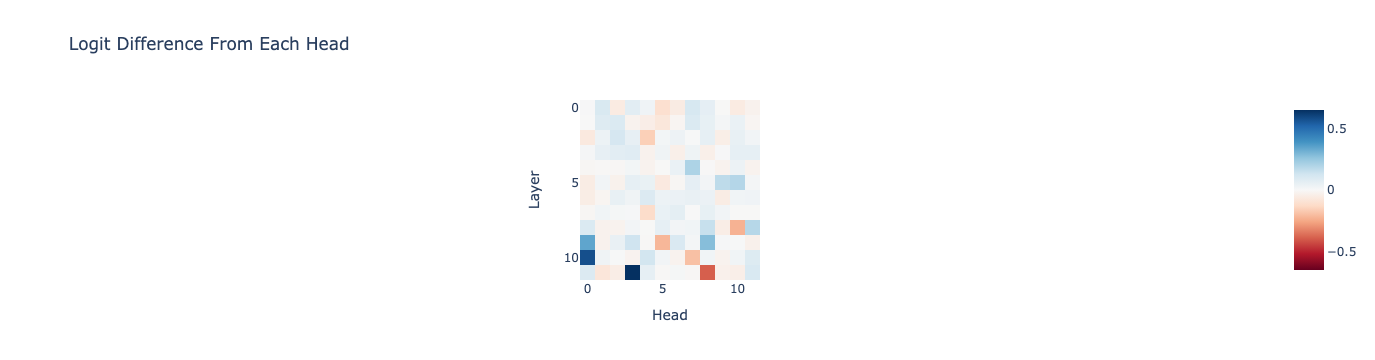

Tried to stack head results when they weren't cached. Computing head results now
['Tigers live in the']


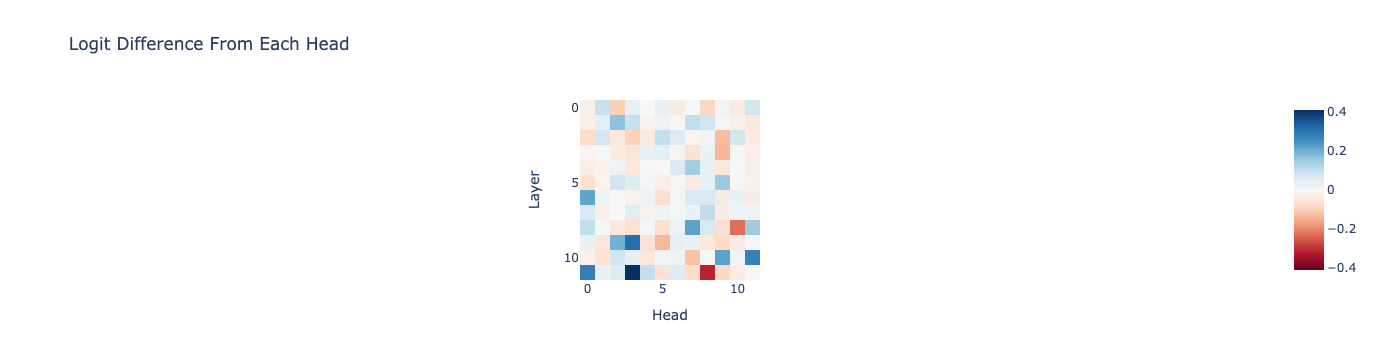

Tried to stack head results when they weren't cached. Computing head results now
['The jungle is home to']


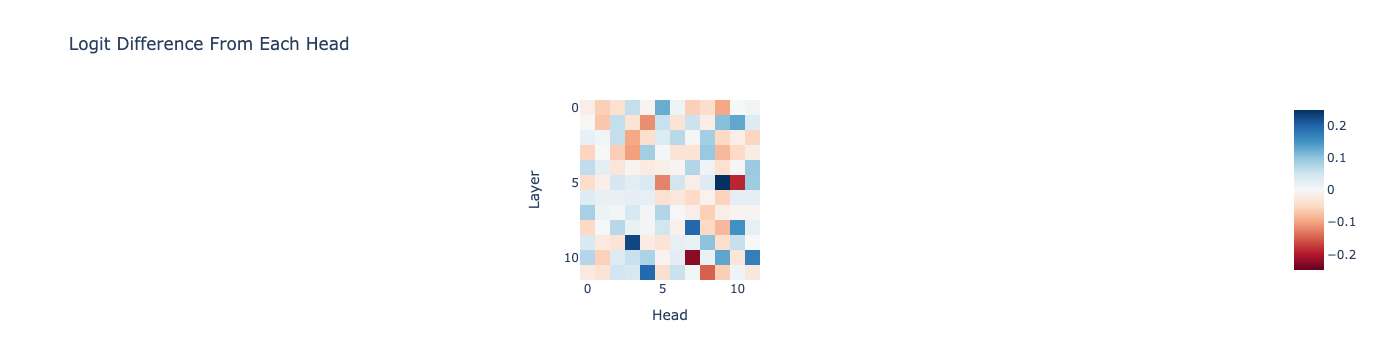

Tried to stack head results when they weren't cached. Computing head results now
['Camels live in the']


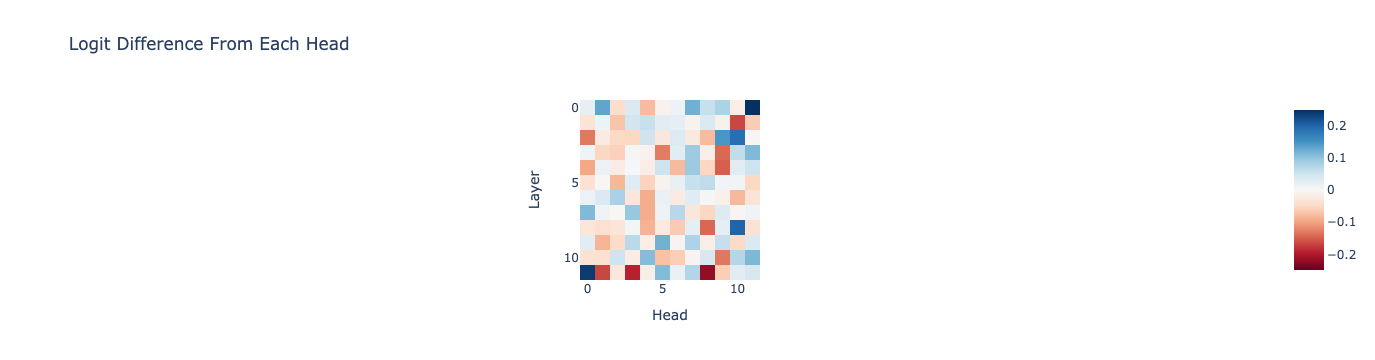

Tried to stack head results when they weren't cached. Computing head results now
['The desert is home to']


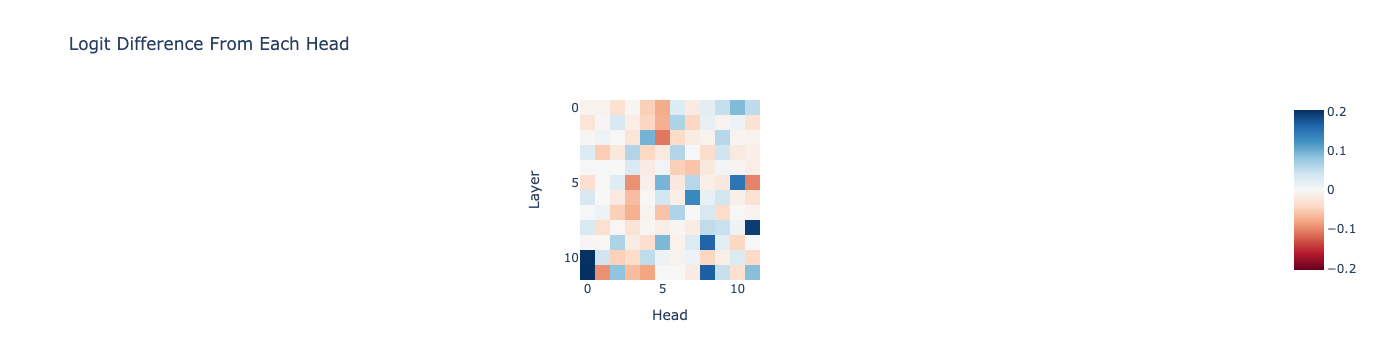

Tried to stack head results when they weren't cached. Computing head results now
['Bill Gates is the founder of']


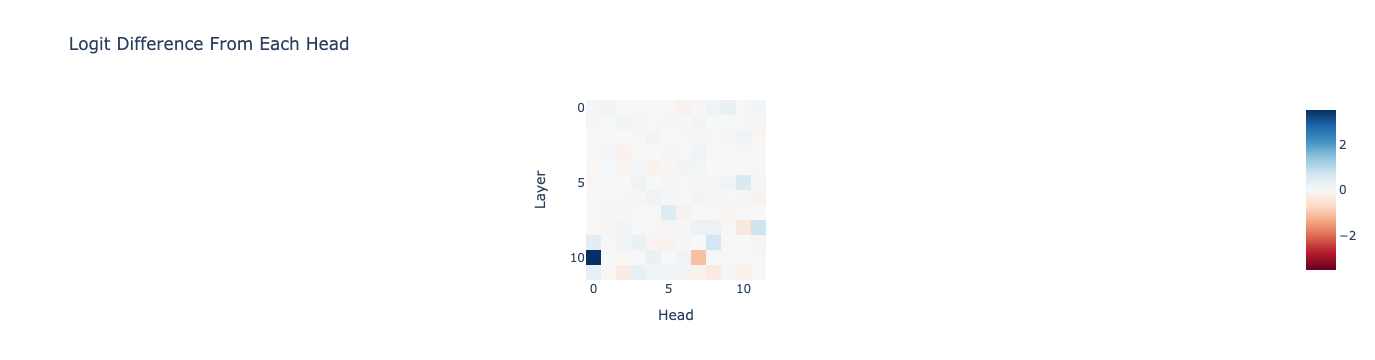

Tried to stack head results when they weren't cached. Computing head results now
['Microsoft was founded by']


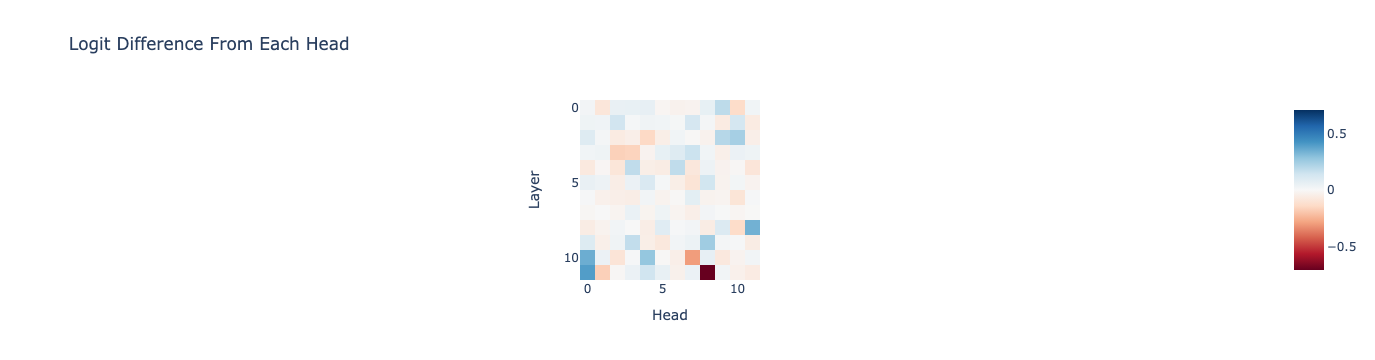

Tried to stack head results when they weren't cached. Computing head results now
['The Nile is the longest river in']


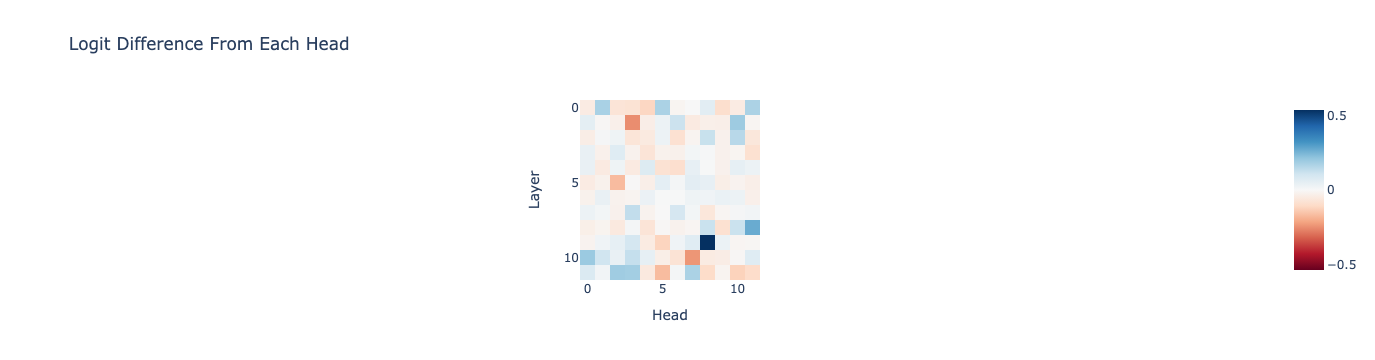

Tried to stack head results when they weren't cached. Computing head results now
['The longest river in Africa is the']


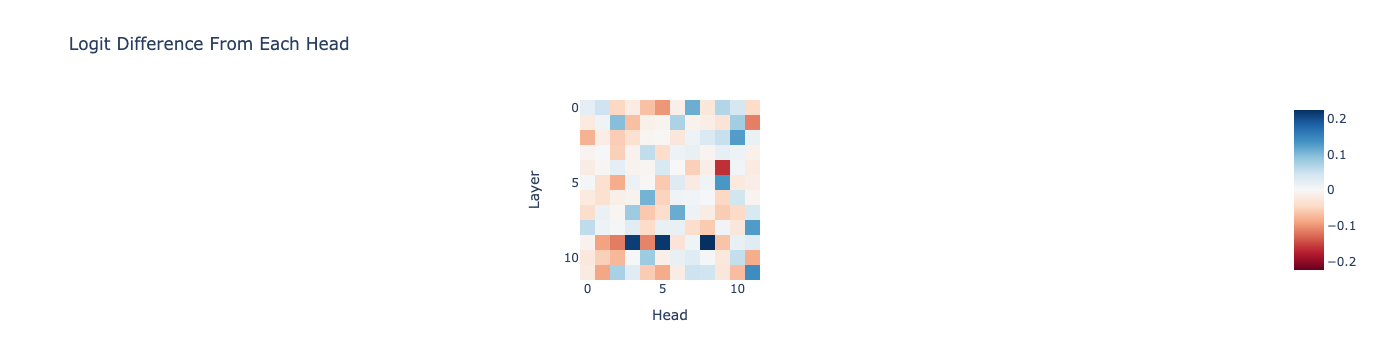

Tried to stack head results when they weren't cached. Computing head results now
['The Yangtze is the longest river in']


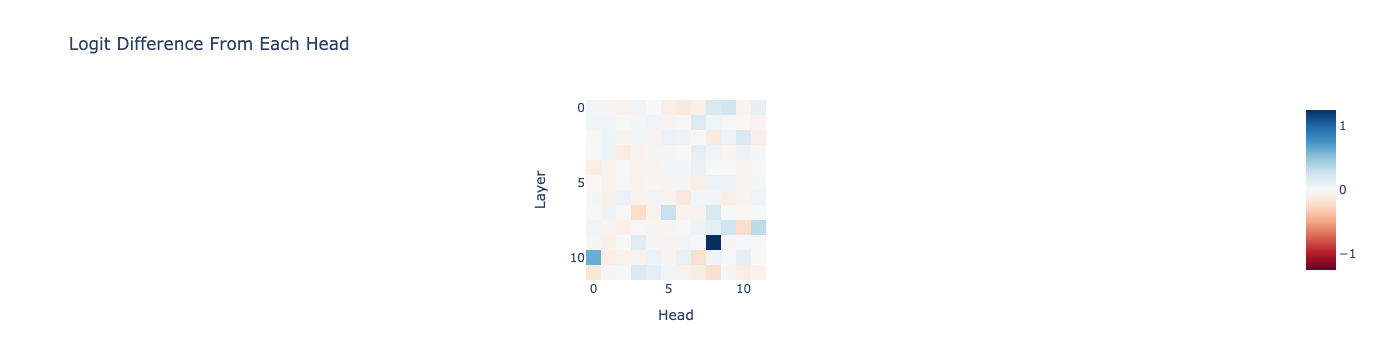

Tried to stack head results when they weren't cached. Computing head results now
['The longest river in Asia is the']


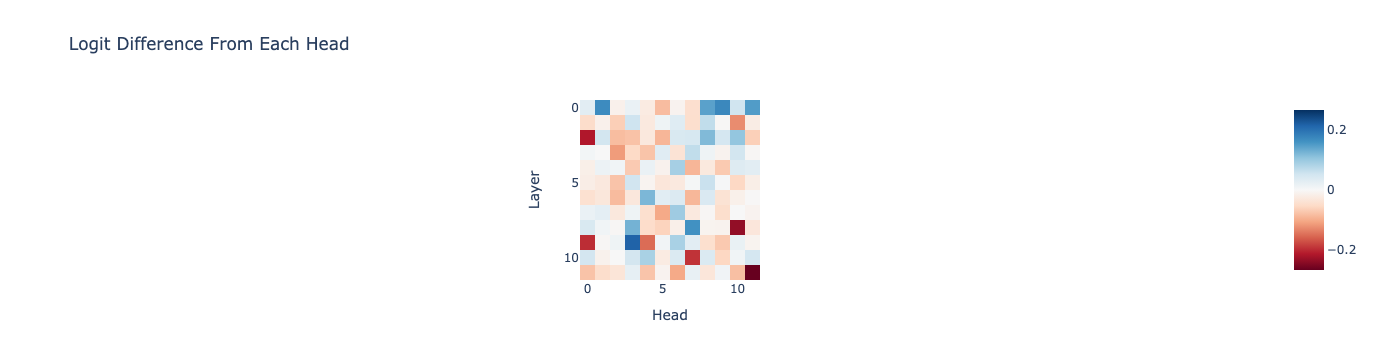

Tried to stack head results when they weren't cached. Computing head results now
['English is the language spoken in']


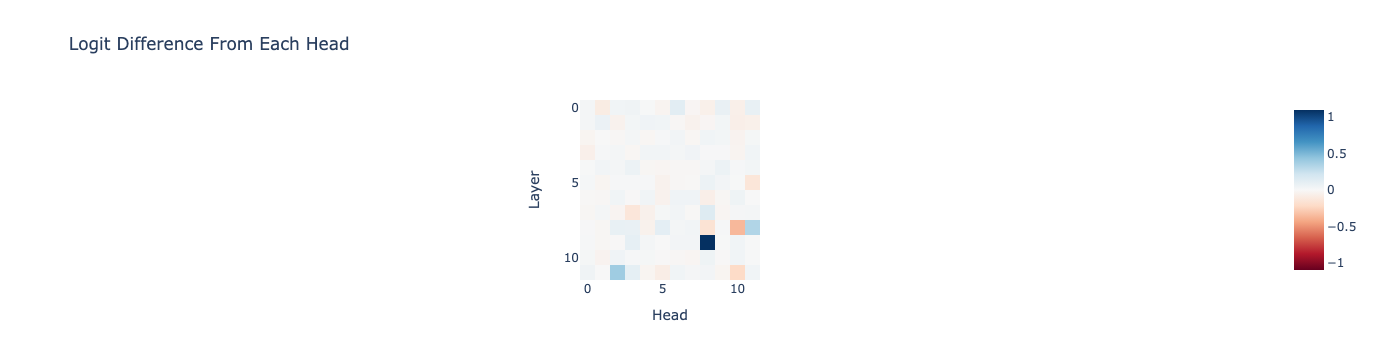

Tried to stack head results when they weren't cached. Computing head results now
['People from England speak']


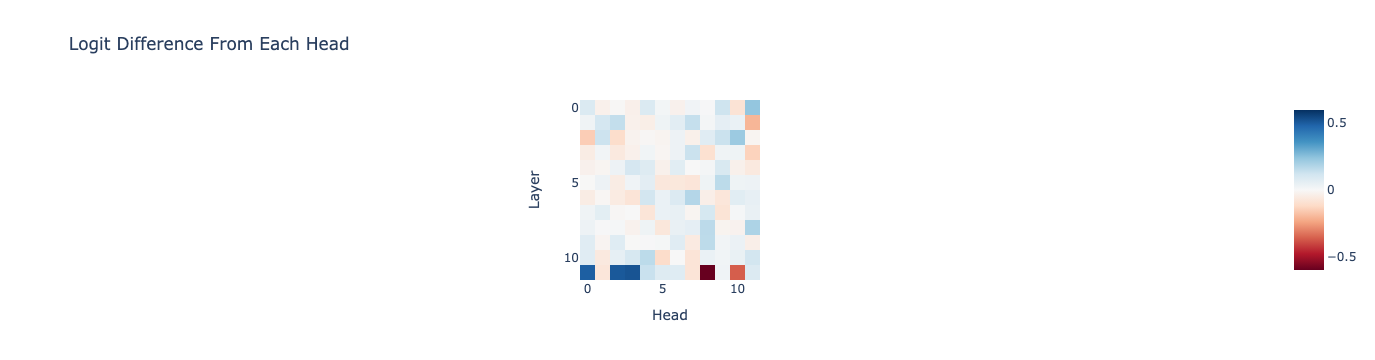

Tried to stack head results when they weren't cached. Computing head results now
['French is the language spoken in']


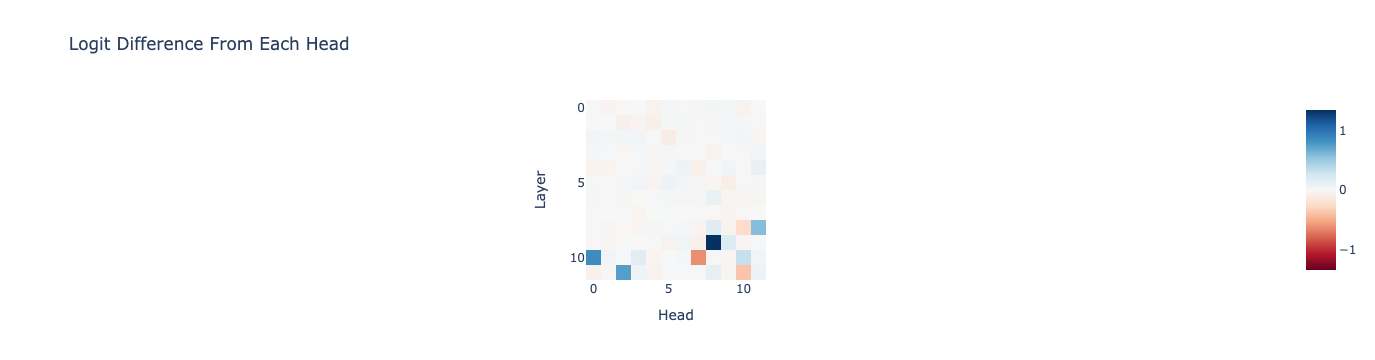

Tried to stack head results when they weren't cached. Computing head results now
['People from France speak']


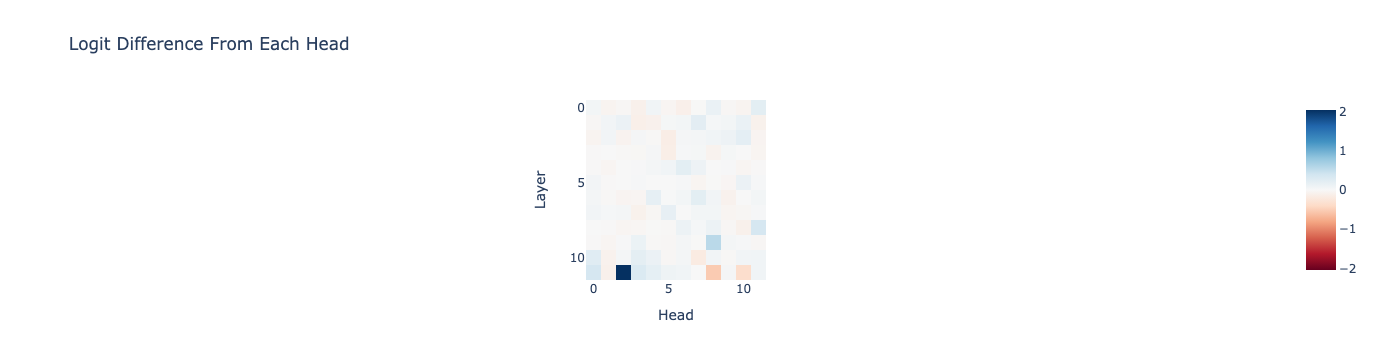

Tried to stack head results when they weren't cached. Computing head results now
['German is the language spoken in']


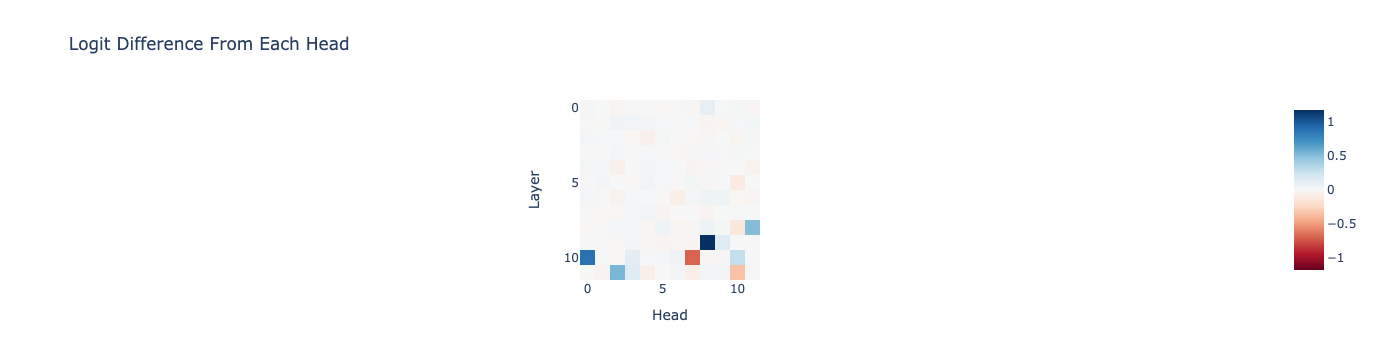

Tried to stack head results when they weren't cached. Computing head results now
['People from Germany speak']


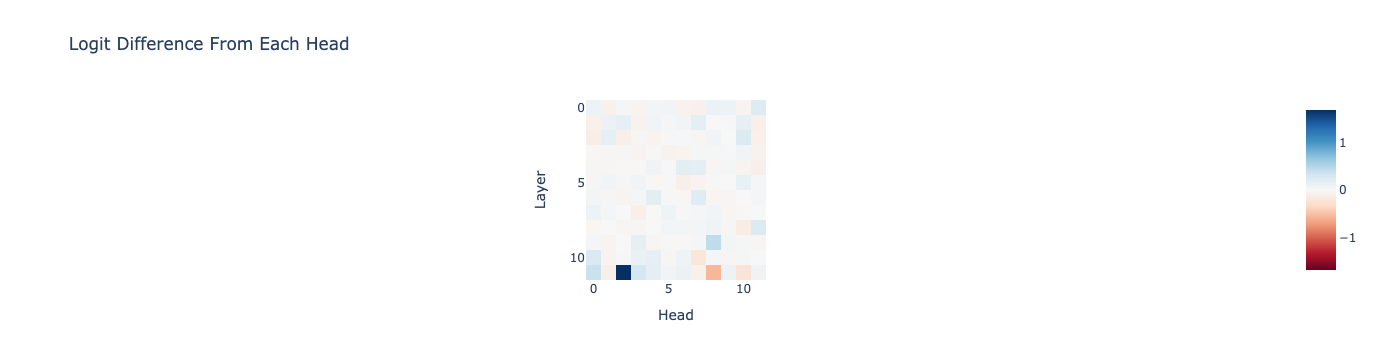

In [239]:
for sample in range(len(dataset)): 
    head_logit_attribution(dataset, forward_logit_diff_directions, forward=True, sample_idx=[sample])
    head_logit_attribution(dataset, backward_logit_diff_directions, forward=False, sample_idx=[sample])

    

Need to run code below in Google Colab (or any other Ubuntu machine)

In [144]:
tokens = prompt_tokens
def visualize_attention_patterns(
    heads: Union[List[int], int, Float[torch.Tensor, "heads"]],
    local_cache: Optional[ActivationCache]=None,
    local_tokens: Optional[torch.Tensor]=None,
    title: str=""):
    # Heads are given as a list of integers or a single integer in [0, n_layers * n_heads)
    if isinstance(heads, int):
        heads = [heads]
    elif isinstance(heads, list) or isinstance(heads, torch.Tensor):
        heads = utils.to_numpy(heads)
    # Cache defaults to the original activation cache
    if local_cache is None:
        local_cache = cache
    # Tokens defaults to the tokenization of the first prompt (including the BOS token)
    if local_tokens is None:
        # The tokens of the first prompt
        local_tokens = tokens[0]

    labels = []
    patterns = []
    batch_index = 0
    for head in heads:
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache["attn", layer][batch_index, head_index])
        labels.append(f"L{layer}H{head_index}")
    str_tokens = model.to_str_tokens(local_tokens)
    patterns = torch.stack(patterns, dim=-1)
    # Plot the attention patterns
    attention_vis = pysvelte.AttentionMulti(attention=patterns, tokens=str_tokens, head_labels=labels)
    display(HTML(f"<h3>{title}</h3>"))
    attention_vis.show()

if IN_COLAB: 
    top_k = 100
    top_positive_logit_attr_heads = torch.topk(per_head_logit_diffs.flatten(), k=top_k).indices
    visualize_attention_patterns(top_positive_logit_attr_heads, title=f"Top {top_k} Positive Logit Attribution Heads")
    top_negative_logit_attr_heads = torch.topk(-per_head_logit_diffs.flatten(), k=top_k).indices
    visualize_attention_patterns(top_negative_logit_attr_heads, title=f"Top {top_k} Negative Logit Attribution Heads")

## Method2: Causal Tracing using Activation Patching


The setup of activation patching is to take two runs of the model on two different inputs, the clean run and the corrupted run. The clean run outputs the correct answer and the corrupted run does not. The key idea is that we give the model the corrupted input, but then **intervene** on a specific activation and **patch** in the corresponding activation from the clean run (ie replace the corrupted activation with the clean activation), and then continue the run. And we then measure how much the output has updated towards the correct answer.

We can then iterate over many possible activations and look at how much they affect the corrupted run. If patching in an activation significantly increases the probability of the correct answer, this allows us to *localise* which activations matter.

In [273]:
def pad_tokens_from_left(token_list : List[torch.tensor], maxlen:int):
    pad_token = model.tokenizer.pad_token_id
    padded_tokenized_inputs = torch.zeros((len(token_list), maxlen))
    for i, tokens in enumerate(token_list):
        n_pads = maxlen - tokens.shape[-1]
        padded_tokenized_inputs[i, :n_pads] = pad_token
        padded_tokenized_inputs[i, n_pads:] = tokens
    return padded_tokenized_inputs.long()

def get_corrupted_prompts(dataset, 
                         forward=False, 
                         noise_multiplier=8, 
                         sample_idx=None):
    if sample_idx is not None: 
        dataset = [d for i,d in enumerate(dataset) if i in sample_idx]
        logit_diff_directions = [d for i,d in enumerate(logit_diff_directions) if i in sample_idx]
        
    if forward: 
        subject = "subject_1"
        obj = "object_1"
        sentence = "sentence_1"
    else:
        subject = "subject_2"
        obj = "object_2"
        sentence = "sentence_2"

    noise_scale = model.W_E.std(dim=-1).mean(dim=-1) * noise_multiplier
    d_model = model.W_E.shape[-1]
        
    prompts = []

    for i, sample in enumerate(dataset): 
        
        subject_tokens = model.to_tokens(sample[subject])
        n_tokens = subject_tokens.shape[-1]
    
        noise = torch.randn(n_tokens, d_model).to(device)*noise_scale
        noise_mask = torch.ones(n_tokens, d_model).to(device)
        noise_mask[0,:] = 0 #dont noisify start token (shape: tokens, d_model)
        
        noise = torch.mul(noise, noise_mask.float())
        embeddings = model.embed(subject_tokens) #[batch] x [n_tokens] x [residual_dim]
        embeddings = embeddings + noise
                     
        logits = model.unembed(embeddings)  #[batch] x [n_tokens] x [vocab_size]
        noisy_tokens = torch.argmax(logits, dim=-1) #[batch] x [n_tokens]+

        #making sure there are no more end of sequence tokens in the middle of the prompt
        mask = (noisy_tokens == 50256).to(device)
        mask[:,0] = 0
        random_integers = torch.randint(0, 50256 - 1, noisy_tokens.size(), dtype=torch.long).to(device)
        noisy_tokens = torch.where(mask, random_integers, noisy_tokens)
        noisy_token_str = model.to_string(noisy_tokens[:,1:])
        
        corrupted_prompts = sample[sentence].format(subject=noisy_token_str[0], obj="")[:-1]
        prompts.append(corrupted_prompts)
    
    return prompts



In [297]:
forward_corrupted_prompts = get_corrupted_prompts(dataset,
                                               forward = True,
                                               noise_multiplier = 25, 
                                               sample_idx=None)

forward_corrupted_prompts

[' torped is the capital of',
 'competitive Elijah is the capital of',
 'ORNitzer is the capital of',
 'lenessricks live in the',
 'Disclaimersych live in the',
 ' SakuyaSourceFile live in the',
 ' Celtyip is the founder of',
 'The  galleriesresso is the longest river in',
 'The heimerandals deserts is the longest river in',
 ' microbiome is the language spoken in',
 ' largeDownload is the language spoken in',
 'arer is the language spoken in']

In [289]:
backward_corrupted_prompts = get_corrupted_prompts(dataset,
                                               forward = False,
                                               noise_multiplier = 25, 
                                               sample_idx=None)

backward_corrupted_prompts

['The capital of aughs is',
 'The capital of udeau is',
 'The capital of  Masquerade is',
 'The bermanoil is home to',
 'The illionhandedly is home to',
 'The ordable Bowser is home to',
 ' mids was founded by',
 'The longest  occupmiloschild is the',
 'The longest borgceleillon is the',
 'People from  commanding speak',
 'People from cler speak',
 'People from atars speak']

In [290]:
for f_prompt, correct_answer in zip(forward_corrupted_prompt, [d["object_1"] for d in dataset]):
    utils.test_prompt(f_prompt, correct_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'imm', ' is', ' the', ' capital', ' of']
Tokenized answer: [' France']


Performance on answer token:
Rank: 13       Logit: 10.30 Prob:  0.50% Token: | France|

Top 0th token. Logit: 14.01 Prob: 20.29% Token: | the|
Top 1th token. Logit: 11.70 Prob:  2.00% Token: | Israel|
Top 2th token. Logit: 11.69 Prob:  1.99% Token: | a|
Top 3th token. Logit: 11.26 Prob:  1.30% Token: | India|
Top 4th token. Logit: 10.95 Prob:  0.94% Token: | Germany|
Top 5th token. Logit: 10.79 Prob:  0.81% Token: | Iran|
Top 6th token. Logit: 10.60 Prob:  0.67% Token: | Russia|
Top 7th token. Logit: 10.57 Prob:  0.65% Token: | North|
Top 8th token. Logit: 10.56 Prob:  0.64% Token: | Sweden|
Top 9th token. Logit: 10.56 Prob:  0.64% Token: | China|


Ranks of the answer tokens: [(' France', 13)]

Tokenized prompt: ['<|endoftext|>', ' roam', 'erto', ' is', ' the', ' capital', ' of']
Tokenized answer: [' Italy']


Performance on answer token:
Rank: 15       Logit: 11.04 Prob:  0.68% Token: | Italy|

Top 0th token. Logit: 14.20 Prob: 16.05% Token: | the|
Top 1th token. Logit: 13.10 Prob:  5.34% Token: | Spain|
Top 2th token. Logit: 12.68 Prob:  3.52% Token: | Venezuela|
Top 3th token. Logit: 12.46 Prob:  2.83% Token: | Puerto|
Top 4th token. Logit: 12.31 Prob:  2.41% Token: | a|
Top 5th token. Logit: 12.22 Prob:  2.21% Token: | Brazil|
Top 6th token. Logit: 12.02 Prob:  1.82% Token: | Portugal|
Top 7th token. Logit: 11.99 Prob:  1.75% Token: | Rio|
Top 8th token. Logit: 11.89 Prob:  1.59% Token: | Colombia|
Top 9th token. Logit: 11.84 Prob:  1.52% Token: | Mexico|


Ranks of the answer tokens: [(' Italy', 15)]

Tokenized prompt: ['<|endoftext|>', ' N', 'ant', 'ot', 'ons', ' is', ' the', ' capital', ' of']
Tokenized answer: [' Canada']


Performance on answer token:
Rank: 34       Logit: 10.73 Prob:  0.30% Token: | Canada|

Top 0th token. Logit: 14.94 Prob: 20.52% Token: | the|
Top 1th token. Logit: 13.93 Prob:  7.48% Token: | N|
Top 2th token. Logit: 13.64 Prob:  5.62% Token: | North|
Top 3th token. Logit: 13.41 Prob:  4.45% Token: | New|
Top 4th token. Logit: 12.70 Prob:  2.20% Token: | South|
Top 5th token. Logit: 12.59 Prob:  1.97% Token: | a|
Top 6th token. Logit: 11.96 Prob:  1.05% Token: | California|
Top 7th token. Logit: 11.83 Prob:  0.92% Token: | Northern|
Top 8th token. Logit: 11.47 Prob:  0.64% Token: | Southeast|
Top 9th token. Logit: 11.44 Prob:  0.62% Token: | West|


Ranks of the answer tokens: [(' Canada', 34)]

Tokenized prompt: ['<|endoftext|>', '``', 'resses', ' live', ' in', ' the']
Tokenized answer: [' ocean']


Performance on answer token:
Rank: 15       Logit: 10.00 Prob:  0.58% Token: | ocean|

Top 0th token. Logit: 11.72 Prob:  3.23% Token: | world|
Top 1th token. Logit: 11.70 Prob:  3.17% Token: | same|
Top 2th token. Logit: 11.21 Prob:  1.95% Token: | heart|
Top 3th token. Logit: 10.67 Prob:  1.14% Token: | middle|
Top 4th token. Logit: 10.45 Prob:  0.91% Token: | wild|
Top 5th token. Logit: 10.43 Prob:  0.90% Token: | body|
Top 6th token. Logit: 10.38 Prob:  0.85% Token: | mind|
Top 7th token. Logit: 10.37 Prob:  0.84% Token: | forest|
Top 8th token. Logit: 10.37 Prob:  0.84% Token: | past|
Top 9th token. Logit: 10.15 Prob:  0.68% Token: | universe|


Ranks of the answer tokens: [(' ocean', 15)]

Tokenized prompt: ['<|endoftext|>', 'ese', 'ismo', ' live', ' in', ' the']
Tokenized answer: [' jungle']


Performance on answer token:
Rank: 17       Logit:  9.21 Prob:  0.52% Token: | jungle|

Top 0th token. Logit: 11.13 Prob:  3.58% Token: | city|
Top 1th token. Logit: 10.40 Prob:  1.72% Token: | world|
Top 2th token. Logit: 10.38 Prob:  1.69% Token: | heart|
Top 3th token. Logit: 10.36 Prob:  1.65% Token: | same|
Top 4th token. Logit: 10.14 Prob:  1.33% Token: | streets|
Top 5th token. Logit: 10.06 Prob:  1.23% Token: | mountains|
Top 6th token. Logit:  9.91 Prob:  1.05% Token: | real|
Top 7th token. Logit:  9.74 Prob:  0.89% Token: | middle|
Top 8th token. Logit:  9.50 Prob:  0.70% Token: | shadows|
Top 9th token. Logit:  9.40 Prob:  0.63% Token: | future|


Ranks of the answer tokens: [(' jungle', 17)]

Tokenized prompt: ['<|endoftext|>', ' Aging', 'tainment', ' live', ' in', ' the']
Tokenized answer: [' desert']


Performance on answer token:
Rank: 62       Logit:  8.93 Prob:  0.20% Token: | desert|

Top 0th token. Logit: 11.86 Prob:  3.82% Token: | heart|
Top 1th token. Logit: 11.52 Prob:  2.73% Token: | city|
Top 2th token. Logit: 11.01 Prob:  1.63% Token: | same|
Top 3th token. Logit: 11.00 Prob:  1.62% Token: | world|
Top 4th token. Logit: 10.82 Prob:  1.36% Token: | United|
Top 5th token. Logit: 10.81 Prob:  1.34% Token: | shadows|
Top 6th token. Logit: 10.49 Prob:  0.97% Token: | shadow|
Top 7th token. Logit: 10.42 Prob:  0.91% Token: | studio|
Top 8th token. Logit: 10.40 Prob:  0.89% Token: | suburbs|
Top 9th token. Logit: 10.37 Prob:  0.86% Token: | past|


Ranks of the answer tokens: [(' desert', 62)]

Tokenized prompt: ['<|endoftext|>', 'Reviewed', '@#&', ' is', ' the', ' founder', ' of']
Tokenized answer: [' Microsoft']


Performance on answer token:
Rank: 309      Logit:  6.03 Prob:  0.04% Token: | Microsoft|

Top 0th token. Logit: 12.20 Prob: 16.83% Token: | the|
Top 1th token. Logit: 10.94 Prob:  4.75% Token: | The|
Top 2th token. Logit: 10.05 Prob:  1.95% Token: | a|
Top 3th token. Logit:  8.93 Prob:  0.64% Token: | C|
Top 4th token. Logit:  8.72 Prob:  0.52% Token: | A|
Top 5th token. Logit:  8.56 Prob:  0.44% Token: | an|
Top 6th token. Logit:  8.51 Prob:  0.42% Token: | e|
Top 7th token. Logit:  8.44 Prob:  0.39% Token: | this|
Top 8th token. Logit:  8.44 Prob:  0.39% Token: | X|
Top 9th token. Logit:  8.43 Prob:  0.39% Token: | P|


Ranks of the answer tokens: [(' Microsoft', 309)]

Tokenized prompt: ['<|endoftext|>', 'The', ' ', ' Dru', 'ALE', ' is', ' the', ' longest', ' river', ' in']
Tokenized answer: [' Africa']


Performance on answer token:
Rank: 19       Logit: 11.59 Prob:  0.59% Token: | Africa|

Top 0th token. Logit: 15.61 Prob: 32.82% Token: | the|
Top 1th token. Logit: 13.54 Prob:  4.14% Token: | North|
Top 2th token. Logit: 13.44 Prob:  3.75% Token: | Europe|
Top 3th token. Logit: 12.91 Prob:  2.19% Token: | Australia|
Top 4th token. Logit: 12.77 Prob:  1.92% Token: | India|
Top 5th token. Logit: 12.59 Prob:  1.59% Token: | Ireland|
Top 6th token. Logit: 12.44 Prob:  1.37% Token: | South|
Top 7th token. Logit: 12.08 Prob:  0.96% Token: | Northern|
Top 8th token. Logit: 11.93 Prob:  0.83% Token: | all|
Top 9th token. Logit: 11.90 Prob:  0.80% Token: | China|


Ranks of the answer tokens: [(' Africa', 19)]

Tokenized prompt: ['<|endoftext|>', 'The', ' ', ' ACPI', ' dred', 'olls', ' is', ' the', ' longest', ' river', ' in']
Tokenized answer: [' Asia']


Performance on answer token:
Rank: 8        Logit: 11.92 Prob:  0.77% Token: | Asia|

Top 0th token. Logit: 15.85 Prob: 39.04% Token: | the|
Top 1th token. Logit: 14.54 Prob: 10.61% Token: | North|
Top 2th token. Logit: 13.69 Prob:  4.51% Token: | South|
Top 3th token. Logit: 13.56 Prob:  3.98% Token: | Australia|
Top 4th token. Logit: 13.41 Prob:  3.41% Token: | Europe|
Top 5th token. Logit: 12.38 Prob:  1.22% Token: | Africa|
Top 6th token. Logit: 11.98 Prob:  0.81% Token: | all|
Top 7th token. Logit: 11.96 Prob:  0.80% Token: | Canada|
Top 8th token. Logit: 11.92 Prob:  0.77% Token: | Asia|
Top 9th token. Logit: 11.92 Prob:  0.77% Token: | Southeast|


Ranks of the answer tokens: [(' Asia', 8)]

Tokenized prompt: ['<|endoftext|>', 'Wheel', ' is', ' the', ' language', ' spoken', ' in']
Tokenized answer: [' England']


Performance on answer token:
Rank: 23       Logit:  9.28 Prob:  0.29% Token: | England|

Top 0th token. Logit: 13.67 Prob: 23.04% Token: | the|
Top 1th token. Logit: 11.52 Prob:  2.68% Token: | all|
Top 2th token. Logit: 11.45 Prob:  2.50% Token: | many|
Top 3th token. Logit: 11.17 Prob:  1.89% Token: | a|
Top 4th token. Logit: 10.57 Prob:  1.04% Token: | every|
Top 5th token. Logit: 10.57 Prob:  1.04% Token: | most|
Top 6th token. Logit: 10.55 Prob:  1.01% Token: | this|
Top 7th token. Logit: 10.47 Prob:  0.94% Token: | English|
Top 8th token. Logit: 10.31 Prob:  0.80% Token: | North|
Top 9th token. Logit: 10.30 Prob:  0.79% Token: | both|


Ranks of the answer tokens: [(' England', 23)]

Tokenized prompt: ['<|endoftext|>', 'channelAvailability', ' is', ' the', ' language', ' spoken', ' in']
Tokenized answer: [' France']


Performance on answer token:
Rank: 83       Logit:  8.52 Prob:  0.10% Token: | France|

Top 0th token. Logit: 14.20 Prob: 29.33% Token: | the|
Top 1th token. Logit: 11.96 Prob:  3.13% Token: | this|
Top 2th token. Logit: 11.92 Prob:  2.99% Token: | English|
Top 3th token. Logit: 11.90 Prob:  2.94% Token: | a|
Top 4th token. Logit: 11.55 Prob:  2.07% Token: | our|
Top 5th token. Logit: 11.18 Prob:  1.43% Token: | all|
Top 6th token. Logit: 11.17 Prob:  1.42% Token: | many|
Top 7th token. Logit: 11.04 Prob:  1.25% Token: | every|
Top 8th token. Logit: 10.65 Prob:  0.84% Token: | America|
Top 9th token. Logit: 10.65 Prob:  0.84% Token: | that|


Ranks of the answer tokens: [(' France', 83)]

Tokenized prompt: ['<|endoftext|>', 'bial', ' is', ' the', ' language', ' spoken', ' in']
Tokenized answer: [' Germany']


Performance on answer token:
Rank: 31       Logit:  9.35 Prob:  0.27% Token: | Germany|

Top 0th token. Logit: 13.62 Prob: 19.17% Token: | the|
Top 1th token. Logit: 11.71 Prob:  2.85% Token: | many|
Top 2th token. Logit: 11.48 Prob:  2.27% Token: | Latin|
Top 3th token. Logit: 11.31 Prob:  1.91% Token: | a|
Top 4th token. Logit: 11.14 Prob:  1.62% Token: | all|
Top 5th token. Logit: 10.87 Prob:  1.23% Token: | India|
Top 6th token. Logit: 10.84 Prob:  1.19% Token: | Java|
Top 7th token. Logit: 10.65 Prob:  0.99% Token: | English|
Top 8th token. Logit: 10.54 Prob:  0.89% Token: | most|
Top 9th token. Logit: 10.38 Prob:  0.75% Token: | Arabic|


Ranks of the answer tokens: [(' Germany', 31)]

In [423]:
def get_logit_difference_from_token_prompt(prompt_tokens_list,
                         correct_answer,
                         counterfactual_answers,
                         per_prompt=False, 
                         disp=True):
    differences = []
    for prompt_tokens, correct, counterfactuals in zip(prompt_tokens_list, correct_answer, counterfactual_answers):
        for counter in counterfactuals: 
            logits, _ = model.run_with_cache(prompt_tokens)
            #logits shape : prompts x tokens x vocab_size
            final_logits = logits[:,-1,:]
            correct_answer_token = model.to_tokens(correct)[:,-1].unsqueeze(-1)
            counter_answer_token = model.to_tokens(counter)[:,-1].unsqueeze(-1)
            correct_answer_logits = final_logits.gather(dim=-1, index=correct_answer_token)
            counter_factual_logits = final_logits.gather(dim=-1, index=counter_answer_token)
            diffs = correct_answer_logits.item() - counter_factual_logits.item()
            differences.append(diffs)
    differences = torch.tensor(differences)
    avg = torch.mean(differences)
    if disp: 
        print("Prompt logit differences", differences)
        print(f"Average logit difference (probability {torch.exp(avg):.2f}x of correct over counter): {avg.item():.2f}")
    if per_prompt:
        return differences
    else:
        return avg

def patch_residual_component(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    clean_cache):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component

def normalize_patched_logit_diff(patched_logit_diff, corrupted_average_logit_diff,original_average_logit_diff):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise
    # 0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_average_logit_diff)/(original_average_logit_diff - corrupted_average_logit_diff)

def logits_to_ave_logit_diff(prompt_logits : torch.Tensor,
                             correct_answer : str,
                             incorrect_answer : str):
    final_logits = prompt_logits[:,-1,:]
    correct_answer_token = model.to_tokens(correct_answer)[:,-1]
    incorrect_answer_token = model.to_tokens(incorrect_answer)[:,-1]

    correct_answer_logits = final_logits[:,correct_answer_token]
    counter_factual_logits = final_logits[:, incorrect_answer_token]
    diff = correct_answer_logits - counter_factual_logits
    m = torch.mean(diff)
    return m

def causal_tracing(clean_prompts: List[str], corrupted_prompts: List[str], correct_answers: List[str], counterfactual_answers: List[List[str]], forward=False, sample_idx=None):    
    if sample_idx is not None: 
        clean_prompts = [c for i,c in enumerate(clean_prompts) if i in sample_idx]
        corrupted_prompts = [c for i,c in enumerate(corrupted_prompts) if i in sample_idx]
        correct_answers = [c for i,c in enumerate(correct_answers) if i in sample_idx]
        counterfactual_answers = [c for i,c in enumerate(counterfactual_answers) if i in sample_idx]
    
    # patched_residual_stream_diff = torch.zeros(model.cfg.n_layers, padded_original_prompt_tokens.shape[1], device="cpu", dtype=torch.float32)
    patches = []
    for i in range(len(clean_prompts)): 
        clean_prompt = clean_prompts[i]
        corrupted_prompt = corrupted_prompts[i]
        correct_answer = correct_answers[i]
        counterfactuals = counterfactual_answers[i]
        
        clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True)
        corrupted_tokens = model.to_tokens(corrupted_prompt, prepend_bos=True)
        
        clean_tokens, corrupted_tokens = pad_to_same_length(clean_tokens, corrupted_tokens)
        
        clean_logit_diffs = get_logit_difference_from_token_prompt([clean_tokens], [correct_answer], [counterfactuals], disp=False, per_prompt=True)
        corrupted_logit_diffs = get_logit_difference_from_token_prompt([corrupted_tokens], [correct_answer], [counterfactuals], disp=False, per_prompt=True)
        
        clean_logits, clean_cache = model.run_with_cache(clean_tokens, return_type="logits")
        corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")
        
        
        if clean_tokens.shape[-1] != corrupted_tokens.shape[-1]:
            raise ValueError(f"different number of tokens on prompt {i}")
            
        patched_residual_stream_diff = torch.zeros(model.cfg.n_layers, clean_tokens.shape[-1], device=device, dtype=torch.float32)
        for layer in range(model.cfg.n_layers):

            for position in range(clean_tokens.shape[1]):

                hook_fn = partial(patch_residual_component, pos=position, clean_cache=clean_cache)
                patched_logits = model.run_with_hooks(
                    corrupted_tokens,
                    fwd_hooks = [(utils.get_act_name("resid_pre", layer),
                        hook_fn)],
                    return_type="logits"
                )

                patched_logit_diff = logits_to_ave_logit_diff(patched_logits, correct_answer, counterfactuals)
                patched_residual_stream_diff[layer, position] = normalize_patched_logit_diff(
                                                                                            patched_logit_diff,
                                                                                             torch.mean(corrupted_logit_diffs),
                                                                                             torch.mean(clean_logit_diffs)
                                                                                        )
        patches.append(patched_residual_stream_diff)
    return patches
        
        
def pad_from_left(tokens : torch.tensor, maxlen:int):
    pad_token = model.tokenizer.pad_token_id
    padded_tokenized_inputs = torch.zeros(tokens.shape[0], maxlen)
    
    n_pads = maxlen - tokens.shape[-1]
    padded_tokenized_inputs[:,n_pads] = pad_token
    padded_tokenized_inputs[:,n_pads:] = tokens
    return padded_tokenized_inputs.long()

def pad_to_same_length(clean_tokens, corrupted_tokens): 
    
    maxlen = max([clean_tokens.shape[-1], corrupted_tokens.shape[-1]])
    
    if clean_tokens.shape[-1] > corrupted_tokens.shape[-1]: 
        corrupted_tokens = pad_from_left(corrupted_tokens, maxlen)
    elif clean_tokens.shape[-1] < corrupted_tokens.shape[-1]: 
        clean_tokens = pad_from_left(clean_tokens, maxlen)
    
    return clean_tokens, corrupted_tokens

In [447]:
forward_clean_prompts = [
    d["sentence_1"].format(subject=d["subject_1"], obj="")[:-1] for d in dataset
]
forward_correct_answers = [d["object_1"] for d in dataset]
forward_counters = [d["counter_factual_1"] for d in dataset]

forward_patches = causal_tracing(clean_prompts=forward_clean_prompts,
               corrupted_prompts=forward_corrupted_prompts,
               correct_answers=forward_correct_answers,
               counterfactual_answers=forward_counters,
               forward=False)

backward_clean_prompts = [
    d["sentence_2"].format(subject=d["subject_2"], obj="")[:-1] for d in dataset
]
backward_correct_answers = [d["object_2"] for d in dataset]
backward_counters = [d["counter_factual_2"] for d in dataset]

backward_patches = causal_tracing(clean_prompts=backward_clean_prompts,
               corrupted_prompts=backward_corrupted_prompts,
               correct_answers=backward_correct_answers,
               counterfactual_answers=backward_counters)

Paris is the capital of


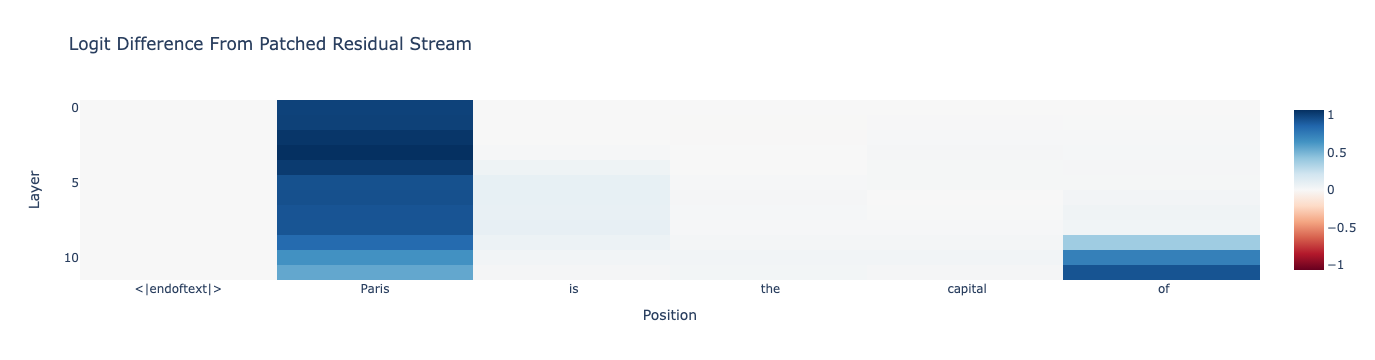

The capital of France is


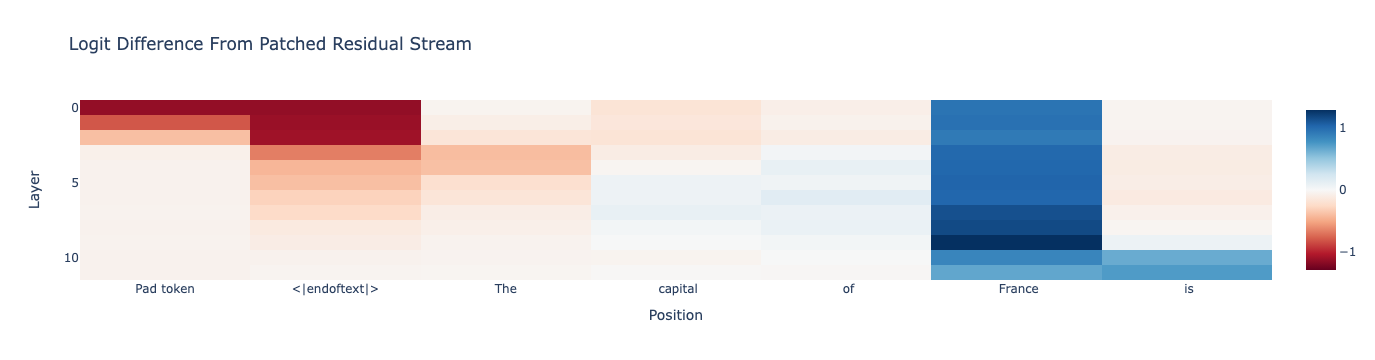

Rome is the capital of


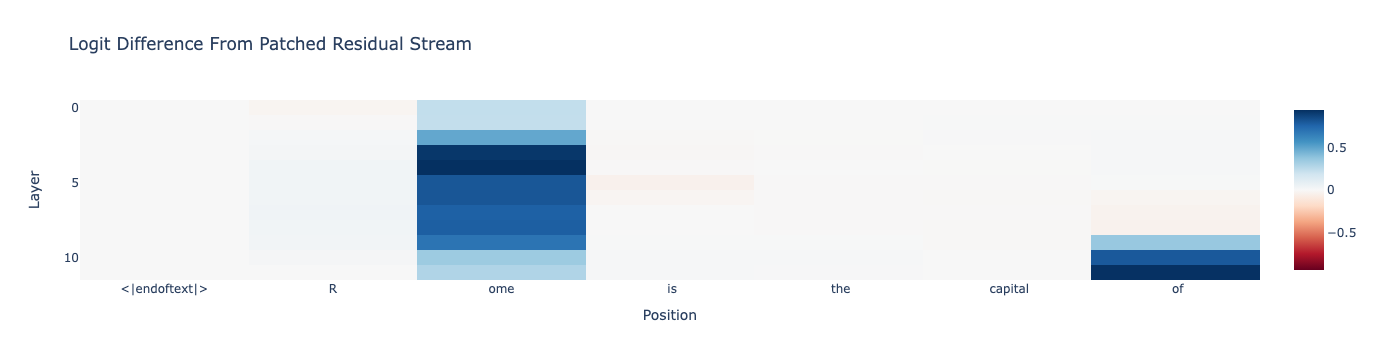

The capital of Italy is


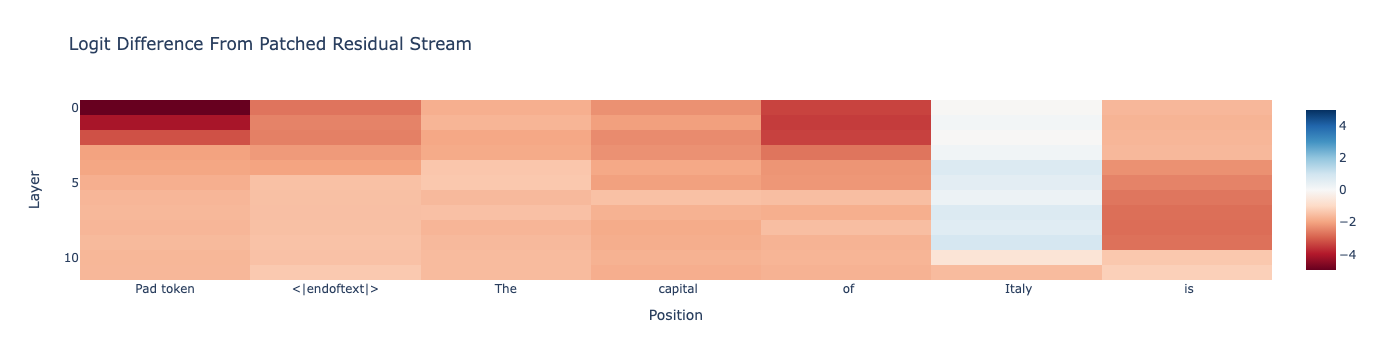

Ottawa is the capital of


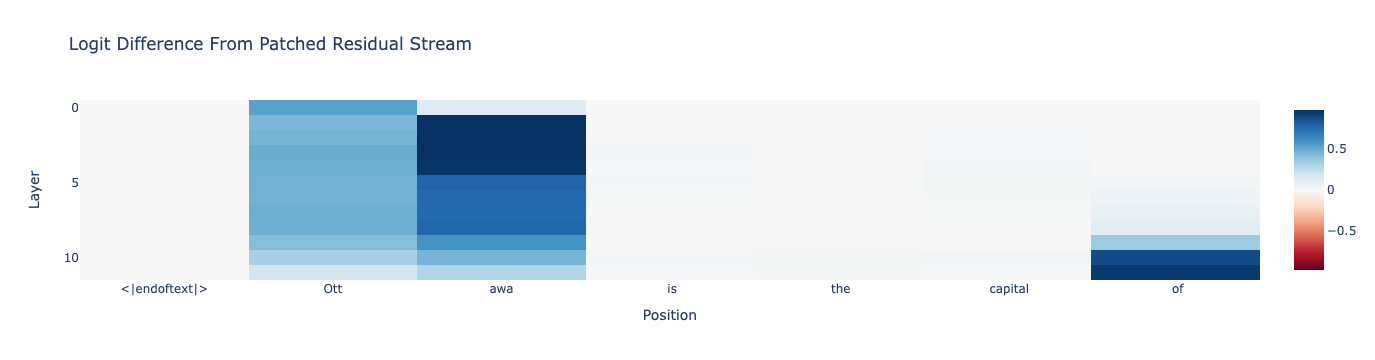

The capital of Canada is


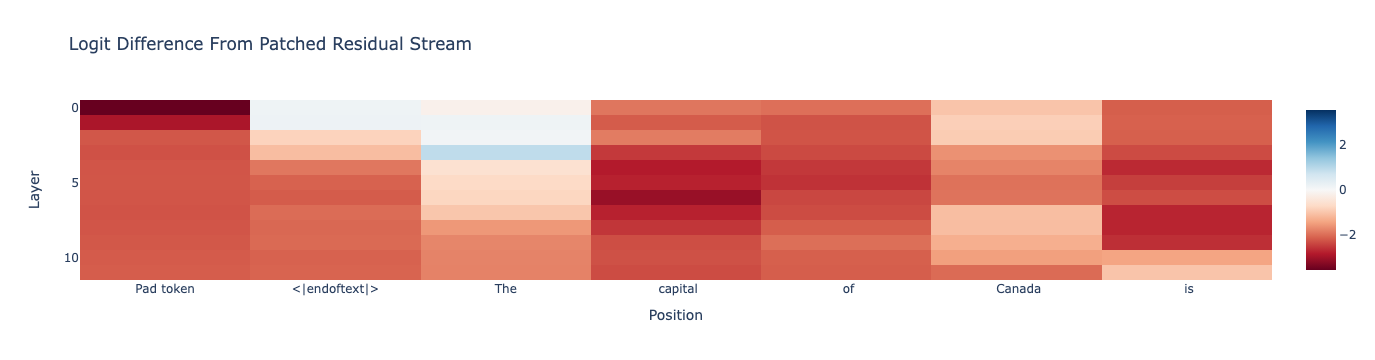

Dolphins live in the


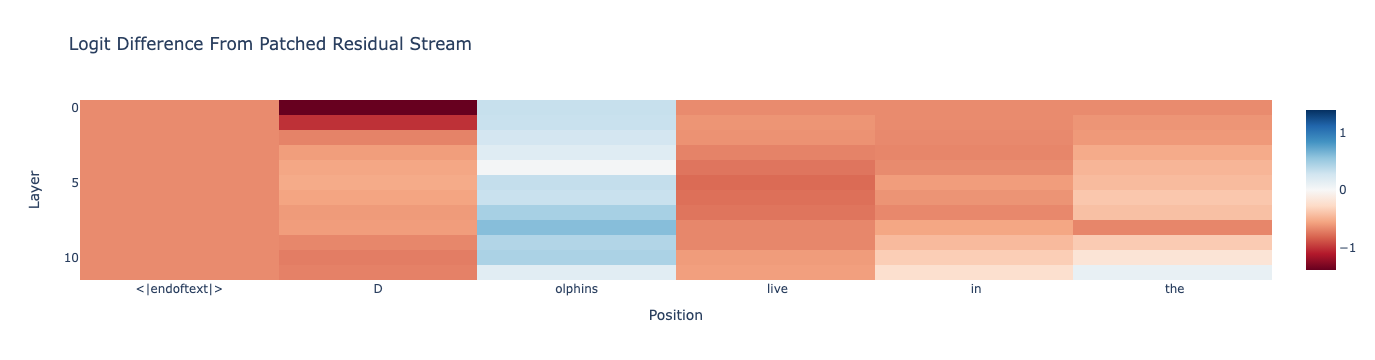

The ocean is home to


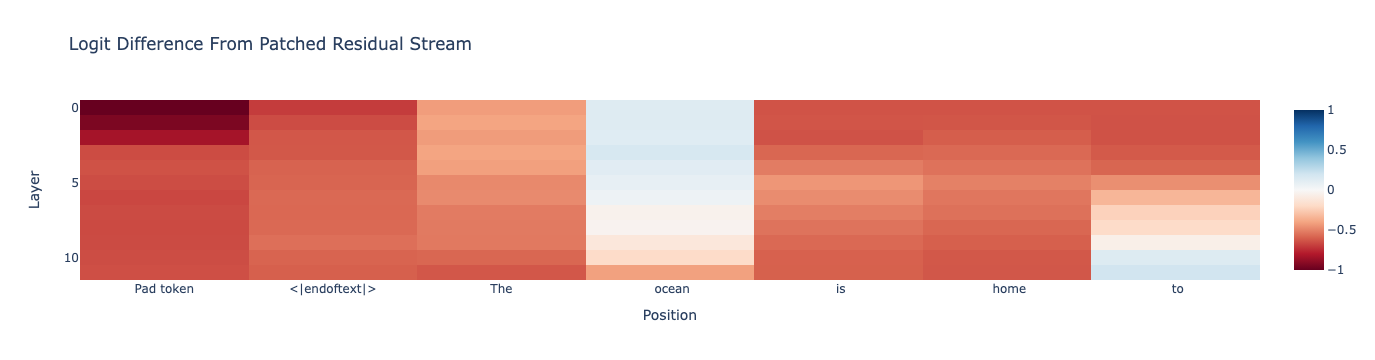

Tigers live in the


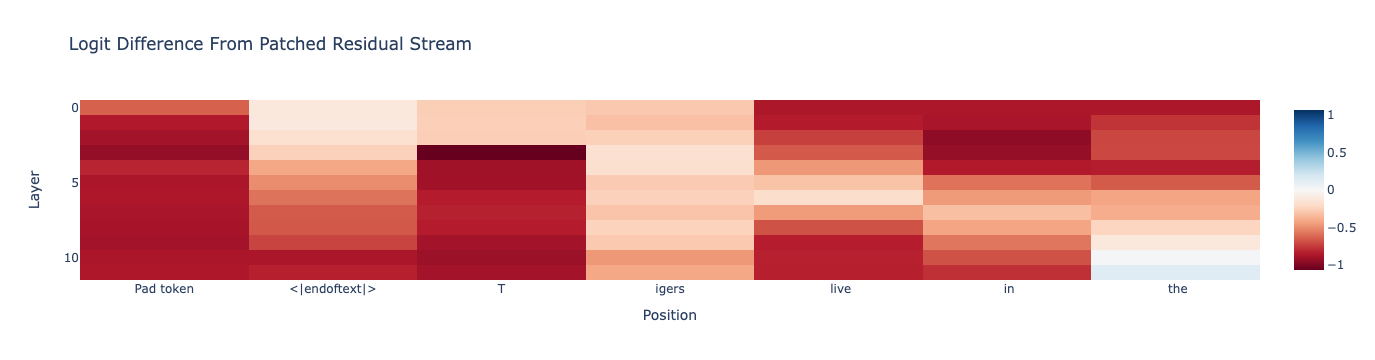

The jungle is home to


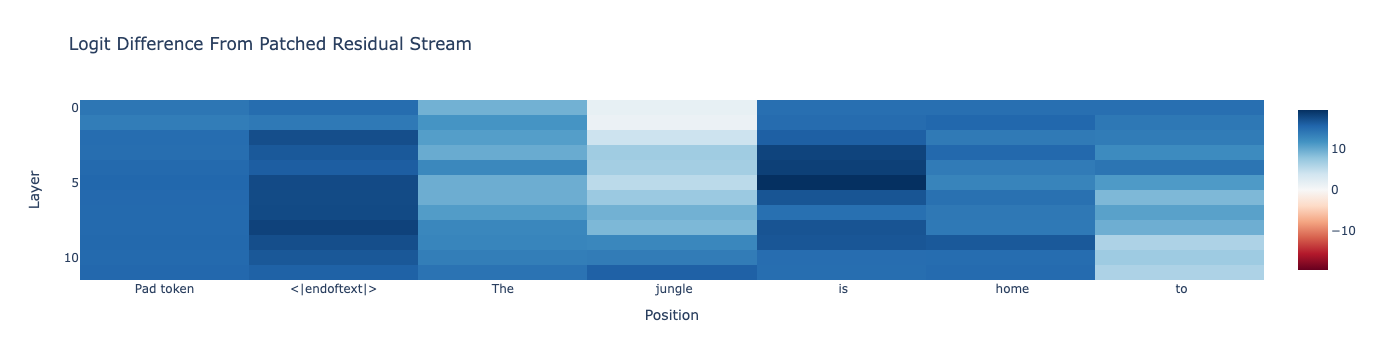

Camels live in the


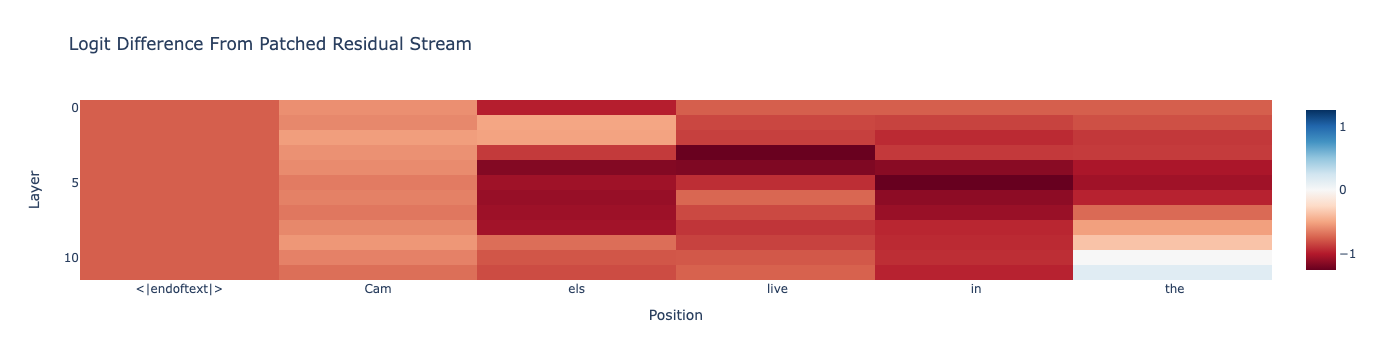

The desert is home to


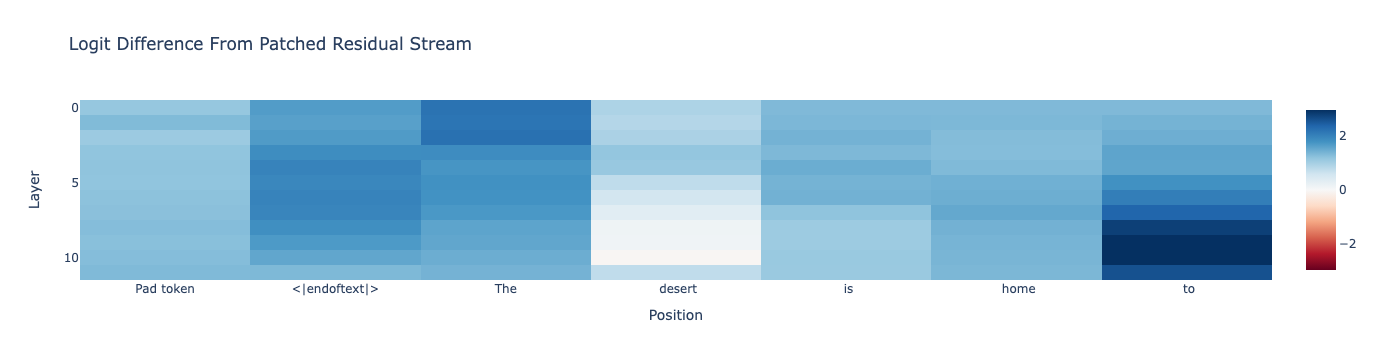

Bill Gates is the founder of


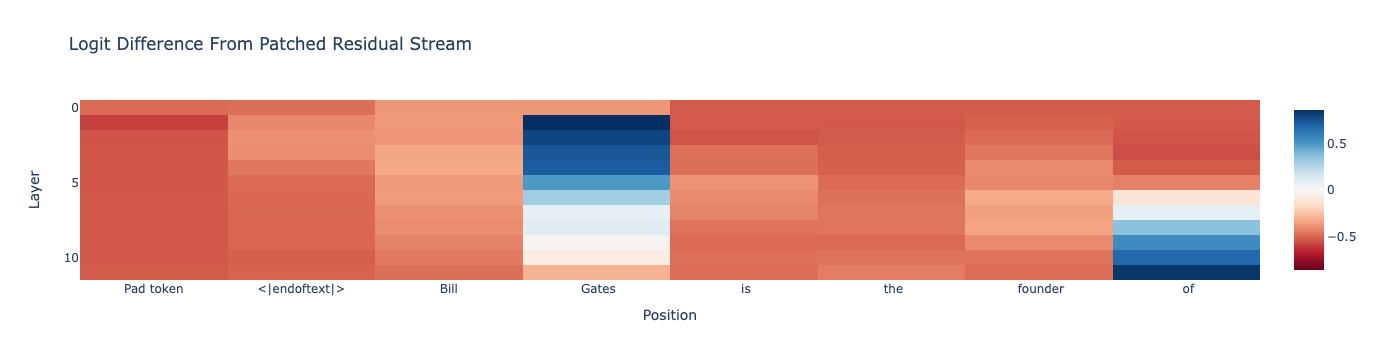

Microsoft was founded by


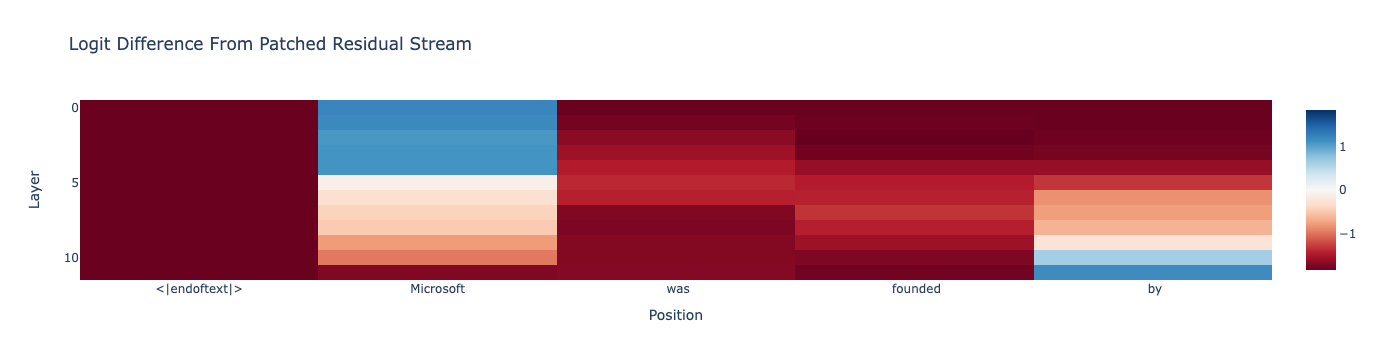

The Nile is the longest river in


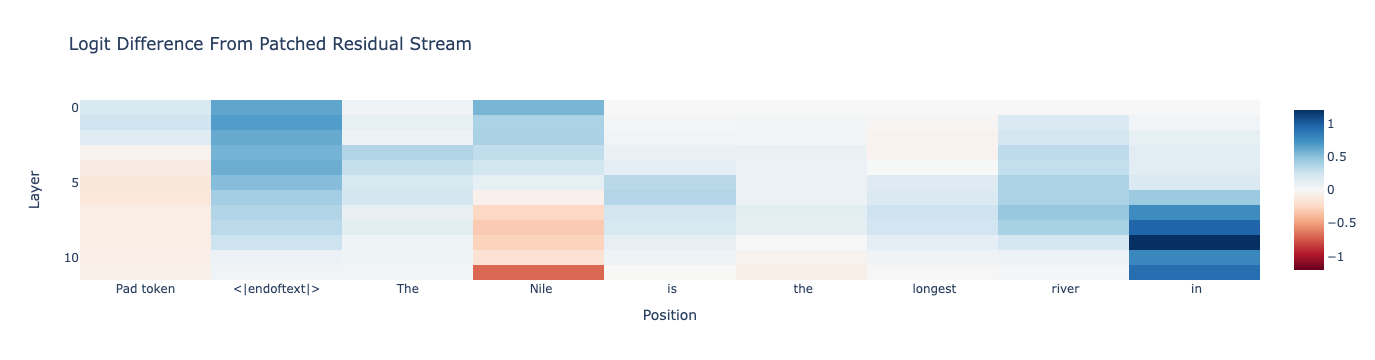

The longest river in Africa is the


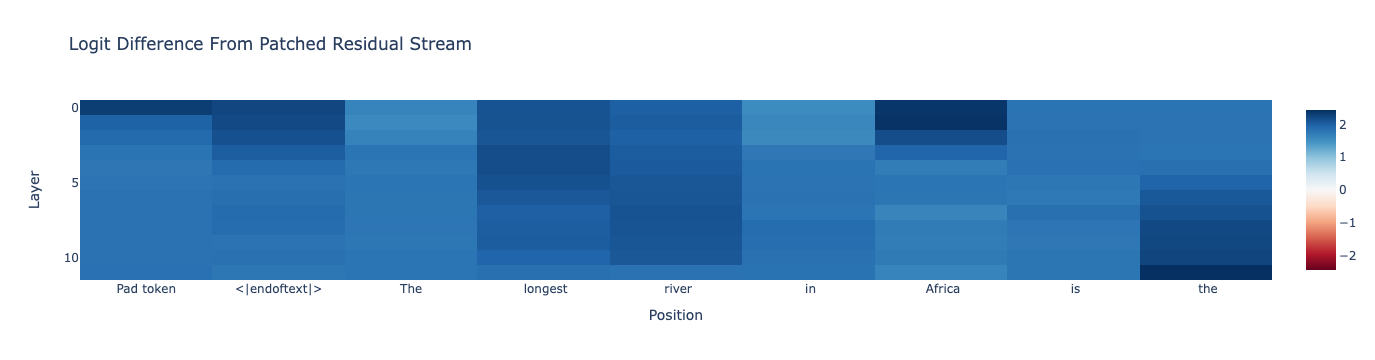

The Yangtze is the longest river in


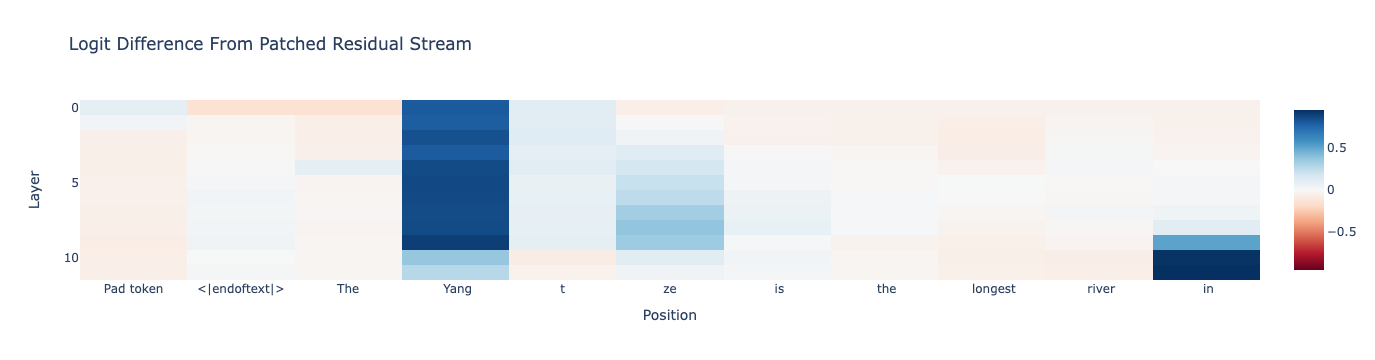

The longest river in Asia is the


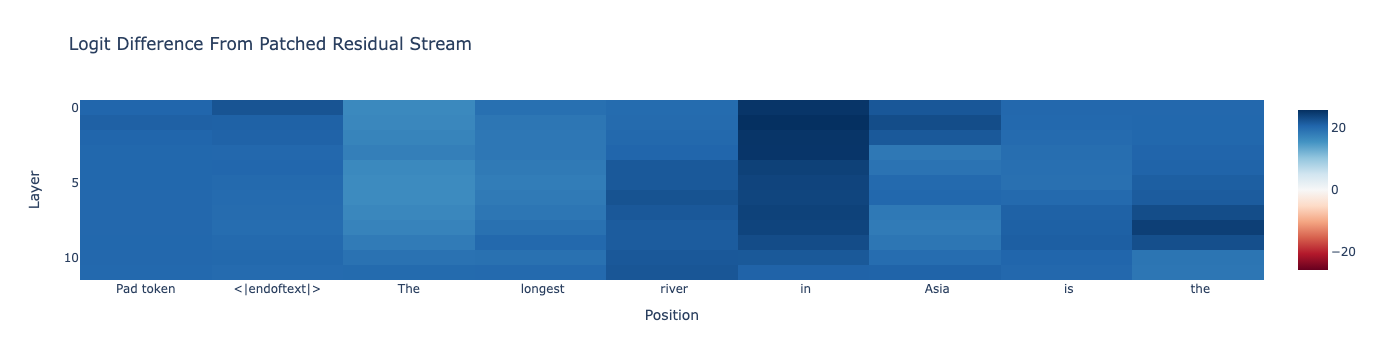

English is the language spoken in


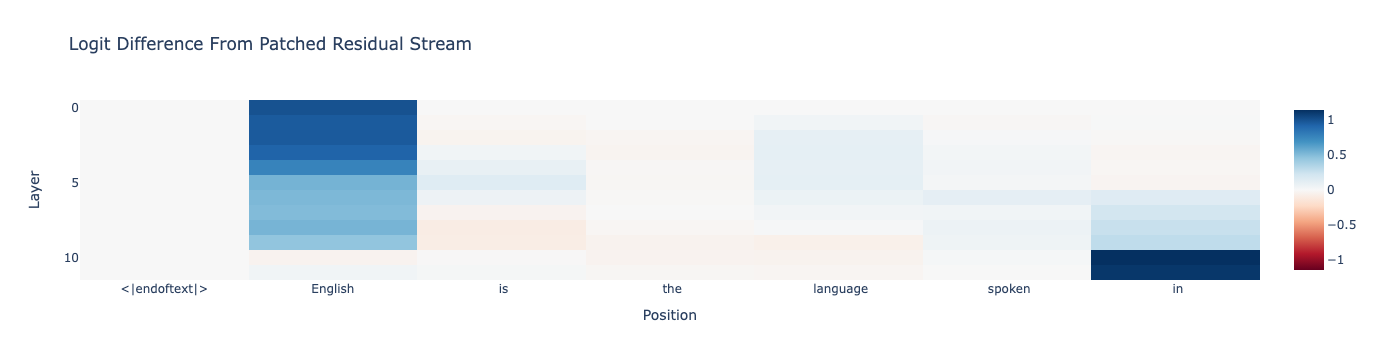

People from England speak


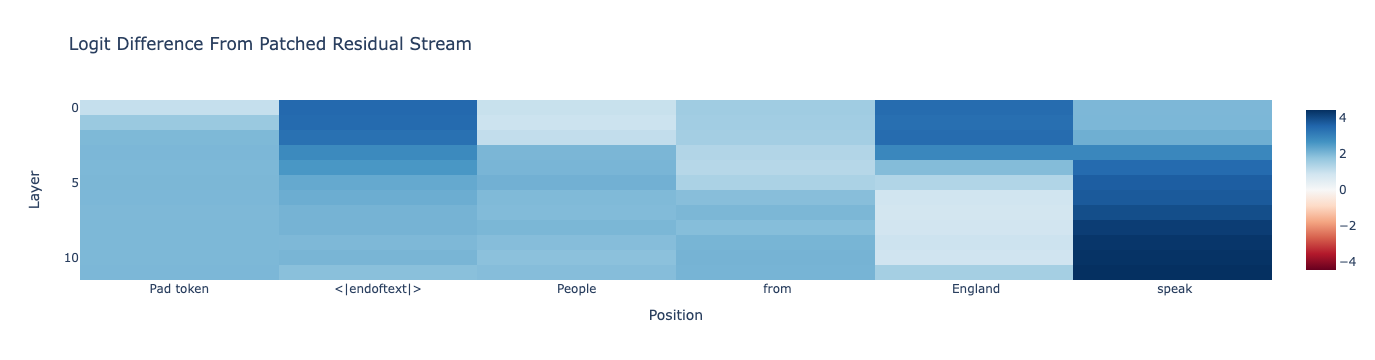

French is the language spoken in


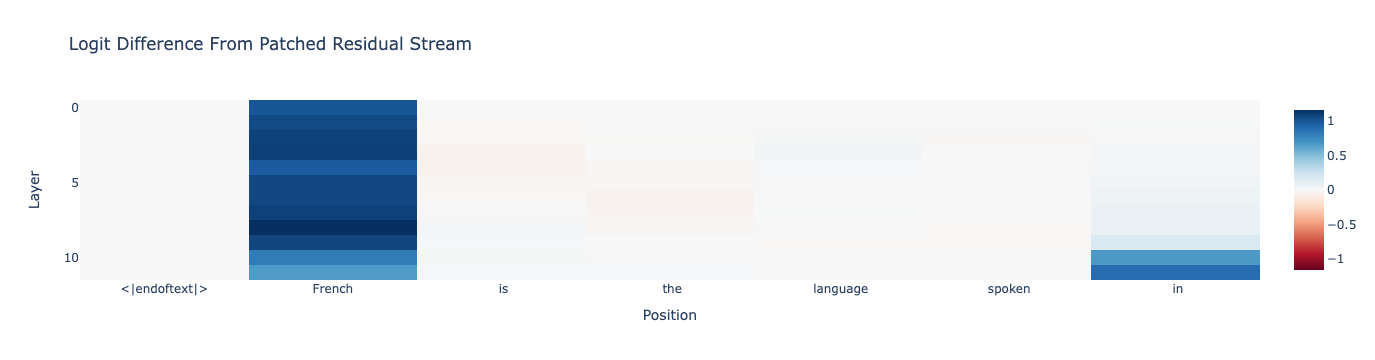

People from France speak


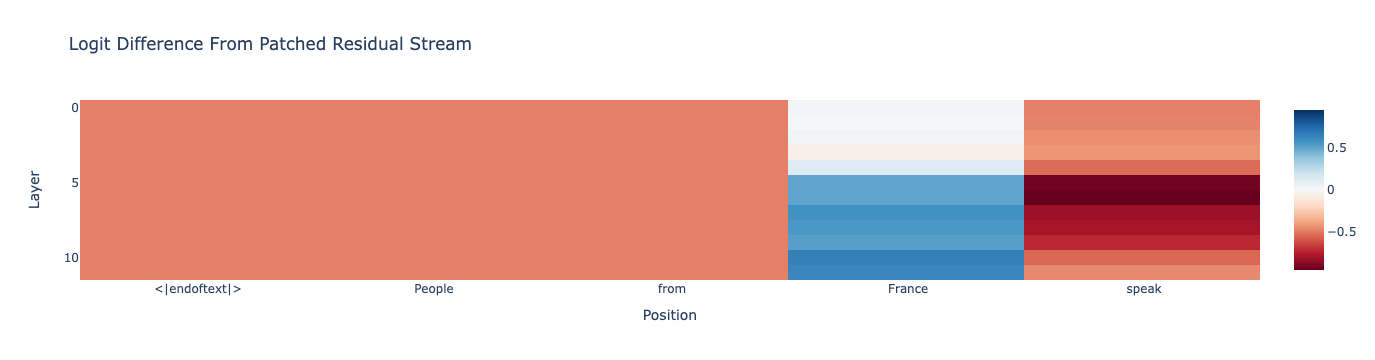

German is the language spoken in


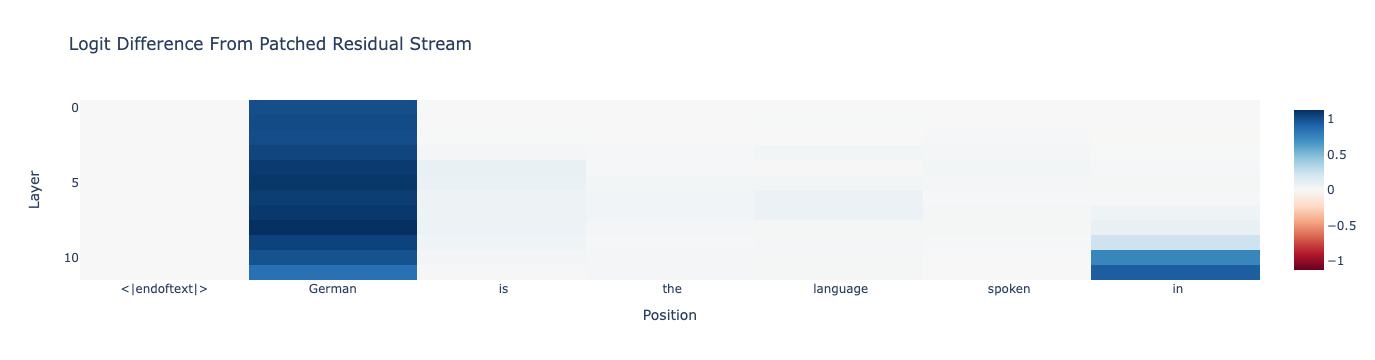

People from Germany speak


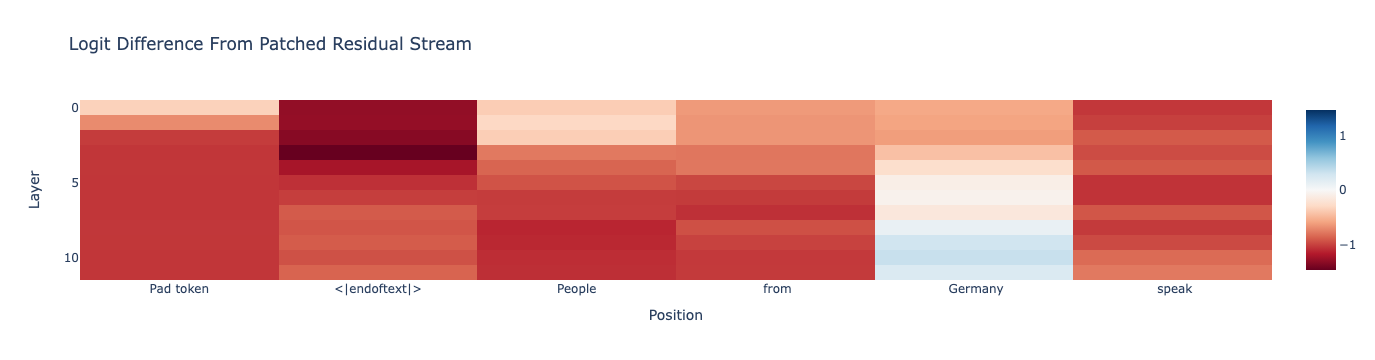

In [449]:

for i,(forward_patch, backward_patch) in enumerate(zip(forward_patches, backward_patches)): 
    prompt = forward_clean_prompts[i]
    print(prompt)
    x = model.to_str_tokens(prompt)
    while len(x) < forward_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(forward_patch,
           x=x,
           title="Logit Difference From Patched Residual Stream", labels={"x":"Position", "y":"Layer"})
    
    prompt = backward_clean_prompts[i]
    print(prompt)
    x = model.to_str_tokens(prompt)
    while len(x) < backward_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(backward_patch,
           x=x,
           title="Logit Difference From Patched Residual Stream", labels={"x":"Position", "y":"Layer"})

## Causal trace on Layers

In [467]:
def causal_tracing_on_layers(clean_prompts: List[str], corrupted_prompts: List[str], correct_answers: List[str], counterfactual_answers: List[List[str]], sample_idx=None):    
    if sample_idx is not None: 
        clean_prompts = [c for i,c in enumerate(clean_prompts) if i in sample_idx]
        corrupted_prompts = [c for i,c in enumerate(corrupted_prompts) if i in sample_idx]
        correct_answers = [c for i,c in enumerate(correct_answers) if i in sample_idx]
        counterfactual_answers = [c for i,c in enumerate(counterfactual_answers) if i in sample_idx]
    
    # patched_residual_stream_diff = torch.zeros(model.cfg.n_layers, padded_original_prompt_tokens.shape[1], device="cpu", dtype=torch.float32)
    attn_patches = []
    mlp_patches = []
    for i in range(len(clean_prompts)): 
        clean_prompt = clean_prompts[i]
        corrupted_prompt = corrupted_prompts[i]
        correct_answer = correct_answers[i]
        counterfactuals = counterfactual_answers[i]
        
        clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True)
        corrupted_tokens = model.to_tokens(corrupted_prompt, prepend_bos=True)
        
        clean_tokens, corrupted_tokens = pad_to_same_length(clean_tokens, corrupted_tokens)
        
        clean_logit_diffs = get_logit_difference_from_token_prompt([clean_tokens], [correct_answer], [counterfactuals], disp=False, per_prompt=True)
        corrupted_logit_diffs = get_logit_difference_from_token_prompt([corrupted_tokens], [correct_answer], [counterfactuals], disp=False, per_prompt=True)
        
        clean_logits, clean_cache = model.run_with_cache(clean_tokens, return_type="logits")
        corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")
        
        
        if clean_tokens.shape[-1] != corrupted_tokens.shape[-1]:
            raise ValueError(f"different number of tokens on prompt {i}")
            
        patched_attn_diff = torch.zeros(model.cfg.n_layers, clean_tokens.shape[-1], device=device, dtype=torch.float32)
        patched_mlp_diff = torch.zeros(model.cfg.n_layers, clean_tokens.shape[-1], device=device, dtype=torch.float32)
        
        for layer in range(model.cfg.n_layers):
            for position in range(clean_tokens.shape[-1]):

                hook_fn = partial(patch_residual_component, pos=position, clean_cache=clean_cache)
                patched_attn_logits = model.run_with_hooks(
                    corrupted_tokens,
                    fwd_hooks = [(utils.get_act_name("attn_out", layer),
                        hook_fn)],
                    return_type="logits"
                )
                patched_attn_logit_diff = logits_to_ave_logit_diff(patched_attn_logits, correct_answer, counterfactuals)
                
                patched_mlp_logits = model.run_with_hooks(
                    corrupted_tokens,
                    fwd_hooks = [(utils.get_act_name("mlp_out", layer),
                        hook_fn)],
                    return_type="logits"
                )
                patched_mlp_logit_diff = logits_to_ave_logit_diff(patched_mlp_logits, correct_answer, counterfactuals)

                patched_attn_diff[layer, position] = normalize_patched_logit_diff(
                                                                                patched_attn_logit_diff,
                                                                                torch.mean(corrupted_logit_diffs),
                                                                                torch.mean(clean_logit_diffs)
                                                                                 )
                patched_mlp_diff[layer, position] = normalize_patched_logit_diff(patched_mlp_logit_diff,
                                                                                 torch.mean(corrupted_logit_diffs),
                                                                                torch.mean(clean_logit_diffs)
                                                                                 )
            
     
        attn_patches.append(patched_attn_diff)
        mlp_patches.append(patched_mlp_diff)
    return attn_patches, mlp_patches

In [ ]:
forward_clean_prompts = [
    d["sentence_1"].format(subject=d["subject_1"], obj="")[:-1] for d in dataset
]
forward_correct_answers = [d["object_1"] for d in dataset]
forward_counters = [d["counter_factual_1"] for d in dataset]

forward_attn_patches, forward_mlp_patches = causal_tracing_on_layers(clean_prompts=forward_clean_prompts,
                                                       corrupted_prompts=forward_corrupted_prompts,
                                                       correct_answers=forward_correct_answers,
                                                       counterfactual_answers=forward_counters)


In [ ]:
back_clean_prompts = [
    d["sentence_2"].format(subject=d["subject_2"], obj="")[:-1] for d in dataset
]
back_correct_answers = [d["object_2"] for d in dataset]
back_counters = [d["counter_factual_2"] for d in dataset]

back_attn_patches, back_mlp_patches = causal_tracing_on_layers(clean_prompts=back_clean_prompts,
                                                       corrupted_prompts=backward_corrupted_prompts,
                                                       correct_answers=back_correct_answers,
                                                       counterfactual_answers=back_counters)


In [ ]:
for i in range(len(forward_clean_prompts)): 
    forward_prompt = forward_clean_prompts[i]
    print(forward_prompt)
    attn_patch = forward_attn_patches[i]
    mlp_patch = forward_mlp_patches[i]
    
    x = model.to_str_tokens(forward_prompt)
    while len(x) < attn_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(attn_patch,
           x=x,
           title="Logit Difference From Patched Attention Layer (forward)", labels={"x":"Position", "y":"Layer"})

    x = model.to_str_tokens(forward_prompt)
    while len(x) < mlp_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(mlp_patch,
           x=x,
           title="Logit Difference From Patched MLP Layer (forward)", labels={"x":"Position", "y":"Layer"})
    
    backward_prompt = back_clean_prompts[i]
    print(backward_prompt)
    x = model.to_str_tokens(backward_prompt)
    while len(x) < attn_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(attn_patch,
           x=x,
           title="Logit Difference From Patched Attention Layer (backward)", labels={"x":"Position", "y":"Layer"})

    x = model.to_str_tokens(backward_prompt)
    while len(x) < mlp_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(mlp_patch,
           x=x,
           title="Logit Difference From Patched MLP Layer (backward)", labels={"x":"Position", "y":"Layer"})
    

## Causal Trace on Heads

In [463]:
def patch_head_vector(
    corrupted_head_vector: Float[torch.Tensor, "batch pos head_index d_head"],
    hook,
    head_index,
    clean_cache):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][:, :, head_index, :]
    return corrupted_head_vector


def causal_tracing_on_heads(clean_prompts: List[str], corrupted_prompts: List[str], correct_answers: List[str], counterfactual_answers: List[List[str]], sample_idx=None):    
    if sample_idx is not None: 
        clean_prompts = [c for i,c in enumerate(clean_prompts) if i in sample_idx]
        corrupted_prompts = [c for i,c in enumerate(corrupted_prompts) if i in sample_idx]
        correct_answers = [c for i,c in enumerate(correct_answers) if i in sample_idx]
        counterfactual_answers = [c for i,c in enumerate(counterfactual_answers) if i in sample_idx]
    
    # patched_residual_stream_diff = torch.zeros(model.cfg.n_layers, padded_original_prompt_tokens.shape[1], device="cpu", dtype=torch.float32)
    patches = []
    for i in range(len(clean_prompts)): 
        clean_prompt = clean_prompts[i]
        corrupted_prompt = corrupted_prompts[i]
        correct_answer = correct_answers[i]
        counterfactuals = counterfactual_answers[i]
        
        clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True)
        corrupted_tokens = model.to_tokens(corrupted_prompt, prepend_bos=True)
        
        clean_tokens, corrupted_tokens = pad_to_same_length(clean_tokens, corrupted_tokens)
        
        clean_logit_diffs = get_logit_difference_from_token_prompt([clean_tokens], [correct_answer], [counterfactuals], disp=False, per_prompt=True)
        corrupted_logit_diffs = get_logit_difference_from_token_prompt([corrupted_tokens], [correct_answer], [counterfactuals], disp=False, per_prompt=True)
        
        clean_logits, clean_cache = model.run_with_cache(clean_tokens, return_type="logits")
        corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")
        
        
        if clean_tokens.shape[-1] != corrupted_tokens.shape[-1]:
            raise ValueError(f"different number of tokens on prompt {i}")
            
        patched_head_z_diff = torch.zeros(model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32)
        for layer in range(model.cfg.n_layers):
            for head_index in range(model.cfg.n_heads):
                hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=clean_cache)
                patched_logits = model.run_with_hooks(
                    corrupted_tokens,
                    fwd_hooks = [(utils.get_act_name("z", layer, "attn"),
                        hook_fn)],
                    return_type="logits"
                )
                patched_logit_diff = logits_to_ave_logit_diff(patched_logits, correct_answer, counterfactuals)
                patched_head_z_diff[layer, head_index] = normalize_patched_logit_diff(patched_logit_diff, torch.mean(corrupted_logit_diffs),torch.mean(clean_logit_diffs))
     
        patches.append(patched_head_z_diff)
    return patches

In [465]:
forward_clean_prompts = [
    d["sentence_1"].format(subject=d["subject_1"], obj="")[:-1] for d in dataset
]
forward_correct_answers = [d["object_1"] for d in dataset]
forward_counters = [d["counter_factual_1"] for d in dataset]

forward_patches = causal_tracing_on_heads(clean_prompts=forward_clean_prompts,
               corrupted_prompts=forward_corrupted_prompts,
               correct_answers=forward_correct_answers,
               counterfactual_answers=forward_counters)

backward_clean_prompts = [
    d["sentence_2"].format(subject=d["subject_2"], obj="")[:-1] for d in dataset
]
backward_correct_answers = [d["object_2"] for d in dataset]
backward_counters = [d["counter_factual_2"] for d in dataset]

backward_patches = causal_tracing_on_heads(clean_prompts=backward_clean_prompts,
               corrupted_prompts=backward_corrupted_prompts,
               correct_answers=backward_correct_answers,
               counterfactual_answers=backward_counters)

Paris is the capital of


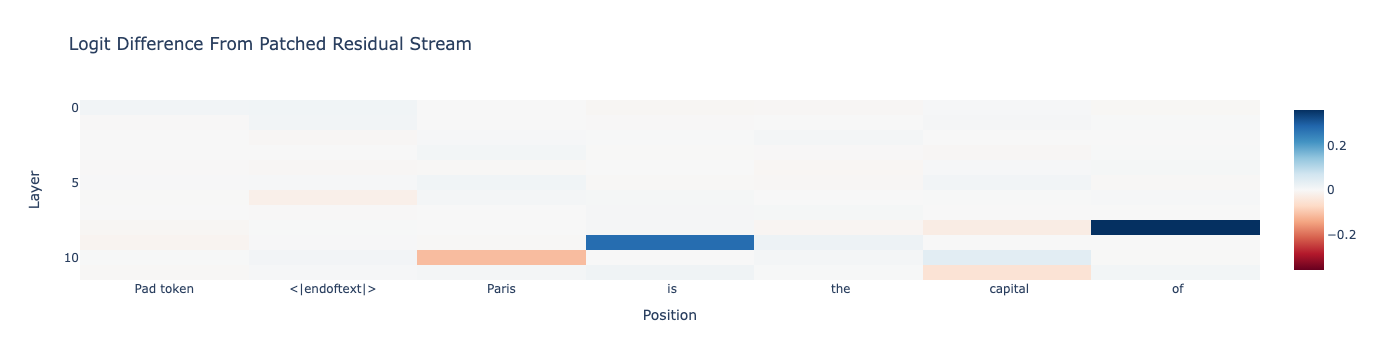

The capital of France is


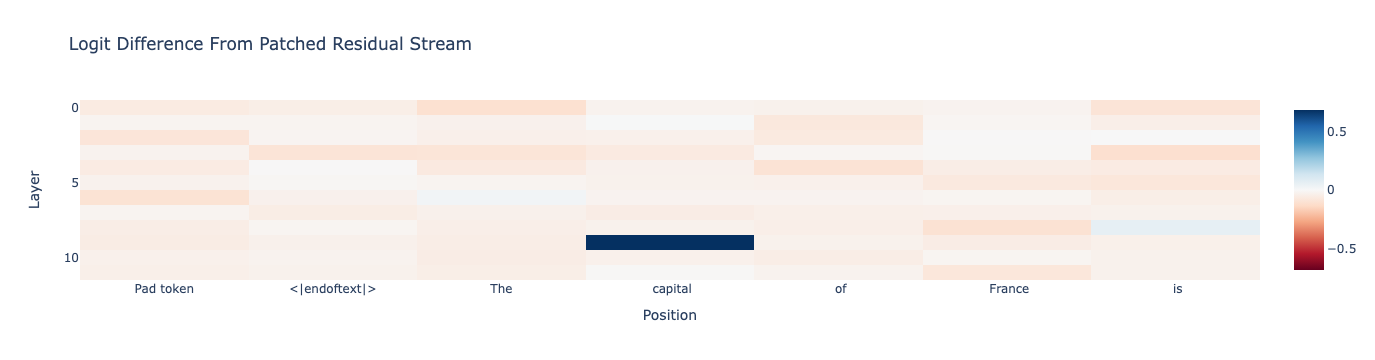

Rome is the capital of


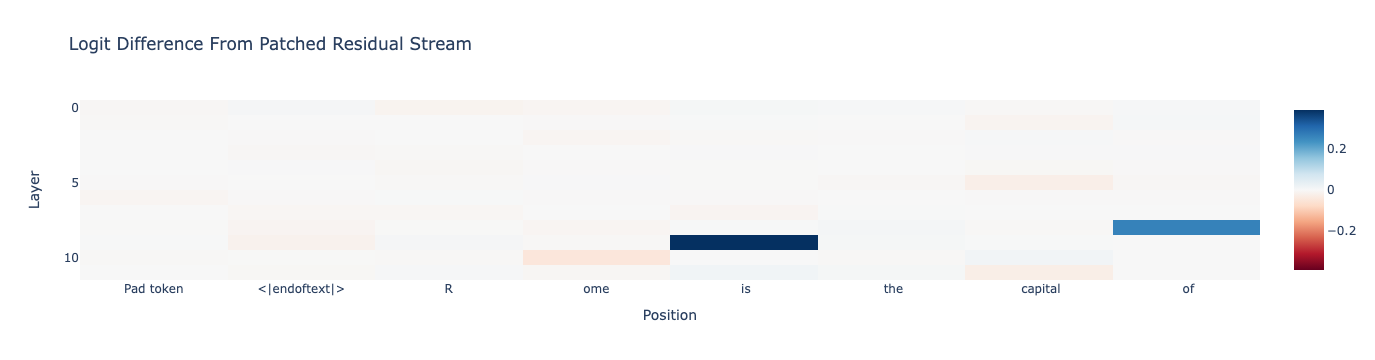

The capital of Italy is


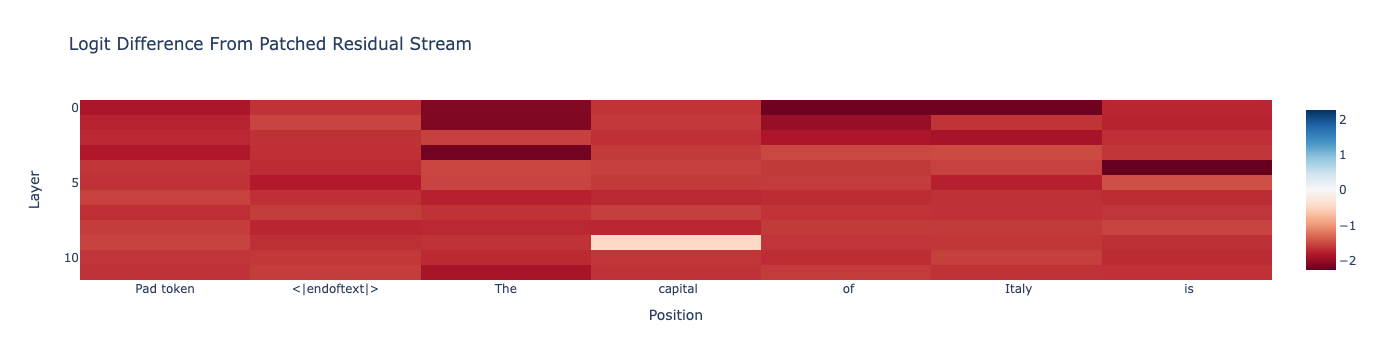

Ottawa is the capital of


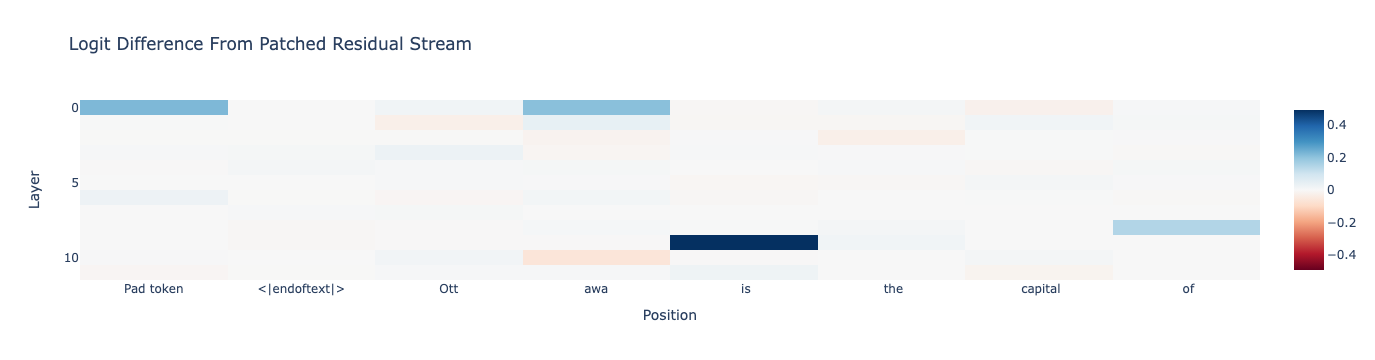

The capital of Canada is


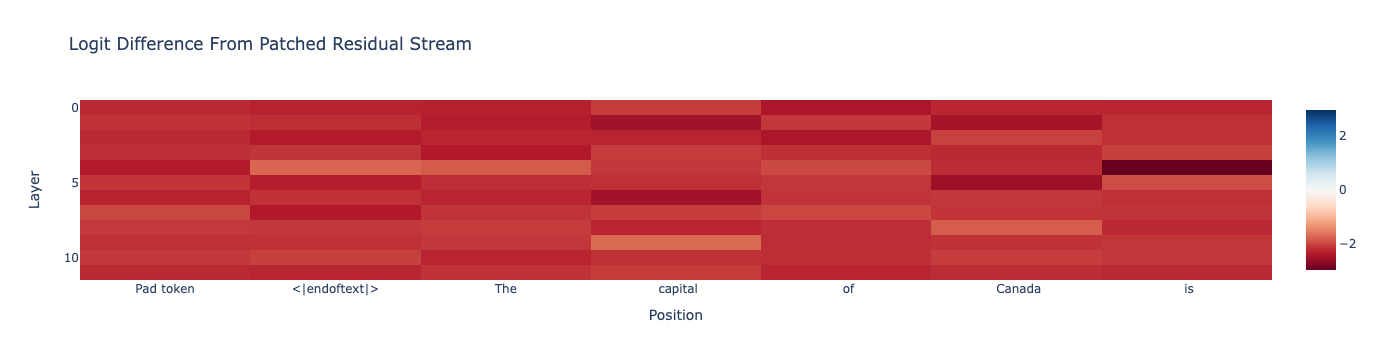

Dolphins live in the


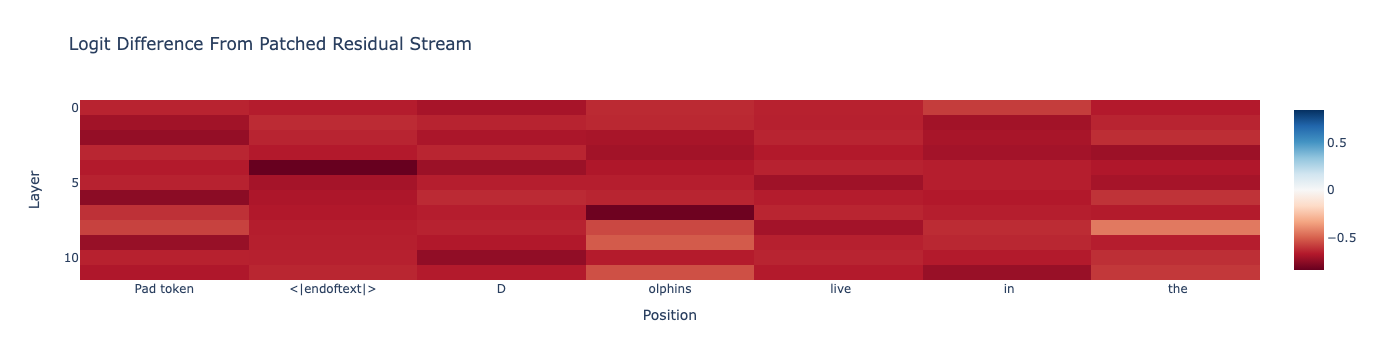

The ocean is home to


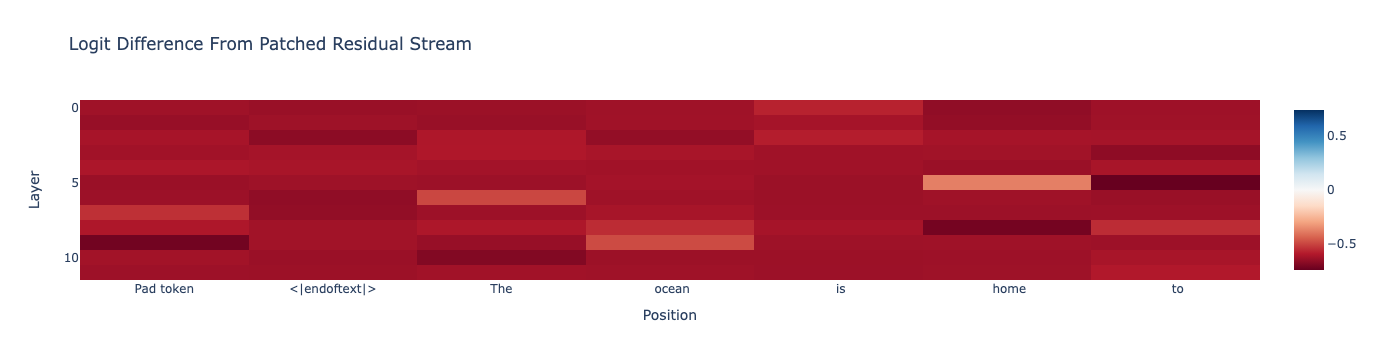

Tigers live in the


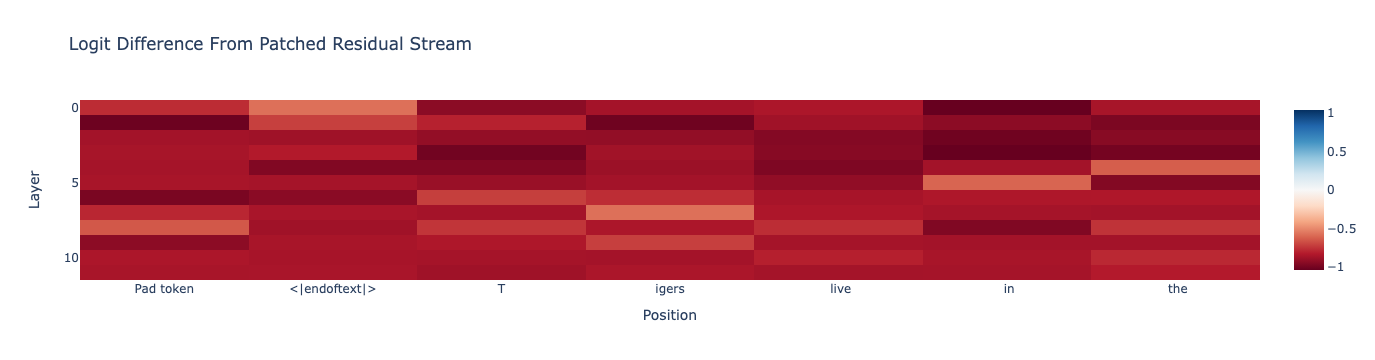

The jungle is home to


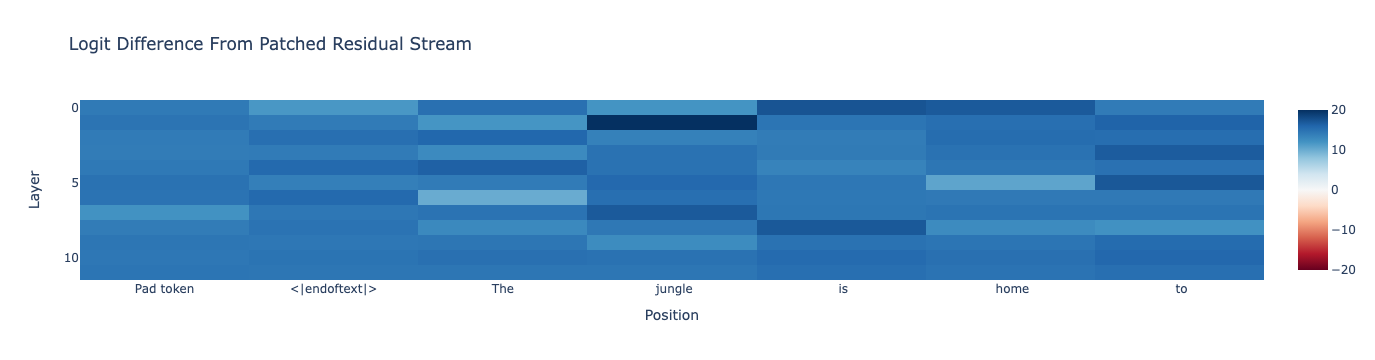

Camels live in the


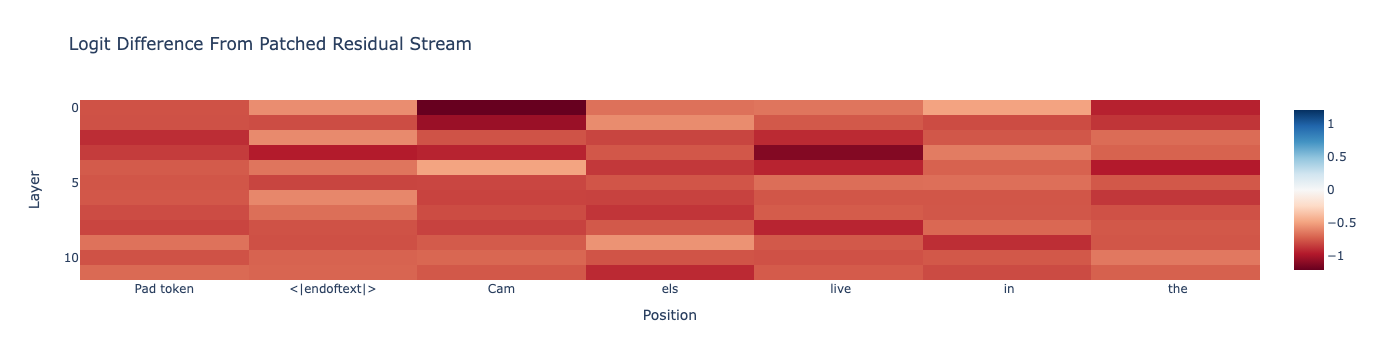

The desert is home to


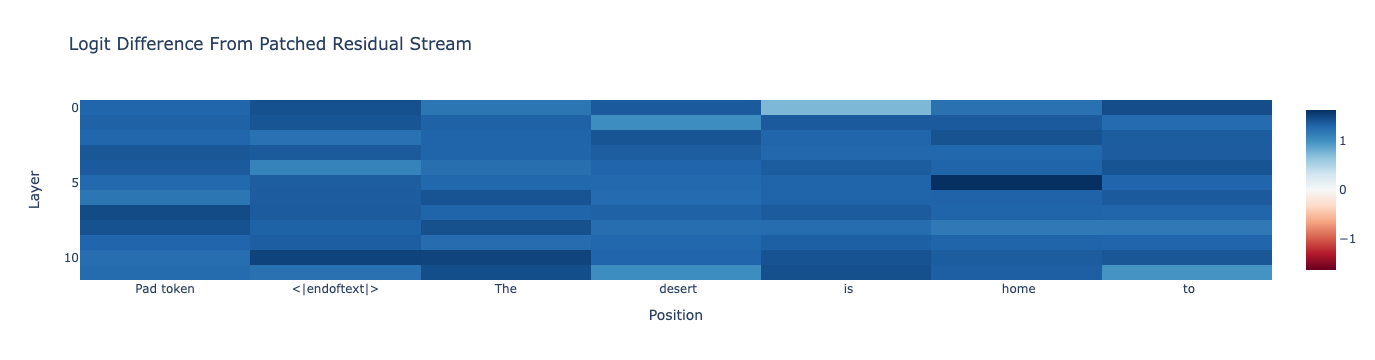

Bill Gates is the founder of


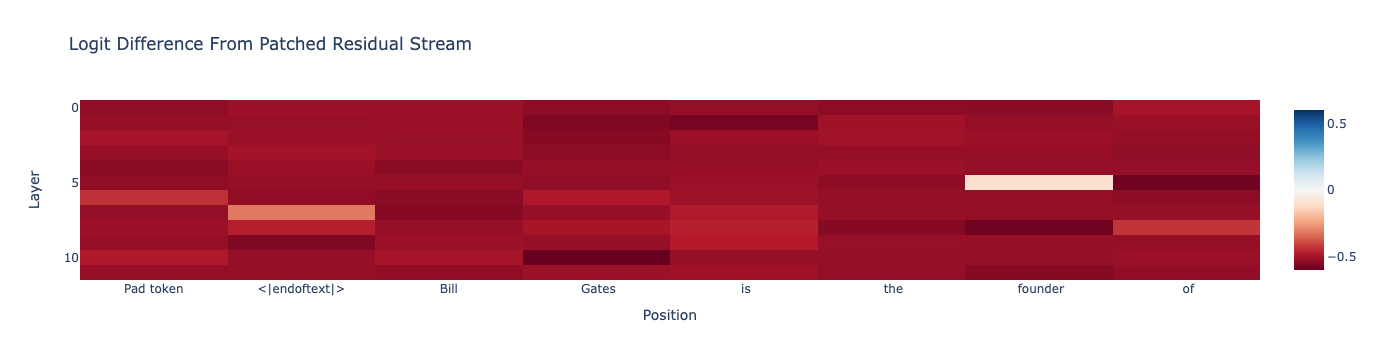

Microsoft was founded by


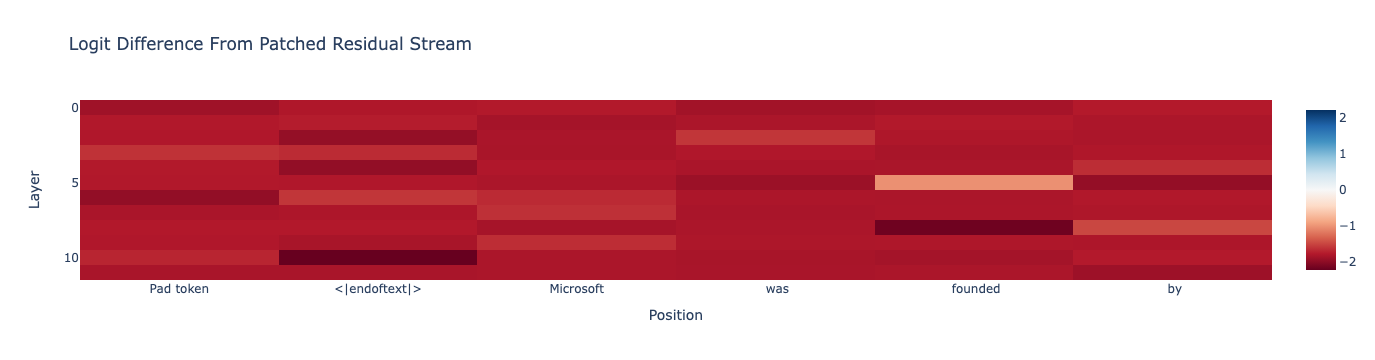

The Nile is the longest river in


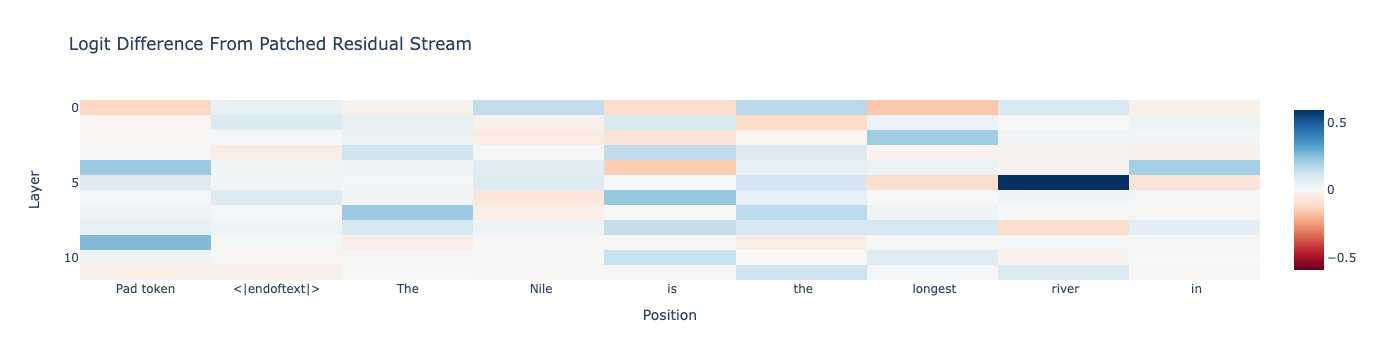

The longest river in Africa is the


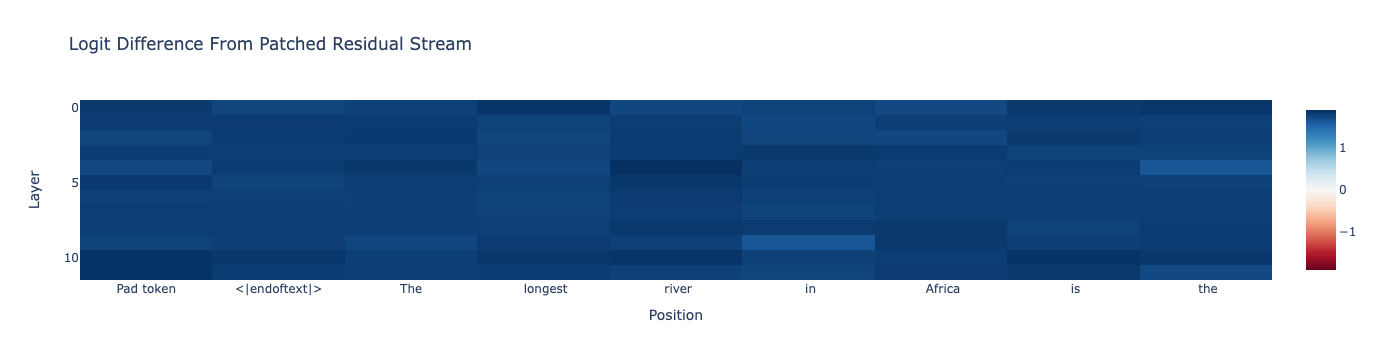

The Yangtze is the longest river in


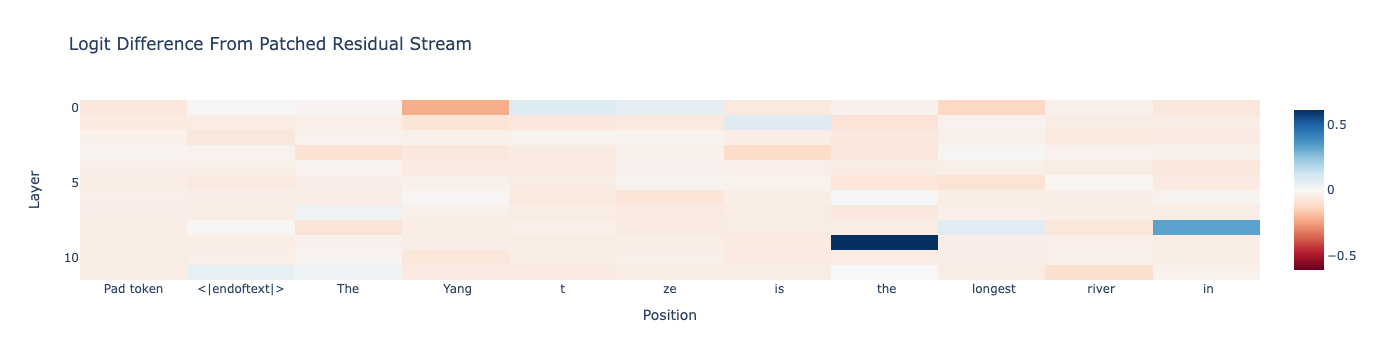

The longest river in Asia is the


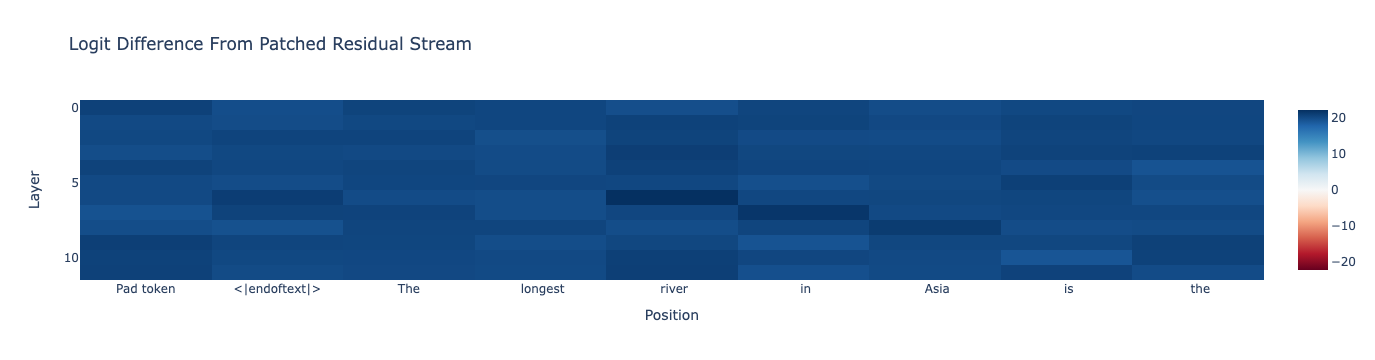

English is the language spoken in


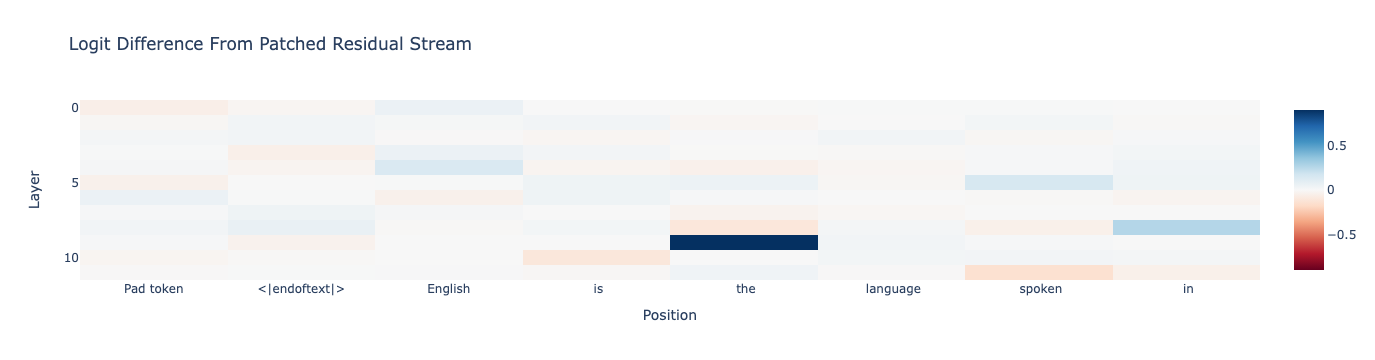

People from England speak


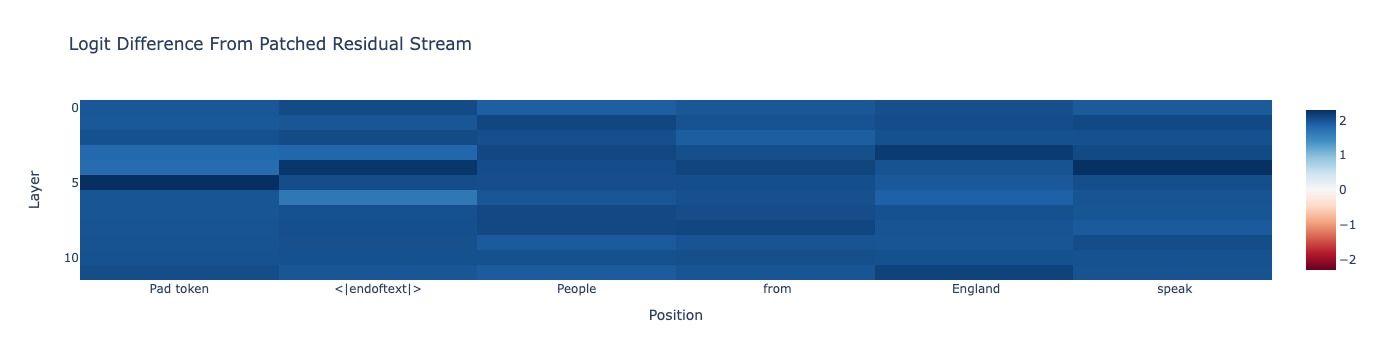

French is the language spoken in


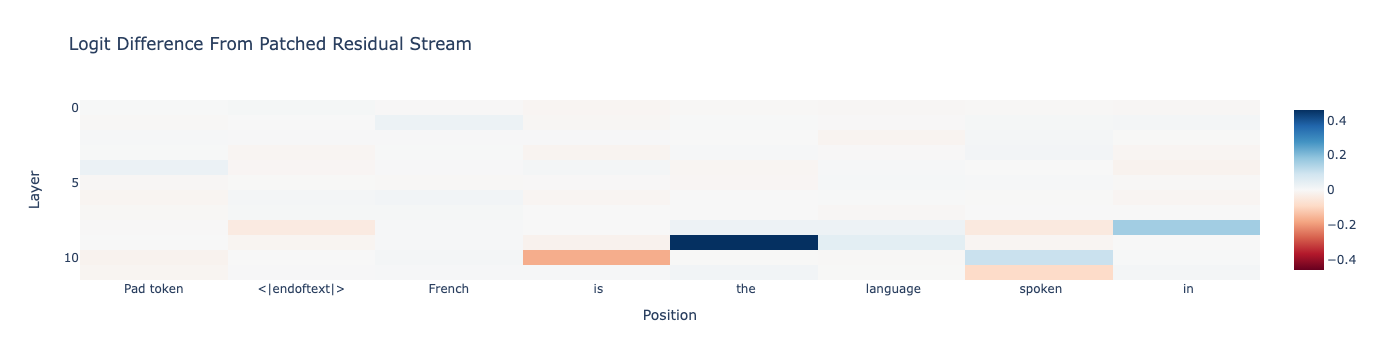

People from France speak


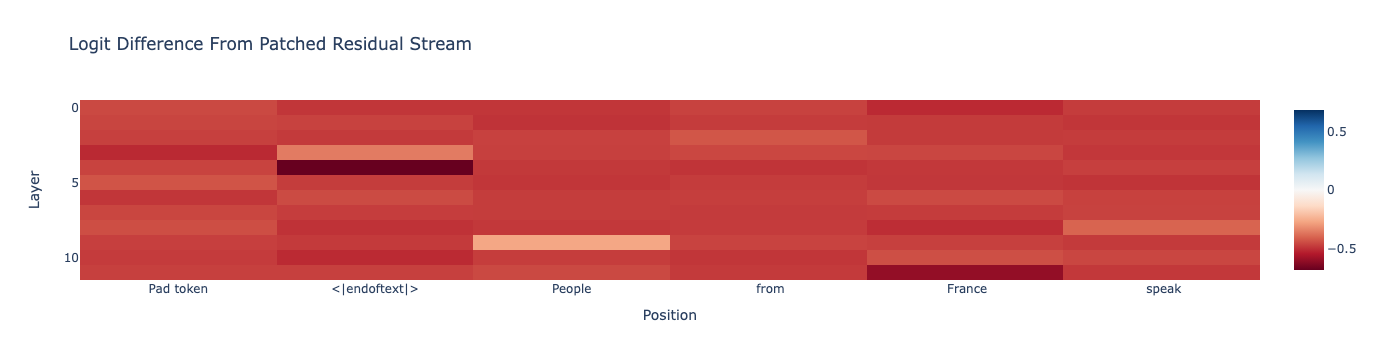

German is the language spoken in


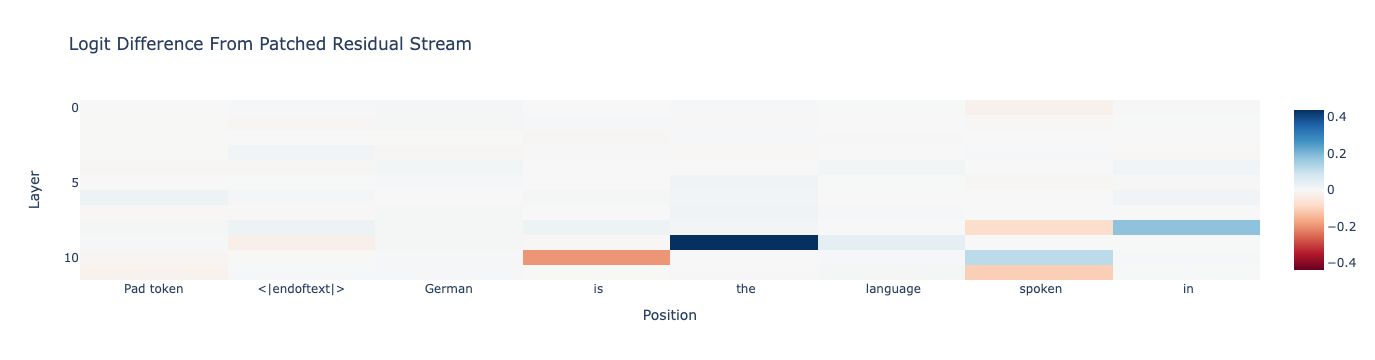

People from Germany speak


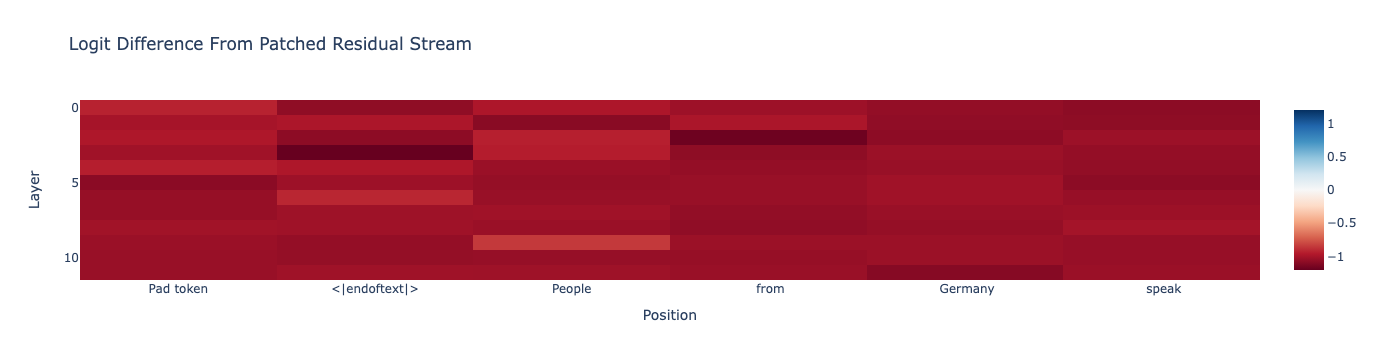

In [466]:

for i,(forward_patch, backward_patch) in enumerate(zip(forward_patches, backward_patches)): 
    prompt = forward_clean_prompts[i]
    print(prompt)
    x = model.to_str_tokens(prompt)
    while len(x) < forward_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(forward_patch,
           x=x,
           title="Logit Difference From Patched Residual Stream", labels={"x":"Position", "y":"Layer"})
    
    prompt = backward_clean_prompts[i]
    print(prompt)
    x = model.to_str_tokens(prompt)
    while len(x) < backward_patch.shape[-1]: 
        x.insert(0, "Pad token")
    imshow(backward_patch,
           x=x,
           title="Logit Difference From Patched Residual Stream", labels={"x":"Position", "y":"Layer"})